## Modelling SEIR Epidemic Spread with Continuous Populations

**Yuval Berman, 22485979 (UWA)**

Last modified: Nov 10th 2021 (just comments and descriptions)

This code is one of the first iterations of spreading the SEIR model all over WA. It's a good start, however it treats number of people as a continuous variable (rather than discrete). This could be good to talk about at the start of the thesis before we add the necessary restrictions.

In [1]:
#Import necessary libraries
import math
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from numpy import genfromtxt
import matplotlib.image as mpimg
import pandas as pd
import scipy
import time

In [2]:
# A function that opens a file and reads it into an array (found from stack overflow)
def readFile(fileName):
        fileObj = open(fileName, "r") #opens the file in read mode
        words = fileObj.read().splitlines() #puts the file into an array
        arr = []
        for item in words:
            arr.append(item.split('\t'))
        fileObj.close()
        return arr

In [3]:
# Waloc has 4 columns: Town, population, longitude, latitude.
waloc = readFile('/Volumes/HardDrive/WALOC.txt')

In [4]:
# Create a network from a weekly dataset
my_data = genfromtxt('/Volumes/HardDrive/WA_297_big/WA_297_20200322_20200328.txt', delimiter='\t')
A = nx.from_numpy_matrix(my_data)
A = nx.DiGraph(A)

# Use this network to label all the nodes, matching their index to the town name
towns = [item[0] for item in waloc]
labeldict = {}
for node in list(A.nodes()):
    labeldict[node] = towns[node]

In [5]:
# Read in all weekly adjacnecy matrices, assigning each entry to a dictionary.
wa_297 = os.listdir("/Volumes/HardDrive/kalman_all2all_big/")[:-1]

d = {}
for i in range(len(wa_297)):
    d[str(i)] = pd.read_csv("/Volumes/HardDrive/kalman_all2all_big/"+wa_297[i], header = None, sep ='\t')

In [10]:
# Number of towns we'll be investigating in this run (max = 58 for bigs only, 297 for all towns)
num = 3

In [11]:
# My main function! 
def dynamics(towns,t,data = d,a=0.2, beta=1/5.2, gamma=1/12, omega = 0.09, mu = 0.0001):
    x = towns # A list of the initial ratios in each compartment
    no_towns = int(len(x)/4)
    xdot = np.zeros(4*no_towns) #Initialise the gradient vector
    week = int(t//7)
    #print(week)
    
    # Take flow as the relevant week's adjacency matrix
    if week < 67:
        flow = d[str(week)].copy()*1000
    
    # If using too big of a range, take the week as the last one (alternatively can write a function which takes ave)
    else:
        flow = d['67'].copy()*1000
    
    # At the 20th week we start gradually imposing restrictions (ie modifying alpha which changes R0)
    crit = 20
    if week > crit:
        alpha = a - 0.12*(week-crit)/(68-crit)
    else:
        alpha = a
        
    # Iterate over each town    
    for i in range(no_towns):
        incoming = [0]*4
        outgoing = [0]*4
        for j in range(no_towns):
            for k in range(4):
                # Get the movement between the two towns
                incoming[k] += flow[j][i] * x[4*j+k]
                outgoing[k] += flow[i][j] * x[4*i+k]
            print(incoming,outgoing)
        
        #SEIR equations + the incoming - the outgoing prop of population
        xdot[4*i+0] = -alpha*x[4*i]*x[4*i+2] - mu*x[4*i] - outgoing[0] + incoming[0]
        xdot[4*i+1] = alpha*x[4*i]*x[4*i+2] - beta*x[4*i+1] + omega*x[4*i+3]*x[4*i+2]- outgoing[1] + incoming[1]
        xdot[4*i+2] = beta*x[4*i+1] - gamma*x[4*i+2]- outgoing[2] + incoming[2]
        xdot[4*i+3] = gamma*x[4*i+2] + mu*x[4*i] - omega*x[4*i+3]*x[4*i+2]- outgoing[3] + incoming[3]
    return xdot

In [12]:
# Initialise an infection in Perth
infect = 4.75*10**(-5)
x_init = (0.45-infect,0,infect,0.55)

# Everywhere else is roughly 50% vaxxed
y_init = (0.5,0,0,0.5)
town_init = (x_init+y_init*(num-1))

# Each t is a day
t_init=0; t_final = 600; t_step = 1
tpoints = np.arange(t_init,t_final,t_step)

# Use odeint to run it over all the towns!
start = time.time()
y = odeint(dynamics, town_init, tpoints)
end = time.time()

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1955964010739855e-06, 0.0, 0.0, 2.1955964010739855e-06] [5.751680493061315e-06, 0.0, 6.071859216704263e-10, 7.0305738298680935e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.751680493061315e-06, 0.0, 6.071859216704263e-10, 7.0305738298680935e-06] [2.1955964010739855e-06, 0.0, 0.0, 2.1955964010739855e-06]
[5.751680493061315e-06, 0.0, 6.071859216704263e-10, 7.0305738298680935e-06] [2.1955964010739855e-06, 0.0, 0.0, 2.1955964010739855e-06]
[5.751680493061315e-06, 0.0, 6.071859216704263e-10, 7.0305738298680935e-06] [2.1955964010739855e-06, 0.0, 0.0, 2.1955964010739855e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.195596376178422e-06, 0.0, 3.2547289048104477e-19, 2.1955964304674514e-06] [5.751680410631283e-06, 1.033896216249908e-14, 6.071797441003285e-10, 7.03057389504229e-0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1949341011226752e-06, 2.6645354243785103e-15, 7.500304829297944e-15, 2.196378371725183e-06] [5.74950312157297e-06, 1.859417802147763e-10, 5.223183994876299e-10, 7.0323017333958285e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.74950312157297e-06, 1.859417802147763e-10, 5.223183994876299e-10, 7.0323017333958285e-06] [2.1949341011226752e-06, 2.6645354243785103e-15, 7.500304829297944e-15, 2.196378371725183e-06]
[5.74950312157297e-06, 1.859417802147763e-10, 5.223183994876299e-10, 7.0323017333958285e-06] [2.1949341011226752e-06, 2.6645354243785103e-15, 7.500304829297944e-15, 2.196378371725183e-06]
[5.74950312157297e-06, 1.859417802147763e-10, 5.223183994876299e-10, 7.0323017333958285e-06] [2.1949341011226752e-06, 2.6645354243785103e-15, 7.500304829297944e-15, 2.196378371725183e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.19424905170321e-06, 8.247358488874007e-15, 1.5438899015606838e-14, 2.1971872287257473e-06] [5.7472613625343425e-06, 2.7712847711234935e-10, 5.293021937070465e-10, 7.034084875914968e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.7472613625343425e-06, 2.7712847711234935e-10, 5.293021937070465e-10, 7.034084875914968e-06] [2.19424905170321e-06, 8.247358488874007e-15, 1.5438899015606838e-14, 2.1971872287257473e-06]
[5.7472613625343425e-06, 2.7712847711234935e-10, 5.293021937070465e-10, 7.034084875914968e-06] [2.19424905170321e-06, 8.247358488874007e-15, 1.5438899015606838e-14, 2.1971872287257473e-06]
[5.7472613625343425e-06, 2.7712847711234935e-10, 5.293021937070465e-10, 7.034084875914968e-06] [2.19424905170321e-06, 8.247358488874007e-15, 1.5438899015606838e-14, 2.1971872287257473e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1941987239446203e-06, 8.71753810752713e-15, 1.6100392975802333e-14, 2.197246653276063e-06] [5.747096422471962e-06, 2.8200041568513167e-10, 5.318018879835789e-10, 7.034215960083829e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.747096422471962e-06, 2.8200041568513167e-10, 5.318018879835789e-10, 7.034215960083829e-06] [2.1941987239446203e-06, 8.71753810752713e-15, 1.6100392975802333e-14, 2.197246653276063e-06]
[5.747096422471962e-06, 2.8200041568513167e-10, 5.318018879835789e-10, 7.034215960083829e-06] [2.1941987239446203e-06, 8.71753810752713e-15, 1.6100392975802333e-14, 2.197246653276063e-06]
[5.747096422471962e-06, 2.8200041568513167e-10, 5.318018879835789e-10, 7.034215960083829e-06] [2.1941987239446203e-06, 8.71753810752713e-15, 1.6100392975802333e-14, 2.197246653276063e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.414791803508463e-07, 3.505594242690553e-15, 6.403543800732329e-15, 8.42685929775477e-07] [4.991112523415752e-05, 2.4870656721279723e-09, 4.6382646513795635e-09, 6.10918190564524e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.991112523415752e-05, 2.4870656721279723e-09, 4.6382646513795635e-09, 6.10918190564524e-05] [8.414791803508463e-07, 3.505594242690553e-15, 6.403543800732329e-15, 8.42685929775477e-07]
[4.991112523415752e-05, 2.4870656721279723e-09, 4.6382646513795635e-09, 6.10918190564524e-05] [8.414791803508463e-07, 3.505594242690553e-15, 6.403543800732329e-15, 8.42685929775477e-07]
[4.991112523415752e-05, 2.4870656721279723e-09, 4.6382646513795635e-09, 6.10918190564524e-05] [8.414791803508463e-07, 3.505594242690553e-15, 6.403543800732329e-15, 8.42685929775477e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1941699692805038e-06, 8.986374441124439e-15, 1.6479390180615276e-14, 2.1972806053835606e-06] [5.7470021786026684e-06, 2.847813337547908e-10, 5.332363352282175e-10, 7.034290856826784e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.7470021786026684e-06, 2.847813337547908e-10, 5.332363352282175e-10, 7.034290856826784e-06] [2.1941699692805038e-06, 8.986374441124439e-15, 1.6479390180615276e-14, 2.1972806053835606e-06]
[5.7470021786026684e-06, 2.847813337547908e-10, 5.332363352282175e-10, 7.034290856826784e-06] [2.1941699692805038e-06, 8.986374441124439e-15, 1.6479390180615276e-14, 2.1972806053835606e-06]
[5.7470021786026684e-06, 2.847813337547908e-10, 5.332363352282175e-10, 7.034290856826784e-06] [2.1941699692805038e-06, 8.986374441124439e-15, 1.6479390180615276e-14, 2.1972806053835606e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1941693338327945e-06, 8.992335415985388e-15, 1.648779990354569e-14, 2.1972813556897054e-06] [5.747000095748042e-06, 2.8484236046509733e-10, 5.332685683127409e-10, 7.034292512024277e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.747000095748042e-06, 2.8484236046509733e-10, 5.332685683127409e-10, 7.034292512024277e-06] [2.1941693338327945e-06, 8.992335415985388e-15, 1.648779990354569e-14, 2.1972813556897054e-06]
[5.747000095748042e-06, 2.8484236046509733e-10, 5.332685683127409e-10, 7.034292512024277e-06] [2.1941693338327945e-06, 8.992335415985388e-15, 1.648779990354569e-14, 2.1972813556897054e-06]
[5.747000095748042e-06, 2.8484236046509733e-10, 5.332685683127409e-10, 7.034292512024277e-06] [2.1941693338327945e-06, 8.992335415985388e-15, 1.648779990354569e-14, 2.1972813556897054e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.414852163138256e-07, 3.4719600135092546e-15, 6.3649500309285676e-15, 8.42679758003928e-07] [4.991151742717422e-05, 2.4747609766657446e-09, 4.6318393792229574e-09, 6.109145455091488e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.991151742717422e-05, 2.4747609766657446e-09, 4.6318393792229574e-09, 6.109145455091488e-05] [8.414852163138256e-07, 3.4719600135092546e-15, 6.3649500309285676e-15, 8.42679758003928e-07]
[4.991151742717422e-05, 2.4747609766657446e-09, 4.6318393792229574e-09, 6.109145455091488e-05] [8.414852163138256e-07, 3.4719600135092546e-15, 6.3649500309285676e-15, 8.42679758003928e-07]
[4.991151742717422e-05, 2.4747609766657446e-09, 4.6318393792229574e-09, 6.109145455091488e-05] [8.414852163138256e-07, 3.4719600135092546e-15, 6.3649500309285676e-15, 8.42679758003928e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.414843718282324e-07, 6.021675140845483e-15, 1.083887732401541e-14, 8.427830639396344e-07] [4.990547476628369e-05, 2.566267813145816e-09, 4.685339307662552e-09, 6.10905972952022e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.990547476628369e-05, 2.566267813145816e-09, 4.685339307662552e-09, 6.10905972952022e-05] [8.414843718282324e-07, 6.021675140845483e-15, 1.083887732401541e-14, 8.427830639396344e-07]
[4.990547476628369e-05, 2.566267813145816e-09, 4.685339307662552e-09, 6.10905972952022e-05] [8.414843718282324e-07, 6.021675140845483e-15, 1.083887732401541e-14, 8.427830639396344e-07]
[4.990547476628369e-05, 2.566267813145816e-09, 4.685339307662552e-09, 6.10905972952022e-05] [8.414843718282324e-07, 6.021675140845483e-15, 1.083887732401541e-14, 8.427830639396344e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[4.898577734735527e-05, 3.5080985881783382e-09, 5.763707023899603e-09, 6.005165078953874e-05] [5.368509707875582e-07, 3.485086866655134e-14, 5.622962426865722e-14, 5.3857273638935e-07]
[4.898577734735527e-05, 3.5080985881783382e-09, 5.763707023899603e-09, 6.005165078953874e-05] [5.368509707875582e-07, 3.485086866655134e-14, 5.622962426865722e-14, 5.3857273638935e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.368504794208976e-07, 3.481684853339667e-14, 5.617249496714076e-14, 5.38572071696228e-07] [4.898582640153736e-05, 3.508746859603375e-09, 5.763602958192078e-09, 6.005171864348364e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.898582640153736e-05, 3.508746859603375e-09, 5.763602958192078e-09, 6.005171864348364e-05] [5.368504794208976e-07, 3.481684853339667e-14, 5.617249496714076e-14, 5.38572071696228e-07]
[4.898582640153736e-05, 3.508746859603375e-09, 5.7

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.368461821382494e-07, 4.882594110965235e-14, 7.824893285199093e-14, 5.388637391114137e-07] [4.8959230655997845e-05, 3.833370947224633e-09, 6.2719989698777915e-09, 6.004828402988428e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.8959230655997845e-05, 3.833370947224633e-09, 6.2719989698777915e-09, 6.004828402988428e-05] [5.368461821382494e-07, 4.882594110965235e-14, 7.824893285199093e-14, 5.388637391114137e-07]
[4.8959230655997845e-05, 3.833370947224633e-09, 6.2719989698777915e-09, 6.004828402988428e-05] [5.368461821382494e-07, 4.882594110965235e-14, 7.824893285199093e-14, 5.388637391114137e-07]
[4.8959230655997845e-05, 3.833370947224633e-09, 6.2719989698777915e-09, 6.004828402988428e-05] [5.368461821382494e-07, 4.882594110965235e-14, 7.824893285199093e-14, 5.388637391114137e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.8764257888065873e-05, 2.5819351187821127e-09, 4.2134749518457496e-09, 3.530623750046375e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8764257888065873e-05, 2.5819351187821127e-09, 4.2134749518457496e-09, 3.530623750046375e-05] [0.0, 0.0, 0.0, 0.0]
[2.8764257888065873e-05, 2.5819351187821127e-09, 4.2134749518457496e-09, 3.530623750046375e-05] [0.0, 0.0, 0.0, 0.0]
[2.8764257888065873e-05, 2.5819351187821127e-09, 4.2134749518457496e-09, 3.530623750046375e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.876475790974779e-05, 2.5819982929639573e-09, 4.213566739498694e-09, 3.530685438152085e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.8766776506230408e-05, 2.547072722306028e-09, 4.157065465830113e-09, 3.530656763041888e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8766776506230408e-05, 2.547072722306028e-09, 4.157065465830113e-09, 3.530656763041888e-05] [0.0, 0.0, 0.0, 0.0]
[2.8766776506230408e-05, 2.547072722306028e-09, 4.157065465830113e-09, 3.530656763041888e-05] [0.0, 0.0, 0.0, 0.0]
[2.8766776506230408e-05, 2.547072722306028e-09, 4.157065465830113e-09, 3.530656763041888e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.368403113271648e-07, 7.253712006073099e-14, 1.157752700901603e-13, 5.392725477120439e-07] [4.892177549224496e-05, 4.330809895055626e-09, 7.068306384628964e-09, 6.004350513879819e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.368403084789783e-07, 7.254962211584461e-14, 1.157950914551834e-13, 5.392727436081578e-07] [4.892175749311371e-05, 4.3310601898558435e-09, 7.068711294958943e-09, 6.00435028678754e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.892175749311371e-05, 4.3310601898558435e-09, 7.068711294958943e-09, 6.00435028678754e-05] [5.368403084789783e-07, 7.254962211584461e-14, 1.157950914551834e-13, 5.392727436081578e-07]
[4.892175749311371e-05, 4.3310601898558435e-09, 7.068711294958943e-09, 6.00435028678754e-05] [5.368403084789783e-07, 7.254962211584461e-14, 1.157950914551834e-13, 5.392727436081578e-07]
[4.892175749311371e-05, 4.3310601898558435e-09, 7.068711294958943e-09, 6.00435028678754e-05] [5.368403084789783e-07, 7.254962211584461e-14, 1.157950914551834e-13, 5.392727436081578e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.876584689451288e-05, 2.563137347825451e-09, 4.183061724771301e-09, 3.530669524114422e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.876584689451288e-05, 2.563137347825451e-09, 4.183061724771301e-09, 3.530669524114422e-05] [0.0, 0.0, 0.0, 0.0]
[2.876584689451288e-05, 2.563137347825451e-09, 4.183061724771301e-09, 3.530669524114422e-05] [0.0, 0.0, 0.0, 0.0]
[2.876584689451288e-05, 2.563137347825451e-09, 4.183061724771301e-09, 3.530669524114422e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.876542233782385e-05, 2.5705580929579625e-09, 4.195075415684779e-09, 3.530675788160737e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.876542

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.873481009273962e-05, 3.1584374611513274e-09, 5.1521609816668e-09, 3.53113243084891e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.873481009273962e-05, 3.1584374611513274e-09, 5.1521609816668e-09, 3.53113243084891e-05] [0.0, 0.0, 0.0, 0.0]
[2.873481009273962e-05, 3.1584374611513274e-09, 5.1521609816668e-09, 3.53113243084891e-05] [0.0, 0.0, 0.0, 0.0]
[2.873481009273962e-05, 3.1584374611513274e-09, 5.1521609816668e-09, 3.53113243084891e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.8732747472751235e-05, 3.2020582128438425e-09, 5.223378069464203e-09, 3.531163575282445e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8732747472751

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8760356306099774e-05, 2.1190876431891384e-09, 3.4568263657489394e-09, 2.305769530319968e-05] [0.0, 0.0, 0.0, 0.0]
[1.8760356306099774e-05, 2.1190876431891384e-09, 3.4568263657489394e-09, 2.305769530319968e-05] [0.0, 0.0, 0.0, 0.0]
[1.8760356306099774e-05, 2.1190876431891384e-09, 3.4568263657489394e-09, 2.305769530319968e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [2.8730842519790565e-05, 3.2430217778102245e-09, 5.290274152205844e-09, 3.531192402950996e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8730842519790565e-05, 3.2430217778102245e-09, 5.290274152205844e-09, 3.531192402950996e-05] [0.0, 0.0, 0.0, 0.0]
[2.8730842519790565e-05, 3.2430217778102245e-09, 5.290274152205844e-09, 3.5311924

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.8757215578143814e-05, 2.1973829645878705e-09, 3.5847009576214235e-09, 2.305876942095774e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8757215578143814e-05, 2.1973829645878705e-09, 3.5847009576214235e-09, 2.305876942095774e-05] [0.0, 0.0, 0.0, 0.0]
[1.8757215578143814e-05, 2.1973829645878705e-09, 3.5847009576214235e-09, 2.305876942095774e-05] [0.0, 0.0, 0.0, 0.0]
[1.8757215578143814e-05, 2.1973829645878705e-09, 3.5847009576214235e-09, 2.305876942095774e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.8757215578660365e-05, 2.197382828610037e-09, 3.5847007721423127e-09, 2.305876942076265e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.2938123649685484e-05, 1.8898934943584846e-09, 3.084094062081862e-09, 1.5926137554579174e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2938123649685484e-05, 1.8898934943584846e-09, 3.084094062081862e-09, 1.5926137554579174e-05] [0.0, 0.0, 0.0, 0.0]
[1.2938123649685484e-05, 1.8898934943584846e-09, 3.084094062081862e-09, 1.5926137554579174e-05] [0.0, 0.0, 0.0, 0.0]
[1.2938123649685484e-05, 1.8898934943584846e-09, 3.084094062081862e-09, 1.5926137554579174e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.8740741740354078e-05, 2.6525890819030443e-09, 4.328506681568306e-09, 2.3064464333694258e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.2938624040645822e-05, 1.872194579730163e-09, 3.055164447335401e-09, 1.59258438847241e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2938624040645822e-05, 1.872194579730163e-09, 3.055164447335401e-09, 1.59258438847241e-05] [0.0, 0.0, 0.0, 0.0]
[1.2938624040645822e-05, 1.872194579730163e-09, 3.055164447335401e-09, 1.59258438847241e-05] [0.0, 0.0, 0.0, 0.0]
[1.2938624040645822e-05, 1.872194579730163e-09, 3.055164447335401e-09, 1.59258438847241e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.2938654323932504e-05, 1.8722717086134784e-09, 3.055290789368026e-09, 1.5925881637378822e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2938

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.2937744841670461e-05, 1.902580931983182e-09, 3.1048309614955103e-09, 1.592631689779224e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2937744841670461e-05, 1.902580931983182e-09, 3.1048309614955103e-09, 1.592631689779224e-05] [0.0, 0.0, 0.0, 0.0]
[1.2937744841670461e-05, 1.902580931983182e-09, 3.1048309614955103e-09, 1.592631689779224e-05] [0.0, 0.0, 0.0, 0.0]
[1.2937744841670461e-05, 1.902580931983182e-09, 3.1048309614955103e-09, 1.592631689779224e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.2936814539301488e-05, 1.9341175821018464e-09, 3.1563777984003426e-09, 1.5926765173699538e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [9.17685986731155e-06, 1.7261314266634236e-09, 2.817929682046406e-09, 1.131382796356782e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.17685986731155e-06, 1.7261314266634236e-09, 2.817929682046406e-09, 1.131382796356782e-05] [0.0, 0.0, 0.0, 0.0]
[9.17685986731155e-06, 1.7261314266634236e-09, 2.817929682046406e-09, 1.131382796356782e-05] [0.0, 0.0, 0.0, 0.0]
[9.17685986731155e-06, 1.7261314266634236e-09, 2.817929682046406e-09, 1.131382796356782e-05] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [1.2925472250173585e-05, 2.355689176657512e-09, 3.845509203033658e-09, 1.5932209874125524e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.29254

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.603920748008606e-06, 1.6957815154859011e-09, 2.769586408494122e-09, 8.158131906981821e-06] [0.0, 0.0, 0.0, 0.0]
[6.603920748008606e-06, 1.6957815154859011e-09, 2.769586408494122e-09, 8.158131906981821e-06] [0.0, 0.0, 0.0, 0.0]
[6.603920748008606e-06, 1.6957815154859011e-09, 2.769586408494122e-09, 8.158131906981821e-06] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [6.6060531382151525e-06, 1.5763940269072324e-09, 2.5743417621139647e-09, 8.156814386579489e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.6060531382151525e-06, 1.5763940269072324e-09, 2.5743417621139647e-09, 8.156814386579489e-06] [0.0, 0.0, 0.0, 0.0]
[6.6060531382151525e-06, 1.5763940269072324e-09, 2.5743417621139647e-09, 8.156814386579489e-06] [0.0, 0.0, 0.0, 0.0]
[6.6060531382151525e-06, 1.5763940269072324e-09, 2.5

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [6.606695380507553e-06, 1.5429915104673655e-09, 2.5197159979207306e-09, 8.15645638518072e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.606695380507553e-06, 1.5429915104673655e-09, 2.5197159979207306e-09, 8.15645638518072e-06] [0.0, 0.0, 0.0, 0.0]
[6.606695380507553e-06, 1.5429915104673655e-09, 2.5197159979207306e-09, 8.15645638518072e-06] [0.0, 0.0, 0.0, 0.0]
[6.606695380507553e-06, 1.5429915104673655e-09, 2.5197159979207306e-09, 8.15645638518072e-06] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [9.168412468938967e-06, 2.129765669710462e-09, 3.4778961255640157e-09, 1.1318688055831688e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.1

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [6.6067089584561555e-06, 1.5421640712945289e-09, 2.5183628909396853e-09, 8.156444430575191e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.6067089584561555e-06, 1.5421640712945289e-09, 2.5183628909396853e-09, 8.156444430575191e-06] [0.0, 0.0, 0.0, 0.0]
[6.6067089584561555e-06, 1.5421640712945289e-09, 2.5183628909396853e-09, 8.156444430575191e-06] [0.0, 0.0, 0.0, 0.0]
[6.6067089584561555e-06, 1.5421640712945289e-09, 2.5183628909396853e-09, 8.156444430575191e-06] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [6.606678829331513e-06, 1.5438208766310887e-09, 2.521072260468259e-09, 8.156464686663792e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9410201672551405e-09, 2.5875553535641614e-15, 4.106929552666378e-15, 2.976022309615418e-09] [4.794516534061251e-06, 1.448567484917942e-09, 2.3663481175981646e-09, 5.9294258466575604e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.794516534061251e-06, 1.448567484917942e-09, 2.3663481175981646e-09, 5.9294258466575604e-06] [2.9410201672551405e-09, 2.5875553535641614e-15, 4.106929552666378e-15, 2.976022309615418e-09]
[4.794516534061251e-06, 1.448567484917942e-09, 2.3663481175981646e-09, 5.9294258466575604e-06] [2.9410201672551405e-09, 2.5875553535641614e-15, 4.106929552666378e-15, 2.976022309615418e-09]
[4.794516534061251e-06, 1.448567484917942e-09, 2.3663481175981646e-09, 5.9294258466575604e-06] [2.9410201672551405e-09, 2.5875553535641614e-15, 4.106929552666378e-15, 2.976022309615418e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [6.599726096097578e-06, 1.954950402482259e-09, 3.193479558790637e-09, 8.160830375321312e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.599726096097578e-06, 1.954950402482259e-09, 3.193479558790637e-09, 8.160830375321312e-06] [0.0, 0.0, 0.0, 0.0]
[6.599726096097578e-06, 1.954950402482259e-09, 3.193479558790637e-09, 8.160830375321312e-06] [0.0, 0.0, 0.0, 0.0]
[6.599726096097578e-06, 1.954950402482259e-09, 3.193479558790637e-09, 8.160830375321312e-06] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9411305172540825e-09, 2.5409002794234207e-15, 4.0328582554240326e-15, 2.9758744604515645e-09] [4.794844083326615e-06, 1.4273812451512038e-09, 2.3316928086588744e-09, 5.929222724530484e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9411069117049087e-09, 2.549792480751372e-15, 4.046953640179665e-15, 2.97590213277615e-09] [4.7947813626916636e-06, 1.4316212839966033e-09, 2.338628631795913e-09, 5.929266813173281e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.7947813626916636e-06, 1.4316212839966033e-09, 2.338628631795913e-09, 5.929266813173281e-06] [2.9411069117049087e-09, 2.549792480751372e-15, 4.046953640179665e-15, 2.97590213277615e-09]
[4.7947813626916636e-06, 1.4316212839966033e-09, 2.338628631795913e-09, 5.929266813173281e-06] [2.9411069117049087e-09, 2.549792480751372e-15, 4.046953640179665e-15, 2.97590213277615e-09]
[4.7947813626916636e-06, 1.4316212839966033e-09, 2.338628631795913e-09, 5.929266813173281e-06] [2.9411069117049087e-09, 2.549792480751372e-15, 4.046953640179665e-15, 2.97590213277615e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.5309100798638755e-09, 4.08511829331963e-15, 6.483684829221588e-15, 3.577721742894072e-09] [3.4896878497299638e-06, 1.3267462432331889e-09, 2.1680252845532646e-09, 4.3227942303141586e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.4896878497299638e-06, 1.3267462432331889e-09, 2.1680252845532646e-09, 4.3227942303141586e-06] [3.5309100798638755e-09, 4.08511829331963e-15, 6.483684829221588e-15, 3.577721742894072e-09]
[3.4896878497299638e-06, 1.3267462432331889e-09, 2.1680252845532646e-09, 4.3227942303141586e-06] [3.5309100798638755e-09, 4.08511829331963e-15, 6.483684829221588e-15, 3.577721742894072e-09]
[3.4896878497299638e-06, 1.3267462432331889e-09, 2.1680252845532646e-09, 4.3227942303141586e-06] [3.5309100798638755e-09, 4.08511829331963e-15, 6.483684829221588e-15, 3.577721742894072e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.93934701841377e-09, 3.3472854703827033e-15, 5.312701454951368e-15, 2.97807817184591e-09] [4.789726478865545e-06, 1.7961415434241578e-09, 2.9350040632759444e-09, 5.932598355932192e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.789726478865545e-06, 1.7961415434241578e-09, 2.9350040632759444e-09, 5.932598355932192e-06] [2.93934701841377e-09, 3.3472854703827033e-15, 5.312701454951368e-15, 2.97807817184591e-09]
[4.789726478865545e-06, 1.7961415434241578e-09, 2.9350040632759444e-09, 5.932598355932192e-06] [2.93934701841377e-09, 3.3472854703827033e-15, 5.312701454951368e-15, 2.97807817184591e-09]
[4.789726478865545e-06, 1.7961415434241578e-09, 2.9350040632759444e-09, 5.932598355932192e-06] [2.93934701841377e-09, 3.3472854703827033e-15, 5.312701454951368e-15, 2.97807817184591e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.5307205302971817e-09, 4.185553390268505e-15, 6.643152055909127e-15, 3.5779555297881595e-09] [3.489343852579765e-06, 1.3539550333990507e-09, 2.212550106545926e-09, 4.323017289928153e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.489343852579765e-06, 1.3539550333990507e-09, 2.212550106545926e-09, 4.323017289928153e-06] [3.5307205302971817e-09, 4.185553390268505e-15, 6.643152055909127e-15, 3.5779555297881595e-09]
[3.489343852579765e-06, 1.3539550333990507e-09, 2.212550106545926e-09, 4.323017289928153e-06] [3.5307205302971817e-09, 4.185553390268505e-15, 6.643152055909127e-15, 3.5779555297881595e-09]
[3.489343852579765e-06, 1.3539550333990507e-09, 2.212550106545926e-09, 4.323017289928153e-06] [3.5307205302971817e-09, 4.185553390268505e-15, 6.643152055909127e-15, 3.5779555297881595e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.5301361759612922e-09, 4.49514708910942e-15, 7.134535862376845e-15, 3.578637390353099e-09] [3.488315011464423e-06, 1.43896552579389e-09, 2.351670608784508e-09, 4.323713294397853e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.488315011464423e-06, 1.43896552579389e-09, 2.351670608784508e-09, 4.323713294397853e-06] [3.5301361759612922e-09, 4.49514708910942e-15, 7.134535862376845e-15, 3.578637390353099e-09]
[3.488315011464423e-06, 1.43896552579389e-09, 2.351670608784508e-09, 4.323713294397853e-06] [3.5301361759612922e-09, 4.49514708910942e-15, 7.134535862376845e-15, 3.578637390353099e-09]
[3.488315011464423e-06, 1.43896552579389e-09, 2.351670608784508e-09, 4.323713294397853e-06] [3.5301361759612922e-09, 4.49514708910942e-15, 7.134535862376845e-15, 3.578637390353099e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.5288139381796113e-09, 5.281744523203602e-15, 8.383394732138929e-15, 3.5801800292818623e-09] [3.485902278044002e-06, 1.6514339968488424e-09, 2.699439420703675e-09, 4.325319825700919e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.485902278044002e-06, 1.6514339968488424e-09, 2.699439420703675e-09, 4.325319825700919e-06] [3.5288139381796113e-09, 5.281744523203602e-15, 8.383394732138929e-15, 3.5801800292818623e-09]
[3.485902278044002e-06, 1.6514339968488424e-09, 2.699439420703675e-09, 4.325319825700919e-06] [3.5288139381796113e-09, 5.281744523203602e-15, 8.383394732138929e-15, 3.5801800292818623e-09]
[3.485902278044002e-06, 1.6514339968488424e-09, 2.699439420703675e-09, 4.325319825700919e-06] [3.5288139381796113e-09, 5.281744523203602e-15, 8.383394732138929e-15, 3.5801800292818623e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.439929547583111e-09, 5.2689916546376535e-15, 8.363220553396369e-15, 3.4904042698644897e-09] [2.542678849972039e-06, 1.2287032582699196e-09, 2.0085011169718484e-09, 3.155457645470035e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.542678849972039e-06, 1.2287032582699196e-09, 2.0085011169718484e-09, 3.155457645470035e-06] [3.439929547583111e-09, 5.2689916546376535e-15, 8.363220553396369e-15, 3.4904042698644897e-09]
[2.542678849972039e-06, 1.2287032582699196e-09, 2.0085011169718484e-09, 3.155457645470035e-06] [3.439929547583111e-09, 5.2689916546376535e-15, 8.363220553396369e-15, 3.4904042698644897e-09]
[2.542678849972039e-06, 1.2287032582699196e-09, 2.0085011169718484e-09, 3.155457645470035e-06] [3.439929547583111e-09, 5.2689916546376535e-15, 8.363220553396369e-15, 3.4904042698644897e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.438799625922802e-09, 6.037975586959505e-15, 9.584067193212737e-15, 3.491668053140484e-09] [2.5410966895081603e-06, 1.382897201520841e-09, 2.260957570363011e-09, 3.1565207448870384e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.5410966895081603e-06, 1.382897201520841e-09, 2.260957570363011e-09, 3.1565207448870384e-06] [3.438799625922802e-09, 6.037975586959505e-15, 9.584067193212737e-15, 3.491668053140484e-09]
[2.5410966895081603e-06, 1.382897201520841e-09, 2.260957570363011e-09, 3.1565207448870384e-06] [3.438799625922802e-09, 6.037975586959505e-15, 9.584067193212737e-15, 3.491668053140484e-09]
[2.5410966895081603e-06, 1.382897201520841e-09, 2.260957570363011e-09, 3.1565207448870384e-06] [3.438799625922802e-09, 6.037975586959505e-15, 9.584067193212737e-15, 3.491668053140484e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.4378358245425663e-09, 6.781148032105116e-15, 1.076423199456842e-14, 3.4927457988313942e-09] [2.53968345450237e-06, 1.5295171115596836e-09, 2.5010688706834092e-09, 3.157451373680748e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.53968345450237e-06, 1.5295171115596836e-09, 2.5010688706834092e-09, 3.157451373680748e-06] [3.4378358245425663e-09, 6.781148032105116e-15, 1.076423199456842e-14, 3.4927457988313942e-09]
[2.53968345450237e-06, 1.5295171115596836e-09, 2.5010688706834092e-09, 3.157451373680748e-06] [3.4378358245425663e-09, 6.781148032105116e-15, 1.076423199456842e-14, 3.4927457988313942e-09]
[2.53968345450237e-06, 1.5295171115596836e-09, 2.5010688706834092e-09, 3.157451373680748e-06] [3.4378358245425663e-09, 6.781148032105116e-15, 1.076423199456842e-14, 3.4927457988313942e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.97788809007898e-09, 6.032412330475035e-15, 9.575804782475985e-15, 3.0258605645486577e-09] [1.8534902385518272e-06, 1.1425372525860803e-09, 1.868348699358392e-09, 2.3048054436072145e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8534902385518272e-06, 1.1425372525860803e-09, 1.868348699358392e-09, 2.3048054436072145e-06] [2.97788809007898e-09, 6.032412330475035e-15, 9.575804782475985e-15, 3.0258605645486577e-09]
[1.8534902385518272e-06, 1.1425372525860803e-09, 1.868348699358392e-09, 2.3048054436072145e-06] [2.97788809007898e-09, 6.032412330475035e-15, 9.575804782475985e-15, 3.0258605645486577e-09]
[1.8534902385518272e-06, 1.1425372525860803e-09, 1.868348699358392e-09, 2.3048054436072145e-06] [2.97788809007898e-09, 6.032412330475035e-15, 9.575804782475985e-15, 3.0258605645486577e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.976038574707653e-09, 7.748374134235375e-15, 1.2300979848265731e-14, 3.0278655397869875e-09] [1.8510573663632912e-06, 1.4233213662771697e-09, 2.328376590715325e-09, 2.3063860202694824e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8510573663632912e-06, 1.4233213662771697e-09, 2.328376590715325e-09, 2.3063860202694824e-06] [2.976038574707653e-09, 7.748374134235375e-15, 1.2300979848265731e-14, 3.0278655397869875e-09]
[1.8510573663632912e-06, 1.4233213662771697e-09, 2.328376590715325e-09, 2.3063860202694824e-06] [2.976038574707653e-09, 7.748374134235375e-15, 1.2300979848265731e-14, 3.0278655397869875e-09]
[1.8510573663632912e-06, 1.4233213662771697e-09, 2.328376590715325e-09, 2.3063860202694824e-06] [2.976038574707653e-09, 7.748374134235375e-15, 1.2300979848265731e-14, 3.0278655397869875e-09]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.22065784397078e-09, 6.268414013666944e-15, 9.951780970885805e-15, 2.260270323868045e-09] [1.3500201823254838e-06, 1.1152046758611985e-09, 1.8245746269833308e-09, 1.683263962962263e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3500201823254838e-06, 1.1152046758611985e-09, 1.8245746269833308e-09, 1.683263962962263e-06] [2.22065784397078e-09, 6.268414013666944e-15, 9.951780970885805e-15, 2.260270323868045e-09]
[1.3500201823254838e-06, 1.1152046758611985e-09, 1.8245746269833308e-09, 1.683263962962263e-06] [2.22065784397078e-09, 6.268414013666944e-15, 9.951780970885805e-15, 2.260270323868045e-09]
[1.3500201823254838e-06, 1.1152046758611985e-09, 1.8245746269833308e-09, 1.683263962962263e-06] [2.22065784397078e-09, 6.268414013666944e-15, 9.951780970885805e-15, 2.260270323868045e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7489732976399185e-09, 6.0614737064663855e-15, 9.624240758765382e-15, 1.782057429191326e-09] [9.842056866429866e-07, 9.756149542109309e-10, 1.59676286550317e-09, 1.2294413301654376e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.842056866429866e-07, 9.756149542109309e-10, 1.59676286550317e-09, 1.2294413301654376e-06] [1.7489732976399185e-09, 6.0614737064663855e-15, 9.624240758765382e-15, 1.782057429191326e-09]
[9.842056866429866e-07, 9.756149542109309e-10, 1.59676286550317e-09, 1.2294413301654376e-06] [1.7489732976399185e-09, 6.0614737064663855e-15, 9.624240758765382e-15, 1.782057429191326e-09]
[9.842056866429866e-07, 9.756149542109309e-10, 1.59676286550317e-09, 1.2294413301654376e-06] [1.7489732976399185e-09, 6.0614737064663855e-15, 9.624240758765382e-15, 1.782057429191326e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7488116191883491e-09, 6.283413507917575e-15, 9.976794844052633e-15, 1.7822258279569059e-09] [9.83976629189204e-07, 1.0073057472216041e-09, 1.6487409282677838e-09, 1.2295821128122275e-06]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.83976629189204e-07, 1.0073057472216041e-09, 1.6487409282677838e-09, 1.2295821128122275e-06] [1.7488116191883491e-09, 6.283413507917575e-15, 9.976794844052633e-15, 1.7822258279569059e-09]
[9.83976629189204e-07, 1.0073057472216041e-09, 1.6487409282677838e-09, 1.2295821128122275e-06] [1.7488116191883491e-09, 6.283413507917575e-15, 9.976794844052633e-15, 1.7822258279569059e-09]
[9.83976629189204e-07, 1.0073057472216041e-09, 1.6487409282677838e-09, 1.2295821128122275e-06] [1.7488116191883491e-09, 6.283413507917575e-15, 9.976794844052633e-15, 1.7822258279569059e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3449251586113064e-09, 6.309852982731475e-15, 1.0020276005238455e-14, 1.372521391710235e-09] [7.169712538623863e-07, 9.31451344813445e-10, 1.5254093325491472e-09, 8.984103695392565e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.169712538623863e-07, 9.31451344813445e-10, 1.5254093325491472e-09, 8.984103695392565e-07] [1.3449251586113064e-09, 6.309852982731475e-15, 1.0020276005238455e-14, 1.372521391710235e-09]
[7.169712538623863e-07, 9.31451344813445e-10, 1.5254093325491472e-09, 8.984103695392565e-07] [1.3449251586113064e-09, 6.309852982731475e-15, 1.0020276005238455e-14, 1.372521391710235e-09]
[7.169712538623863e-07, 9.31451344813445e-10, 1.5254093325491472e-09, 8.984103695392565e-07] [1.3449251586113064e-09, 6.309852982731475e-15, 1.0020276005238455e-14, 1.372521391710235e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3448477826346e-09, 6.449503862399385e-15, 1.0242134787079395e-14, 1.3725999164968643e-09] [7.16851137132003e-07, 9.498799995776003e-10, 1.555665746508599e-09, 8.984808966111097e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.16851137132003e-07, 9.498799995776003e-10, 1.555665746508599e-09, 8.984808966111097e-07] [1.3448477826346e-09, 6.449503862399385e-15, 1.0242134787079395e-14, 1.3725999164968643e-09]
[7.16851137132003e-07, 9.498799995776003e-10, 1.555665746508599e-09, 8.984808966111097e-07] [1.3448477826346e-09, 6.449503862399385e-15, 1.0242134787079395e-14, 1.3725999164968643e-09]
[7.16851137132003e-07, 9.498799995776003e-10, 1.555665746508599e-09, 8.984808966111097e-07] [1.3448477826346e-09, 6.449503862399385e-15, 1.0242134787079395e-14, 1.3725999164968643e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.34415483344253e-09, 7.859299327867757e-15, 1.2482391034567881e-14, 1.3733115115990131e-09] [7.156952187923912e-07, 1.1327815051683247e-09, 1.8560876480061788e-09, 8.9914013761512e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.156952187923912e-07, 1.1327815051683247e-09, 1.8560876480061788e-09, 8.9914013761512e-07] [1.34415483344253e-09, 7.859299327867757e-15, 1.2482391034567881e-14, 1.3733115115990131e-09]
[7.156952187923912e-07, 1.1327815051683247e-09, 1.8560876480061788e-09, 8.9914013761512e-07] [1.34415483344253e-09, 7.859299327867757e-15, 1.2482391034567881e-14, 1.3733115115990131e-09]
[7.156952187923912e-07, 1.1327815051683247e-09, 1.8560876480061788e-09, 8.9914013761512e-07] [1.34415483344253e-09, 7.859299327867757e-15, 1.2482391034567881e-14, 1.3733115115990131e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.015955027993386e-09, 7.0107642105573424e-15, 1.1135816984344236e-14, 1.0388919408184781e-09] [5.216746937143294e-07, 9.580678578307604e-10, 1.5705135506481972e-09, 6.568141682769218e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.216746937143294e-07, 9.580678578307604e-10, 1.5705135506481972e-09, 6.568141682769218e-07] [1.015955027993386e-09, 7.0107642105573424e-15, 1.1135816984344236e-14, 1.0388919408184781e-09]
[5.216746937143294e-07, 9.580678578307604e-10, 1.5705135506481972e-09, 6.568141682769218e-07] [1.015955027993386e-09, 7.0107642105573424e-15, 1.1135816984344236e-14, 1.0388919408184781e-09]
[5.216746937143294e-07, 9.580678578307604e-10, 1.5705135506481972e-09, 6.568141682769218e-07] [1.015955027993386e-09, 7.0107642105573424e-15, 1.1135816984344236e-14, 1.0388919408184781e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.604564507996003e-10, 6.251830549922216e-15, 9.931357100407207e-15, 7.783394038238731e-10] [3.801042561434408e-07, 8.171004772069379e-10, 1.3401414132838336e-09, 4.797885408513818e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.801042561434408e-07, 8.171004772069379e-10, 1.3401414132838336e-09, 4.797885408513818e-07] [7.604564507996003e-10, 6.251830549922216e-15, 9.931357100407207e-15, 7.783394038238731e-10]
[3.801042561434408e-07, 8.171004772069379e-10, 1.3401414132838336e-09, 4.797885408513818e-07] [7.604564507996003e-10, 6.251830549922216e-15, 9.931357100407207e-15, 7.783394038238731e-10]
[3.801042561434408e-07, 8.171004772069379e-10, 1.3401414132838336e-09, 4.797885408513818e-07] [7.604564507996003e-10, 6.251830549922216e-15, 9.931357100407207e-15, 7.783394038238731e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[2.7614766935821686e-07, 8.341561269984418e-10, 1.3700285769017751e-09, 3.5086060987014386e-07] [5.629179423548214e-10, 6.753658063625421e-15, 1.0731078723394011e-14, 5.773034344100158e-10]
[2.7614766935821686e-07, 8.341561269984418e-10, 1.3700285769017751e-09, 3.5086060987014386e-07] [5.629179423548214e-10, 6.753658063625421e-15, 1.0731078723394011e-14, 5.773034344100158e-10]
[2.7614766935821686e-07, 8.341561269984418e-10, 1.3700285769017751e-09, 3.5086060987014386e-07] [5.629179423548214e-10, 6.753658063625421e-15, 1.0731078723394011e-14, 5.773034344100158e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.140914113482514e-10, 5.576460739267087e-15, 8.861279259624226e-15, 4.2493275682787417e-10] [2.0120674128769974e-07, 6.742957388421206e-10, 1.108039115950462e-09, 2.5624610636431866e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.0120674128769974e-07, 6.7429

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.038426954646369e-10, 6.441739581646674e-15, 1.0239202455263142e-14, 3.125508027923261e-10] [1.4564237164741385e-07, 7.343139654235517e-10, 1.20971199363996e-09, 1.8760235520985747e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4564237164741385e-07, 7.343139654235517e-10, 1.20971199363996e-09, 1.8760235520985747e-07] [3.038426954646369e-10, 6.441739581646674e-15, 1.0239202455263142e-14, 3.125508027923261e-10]
[1.4564237164741385e-07, 7.343139654235517e-10, 1.20971199363996e-09, 1.8760235520985747e-07] [3.038426954646369e-10, 6.441739581646674e-15, 1.0239202455263142e-14, 3.125508027923261e-10]
[1.4564237164741385e-07, 7.343139654235517e-10, 1.20971199363996e-09, 1.8760235520985747e-07] [3.038426954646369e-10, 6.441739581646674e-15, 1.0239202455263142e-14, 3.125508027923261e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.2309529633229563e-10, 6.486343465966518e-15, 1.03123742301127e-14, 2.2987804001503576e-10] [1.0547737694848587e-07, 7.060671240863086e-10, 1.1659426483411083e-09, 1.3729525217973e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0547737694848587e-07, 7.060671240863086e-10, 1.1659426483411083e-09, 1.3729525217973e-07] [2.2309529633229563e-10, 6.486343465966518e-15, 1.03123742301127e-14, 2.2987804001503576e-10]
[1.0547737694848587e-07, 7.060671240863086e-10, 1.1659426483411083e-09, 1.3729525217973e-07] [2.2309529633229563e-10, 6.486343465966518e-15, 1.03123742301127e-14, 2.2987804001503576e-10]
[1.0547737694848587e-07, 7.060671240863086e-10, 1.1659426483411083e-09, 1.3729525217973e-07] [2.2309529633229563e-10, 6.486343465966518e-15, 1.03123742301127e-14, 2.2987804001503576e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.2309422313144323e-10, 6.497612554670876e-15, 1.0330302995537124e-14, 2.2987908910154474e-10] [1.0547226511516191e-07, 7.071356638738018e-10, 1.1677244679137488e-09, 1.3729751089150412e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0547226511516191e-07, 7.071356638738018e-10, 1.1677244679137488e-09, 1.3729751089150412e-07] [2.2309422313144323e-10, 6.497612554670876e-15, 1.0330302995537124e-14, 2.2987908910154474e-10]
[1.0547226511516191e-07, 7.071356638738018e-10, 1.1677244679137488e-09, 1.3729751089150412e-07] [2.2309422313144323e-10, 6.497612554670876e-15, 1.0330302995537124e-14, 2.2987908910154474e-10]
[1.0547226511516191e-07, 7.071356638738018e-10, 1.1677244679137488e-09, 1.3729751089150412e-07] [2.2309422313144323e-10, 6.497612554670876e-15, 1.0330302995537124e-14, 2.2987908910154474e-10]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6324910049755723e-10, 4.772596535084112e-15, 7.589245835145763e-15, 1.6821751691183345e-10] [7.697160637006602e-08, 5.178016543044797e-10, 8.552464043027296e-10, 1.0021179136648959e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.697160637006602e-08, 5.178016543044797e-10, 8.552464043027296e-10, 1.0021179136648959e-07] [1.6324910049755723e-10, 4.772596535084112e-15, 7.589245835145763e-15, 1.6821751691183345e-10]
[7.697160637006602e-08, 5.178016543044797e-10, 8.552464043027296e-10, 1.0021179136648959e-07] [1.6324910049755723e-10, 4.772596535084112e-15, 7.589245835145763e-15, 1.6821751691183345e-10]
[7.697160637006602e-08, 5.178016543044797e-10, 8.552464043027296e-10, 1.0021179136648959e-07] [1.6324910049755723e-10, 4.772596535084112e-15, 7.589245835145763e-15, 1.6821751691183345e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6317337012900837e-10, 5.605346581609618e-15, 8.952735183810334e-15, 1.6829131187065783e-10] [7.659238464000472e-08, 5.95311784555046e-10, 9.88636771500423e-10, 1.0037997124143899e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.659238464000472e-08, 5.95311784555046e-10, 9.88636771500423e-10, 1.0037997124143899e-07] [1.6317337012900837e-10, 5.605346581609618e-15, 8.952735183810334e-15, 1.6829131187065783e-10]
[7.659238464000472e-08, 5.95311784555046e-10, 9.88636771500423e-10, 1.0037997124143899e-07] [1.6317337012900837e-10, 5.605346581609618e-15, 8.952735183810334e-15, 1.6829131187065783e-10]
[7.659238464000472e-08, 5.95311784555046e-10, 9.88636771500423e-10, 1.0037997124143899e-07] [1.6317337012900837e-10, 5.605346581609618e-15, 8.952735183810334e-15, 1.6829131187065783e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6313802963562834e-10, 6.0451110782063424e-15, 9.661286537775892e-15, 1.683256250840285e-10] [7.639942283969287e-08, 6.354366619683496e-10, 1.0566701333174846e-09, 1.0046470920667134e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.639942283969287e-08, 6.354366619683496e-10, 1.0566701333174846e-09, 1.0046470920667134e-07] [1.6313802963562834e-10, 6.0451110782063424e-15, 9.661286537775892e-15, 1.683256250840285e-10]
[7.639942283969287e-08, 6.354366619683496e-10, 1.0566701333174846e-09, 1.0046470920667134e-07] [1.6313802963562834e-10, 6.0451110782063424e-15, 9.661286537775892e-15, 1.683256250840285e-10]
[7.639942283969287e-08, 6.354366619683496e-10, 1.0566701333174846e-09, 1.0046470920667134e-07] [1.6313802963562834e-10, 6.0451110782063424e-15, 9.661286537775892e-15, 1.683256250840285e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6313096477616665e-10, 6.137020973930313e-15, 9.80901383179039e-15, 1.6833247444630876e-10] [7.635956744248065e-08, 6.437559376010839e-10, 1.070751041651625e-09, 1.0048215133714441e-07]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.635956744248065e-08, 6.437559376010839e-10, 1.070751041651625e-09, 1.0048215133714441e-07] [1.6313096477616665e-10, 6.137020973930313e-15, 9.80901383179039e-15, 1.6833247444630876e-10]
[7.635956744248065e-08, 6.437559376010839e-10, 1.070751041651625e-09, 1.0048215133714441e-07] [1.6313096477616665e-10, 6.137020973930313e-15, 9.80901383179039e-15, 1.6833247444630876e-10]
[7.635956744248065e-08, 6.437559376010839e-10, 1.070751041651625e-09, 1.0048215133714441e-07] [1.6313096477616665e-10, 6.137020973930313e-15, 9.80901383179039e-15, 1.6833247444630876e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.190460856592617e-10, 4.483297398812692e-15, 7.166201319832391e-15, 1.2284268489288585e-10] [5.572895241530908e-08, 4.702738002106909e-10, 7.822476962849216e-10, 7.333790365232875e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.572895241530908e-08, 4.702738002106909e-10, 7.822476962849216e-10, 7.333790365232875e-08] [1.190460856592617e-10, 4.483297398812692e-15, 7.166201319832391e-15, 1.2284268489288585e-10]
[5.572895241530908e-08, 4.702738002106909e-10, 7.822476962849216e-10, 7.333790365232875e-08] [1.190460856592617e-10, 4.483297398812692e-15, 7.166201319832391e-15, 1.2284268489288585e-10]
[5.572895241530908e-08, 4.702738002106909e-10, 7.822476962849216e-10, 7.333790365232875e-08] [1.190460856592617e-10, 4.483297398812692e-15, 7.166201319832391e-15, 1.2284268489288585e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1901161573873383e-10, 4.937825280600829e-15, 7.922963102458913e-15, 1.2287602924119578e-10] [5.5528352766573664e-08, 5.109095804030993e-10, 8.536989720293548e-10, 7.342636978445439e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.5528352766573664e-08, 5.109095804030993e-10, 8.536989720293548e-10, 7.342636978445439e-08] [1.1901161573873383e-10, 4.937825280600829e-15, 7.922963102458913e-15, 1.2287602924119578e-10]
[5.5528352766573664e-08, 5.109095804030993e-10, 8.536989720293548e-10, 7.342636978445439e-08] [1.1901161573873383e-10, 4.937825280600829e-15, 7.922963102458913e-15, 1.2287602924119578e-10]
[5.5528352766573664e-08, 5.109095804030993e-10, 8.536989720293548e-10, 7.342636978445439e-08] [1.1901161573873383e-10, 4.937825280600829e-15, 7.922963102458913e-15, 1.2287602924119578e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.68048742810488e-11, 4.274139095391208e-15, 6.877680054618845e-15, 8.97118309687951e-11] [4.0243520665247427e-08, 4.3133179814409116e-10, 7.240979083537617e-10, 5.371430384738731e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0243520665247427e-08, 4.3133179814409116e-10, 7.240979083537617e-10, 5.371430384738731e-08] [8.68048742810488e-11, 4.274139095391208e-15, 6.877680054618845e-15, 8.97118309687951e-11]
[4.0243520665247427e-08, 4.3133179814409116e-10, 7.240979083537617e-10, 5.371430384738731e-08] [8.68048742810488e-11, 4.274139095391208e-15, 6.877680054618845e-15, 8.97118309687951e-11]
[4.0243520665247427e-08, 4.3133179814409116e-10, 7.240979083537617e-10, 5.371430384738731e-08] [8.68048742810488e-11, 4.274139095391208e-15, 6.877680054618845e-15, 8.97118309687951e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1895874695834918e-10, 5.7343009266490916e-15, 9.21853165991774e-15, 1.2292693648373742e-10] [5.5191838589844836e-08, 5.804724762220133e-10, 9.7336710327322e-10, 7.357358219690669e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.5191838589844836e-08, 5.804724762220133e-10, 9.7336710327322e-10, 7.357358219690669e-08] [1.1895874695834918e-10, 5.7343009266490916e-15, 9.21853165991774e-15, 1.2292693648373742e-10]
[5.5191838589844836e-08, 5.804724762220133e-10, 9.7336710327322e-10, 7.357358219690669e-08] [1.1895874695834918e-10, 5.7343009266490916e-15, 9.21853165991774e-15, 1.2292693648373742e-10]
[5.5191838589844836e-08, 5.804724762220133e-10, 9.7336710327322e-10, 7.357358219690669e-08] [1.1895874695834918e-10, 5.7343009266490916e-15, 9.21853165991774e-15, 1.2292693648373742e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.680968867329438e-11, 4.198886558884346e-15, 6.750318429530076e-15, 8.970721041437151e-11] [4.0275756566489644e-08, 4.248840196067607e-10, 7.125118745966418e-10, 5.370010651601779e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0275756566489644e-08, 4.248840196067607e-10, 7.125118745966418e-10, 5.370010651601779e-08] [8.680968867329438e-11, 4.198886558884346e-15, 6.750318429530076e-15, 8.970721041437151e-11]
[4.0275756566489644e-08, 4.248840196067607e-10, 7.125118745966418e-10, 5.370010651601779e-08] [8.680968867329438e-11, 4.198886558884346e-15, 6.750318429530076e-15, 8.970721041437151e-11]
[4.0275756566489644e-08, 4.248840196067607e-10, 7.125118745966418e-10, 5.370010651601779e-08] [8.680968867329438e-11, 4.198886558884346e-15, 6.750318429530076e-15, 8.970721041437151e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.679673542397057e-11, 4.404233938753409e-15, 7.09769889358704e-15, 8.971963408439814e-11] [4.0188109563053135e-08, 4.424192256464629e-10, 7.440204883030452e-10, 5.3738697151079994e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0188109563053135e-08, 4.424192256464629e-10, 7.440204883030452e-10, 5.3738697151079994e-08] [8.679673542397057e-11, 4.404233938753409e-15, 7.09769889358704e-15, 8.971963408439814e-11]
[4.0188109563053135e-08, 4.424192256464629e-10, 7.440204883030452e-10, 5.3738697151079994e-08] [8.679673542397057e-11, 4.404233938753409e-15, 7.09769889358704e-15, 8.971963408439814e-11]
[4.0188109563053135e-08, 4.424192256464629e-10, 7.440204883030452e-10, 5.3738697151079994e-08] [8.679673542397057e-11, 4.404233938753409e-15, 7.09769889358704e-15, 8.971963408439814e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.334223023811104e-11, 4.050508838555852e-15, 6.558506869751366e-15, 6.55653903736658e-11] [2.8992805657857596e-08, 3.919311603164017e-10, 6.641794649529384e-10, 3.9369254591053696e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8992805657857596e-08, 3.919311603164017e-10, 6.641794649529384e-10, 3.9369254591053696e-08] [6.334223023811104e-11, 4.050508838555852e-15, 6.558506869751366e-15, 6.55653903736658e-11]
[2.8992805657857596e-08, 3.919311603164017e-10, 6.641794649529384e-10, 3.9369254591053696e-08] [6.334223023811104e-11, 4.050508838555852e-15, 6.558506869751366e-15, 6.55653903736658e-11]
[2.8992805657857596e-08, 3.919311603164017e-10, 6.641794649529384e-10, 3.9369254591053696e-08] [6.334223023811104e-11, 4.050508838555852e-15, 6.558506869751366e-15, 6.55653903736658e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.674398988493976e-11, 5.362141809724915e-15, 8.67135902372306e-15, 8.97699416492713e-11] [3.979867252549588e-08, 5.220908072123598e-10, 8.832820882071081e-10, 5.390915027074923e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.979867252549588e-08, 5.220908072123598e-10, 8.832820882071081e-10, 5.390915027074923e-08] [8.674398988493976e-11, 5.362141809724915e-15, 8.67135902372306e-15, 8.97699416492713e-11]
[3.979867252549588e-08, 5.220908072123598e-10, 8.832820882071081e-10, 5.390915027074923e-08] [8.674398988493976e-11, 5.362141809724915e-15, 8.67135902372306e-15, 8.97699416492713e-11]
[3.979867252549588e-08, 5.220908072123598e-10, 8.832820882071081e-10, 5.390915027074923e-08] [8.674398988493976e-11, 5.362141809724915e-15, 8.67135902372306e-15, 8.97699416492713e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.334904608501438e-11, 3.9162377378845e-15, 6.33315191289118e-15, 6.555892393178493e-11] [2.9046870249984046e-08, 3.810688502184477e-10, 6.447020938880935e-10, 3.9345535217402654e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9046870249984046e-08, 3.810688502184477e-10, 6.447020938880935e-10, 3.9345535217402654e-08] [6.334904608501438e-11, 3.9162377378845e-15, 6.33315191289118e-15, 6.555892393178493e-11]
[2.9046870249984046e-08, 3.810688502184477e-10, 6.447020938880935e-10, 3.9345535217402654e-08] [6.334904608501438e-11, 3.9162377378845e-15, 6.33315191289118e-15, 6.555892393178493e-11]
[2.9046870249984046e-08, 3.810688502184477e-10, 6.447020938880935e-10, 3.9345535217402654e-08] [6.334904608501438e-11, 3.9162377378845e-15, 6.33315191289118e-15, 6.555892393178493e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.334881709918234e-11, 3.920564958297043e-15, 6.340610441122277e-15, 6.555914142636007e-11] [2.9045083565113492e-08, 3.8141972763795495e-10, 6.453490459771043e-10, 3.934632391322184e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9045083565113492e-08, 3.8141972763795495e-10, 6.453490459771043e-10, 3.934632391322184e-08] [6.334881709918234e-11, 3.920564958297043e-15, 6.340610441122277e-15, 6.555914142636007e-11]
[2.9045083565113492e-08, 3.8141972763795495e-10, 6.453490459771043e-10, 3.934632391322184e-08] [6.334881709918234e-11, 3.920564958297043e-15, 6.340610441122277e-15, 6.555914142636007e-11]
[2.9045083565113492e-08, 3.8141972763795495e-10, 6.453490459771043e-10, 3.934632391322184e-08] [6.334881709918234e-11, 3.920564958297043e-15, 6.340610441122277e-15, 6.555914142636007e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.334480622033152e-11, 3.997391931133966e-15, 6.472285586152348e-15, 6.556294895669868e-11] [2.9013559055362423e-08, 3.876349659175509e-10, 6.567449538986226e-10, 3.936023448477223e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9013559055362423e-08, 3.876349659175509e-10, 6.567449538986226e-10, 3.936023448477223e-08] [6.334480622033152e-11, 3.997391931133966e-15, 6.472285586152348e-15, 6.556294895669868e-11]
[2.9013559055362423e-08, 3.876349659175509e-10, 6.567449538986226e-10, 3.936023448477223e-08] [6.334480622033152e-11, 3.997391931133966e-15, 6.472285586152348e-15, 6.556294895669868e-11]
[2.9013559055362423e-08, 3.876349659175509e-10, 6.567449538986226e-10, 3.936023448477223e-08] [6.334480622033152e-11, 3.997391931133966e-15, 6.472285586152348e-15, 6.556294895669868e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.330579252036134e-11, 4.839538381346518e-15, 7.871385106275444e-15, 6.559977105717482e-11] [2.8683915600376546e-08, 4.540430015230316e-10, 7.749706778398049e-10, 3.950521728390812e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8683915600376546e-08, 4.540430015230316e-10, 7.749706778398049e-10, 3.950521728390812e-08] [6.330579252036134e-11, 4.839538381346518e-15, 7.871385106275444e-15, 6.559977105717482e-11]
[2.8683915600376546e-08, 4.540430015230316e-10, 7.749706778398049e-10, 3.950521728390812e-08] [6.330579252036134e-11, 4.839538381346518e-15, 7.871385106275444e-15, 6.559977105717482e-11]
[2.8683915600376546e-08, 4.540430015230316e-10, 7.749706778398049e-10, 3.950521728390812e-08] [6.330579252036134e-11, 4.839538381346518e-15, 7.871385106275444e-15, 6.559977105717482e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.33005048655469e-11, 4.966540566159522e-15, 8.079476687886468e-15, 6.560473027589268e-11] [2.863596294636647e-08, 4.637946002630361e-10, 7.921325547709376e-10, 3.952625285541087e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.863596294636647e-08, 4.637946002630361e-10, 7.921325547709376e-10, 3.952625285541087e-08] [6.33005048655469e-11, 4.966540566159522e-15, 8.079476687886468e-15, 6.560473027589268e-11]
[2.863596294636647e-08, 4.637946002630361e-10, 7.921325547709376e-10, 3.952625285541087e-08] [6.33005048655469e-11, 4.966540566159522e-15, 8.079476687886468e-15, 6.560473027589268e-11]
[2.863596294636647e-08, 4.637946002630361e-10, 7.921325547709376e-10, 3.952625285541087e-08] [6.33005048655469e-11, 4.966540566159522e-15, 8.079476687886468e-15, 6.560473027589268e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.330016857328261e-11, 4.974722162699447e-15, 8.092872902238114e-15, 6.560504541316592e-11] [2.8632886202511723e-08, 4.644205196711142e-10, 7.932338181067893e-10, 3.9527602187456286e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8632886202511723e-08, 4.644205196711142e-10, 7.932338181067893e-10, 3.9527602187456286e-08] [6.330016857328261e-11, 4.974722162699447e-15, 8.092872902238114e-15, 6.560504541316592e-11]
[2.8632886202511723e-08, 4.644205196711142e-10, 7.932338181067893e-10, 3.9527602187456286e-08] [6.330016857328261e-11, 4.974722162699447e-15, 8.092872902238114e-15, 6.560504541316592e-11]
[2.8632886202511723e-08, 4.644205196711142e-10, 7.932338181067893e-10, 3.9527602187456286e-08] [6.330016857328261e-11, 4.974722162699447e-15, 8.092872902238114e-15, 6.560504541316592e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.620840933345141e-11, 3.722743833868256e-15, 6.0649191976527744e-15, 4.789862247846212e-11] [2.0862098959039413e-08, 3.458595484501857e-10, 5.917774147256353e-10, 2.8864833354761612e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.0862098959039413e-08, 3.458595484501857e-10, 5.917774147256353e-10, 2.8864833354761612e-08] [4.620840933345141e-11, 3.722743833868256e-15, 6.0649191976527744e-15, 4.789862247846212e-11]
[2.0862098959039413e-08, 3.458595484501857e-10, 5.917774147256353e-10, 2.8864833354761612e-08] [4.620840933345141e-11, 3.722743833868256e-15, 6.0649191976527744e-15, 4.789862247846212e-11]
[2.0862098959039413e-08, 3.458595484501857e-10, 5.917774147256353e-10, 2.8864833354761612e-08] [4.620840933345141e-11, 3.722743833868256e-15, 6.0649191976527744e-15, 4.789862247846212e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.618266816188099e-11, 4.391530809674693e-15, 7.184531480641294e-15, 4.7922598615009194e-11] [2.061240303498598e-08, 3.953088058882282e-10, 6.812819546849583e-10, 2.897556282722618e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.061240303498598e-08, 3.953088058882282e-10, 6.812819546849583e-10, 2.897556282722618e-08] [4.618266816188099e-11, 4.391530809674693e-15, 7.184531480641294e-15, 4.7922598615009194e-11]
[2.061240303498598e-08, 3.953088058882282e-10, 6.812819546849583e-10, 2.897556282722618e-08] [4.618266816188099e-11, 4.391530809674693e-15, 7.184531480641294e-15, 4.7922598615009194e-11]
[2.061240303498598e-08, 3.953088058882282e-10, 6.812819546849583e-10, 2.897556282722618e-08] [4.618266816188099e-11, 4.391530809674693e-15, 7.184531480641294e-15, 4.7922598615009194e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.371517238366212e-11, 3.3571372512340893e-15, 5.494355426725762e-15, 3.4995658481092344e-11] [1.4989743436706326e-08, 2.993194957914124e-10, 5.16559198572197e-10, 2.1171645211752564e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4989743436706326e-08, 2.993194957914124e-10, 5.16559198572197e-10, 2.1171645211752564e-08] [3.371517238366212e-11, 3.3571372512340893e-15, 5.494355426725762e-15, 3.4995658481092344e-11]
[1.4989743436706326e-08, 2.993194957914124e-10, 5.16559198572197e-10, 2.1171645211752564e-08] [3.371517238366212e-11, 3.3571372512340893e-15, 5.494355426725762e-15, 3.4995658481092344e-11]
[1.4989743436706326e-08, 2.993194957914124e-10, 5.16559198572197e-10, 2.1171645211752564e-08] [3.371517238366212e-11, 3.3571372512340893e-15, 5.494355426725762e-15, 3.4995658481092344e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.371518754068022e-11, 3.3566931066986668e-15, 5.493623671848754e-15, 3.499564448642261e-11] [1.498990197816008e-08, 2.992878225297087e-10, 5.165025812023534e-10, 2.1171574968266585e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.498990197816008e-08, 2.992878225297087e-10, 5.165025812023534e-10, 2.1171574968266585e-08] [3.371518754068022e-11, 3.3566931066986668e-15, 5.493623671848754e-15, 3.499564448642261e-11]
[1.498990197816008e-08, 2.992878225297087e-10, 5.165025812023534e-10, 2.1171574968266585e-08] [3.371518754068022e-11, 3.3566931066986668e-15, 5.493623671848754e-15, 3.499564448642261e-11]
[1.498990197816008e-08, 2.992878225297087e-10, 5.165025812023534e-10, 2.1171574968266585e-08] [3.371518754068022e-11, 3.3566931066986668e-15, 5.493623671848754e-15, 3.499564448642261e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.371502756475231e-11, 3.3610573731720593e-15, 5.501390276418384e-15, 3.4995792425866206e-11] [1.4988248083852703e-08, 2.995965508858728e-10, 5.171028331383407e-10, 2.1172319831183014e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4988248083852703e-08, 2.995965508858728e-10, 5.171028331383407e-10, 2.1172319831183014e-08] [3.371502756475231e-11, 3.3610573731720593e-15, 5.501390276418384e-15, 3.4995792425866206e-11]
[1.4988248083852703e-08, 2.995965508858728e-10, 5.171028331383407e-10, 2.1172319831183014e-08] [3.371502756475231e-11, 3.3610573731720593e-15, 5.501390276418384e-15, 3.4995792425866206e-11]
[1.4988248083852703e-08, 2.995965508858728e-10, 5.171028331383407e-10, 2.1172319831183014e-08] [3.371502756475231e-11, 3.3610573731720593e-15, 5.501390276418384e-15, 3.4995792425866206e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.3704227238033385e-11, 3.677632202778137e-15, 6.0435048700679355e-15, 3.500574107465453e-11] [1.487309644947098e-08, 3.2171575389950383e-10, 5.584485164217389e-10, 2.1224002783408067e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.487309644947098e-08, 3.2171575389950383e-10, 5.584485164217389e-10, 2.1224002783408067e-08] [3.3704227238033385e-11, 3.677632202778137e-15, 6.0435048700679355e-15, 3.500574107465453e-11]
[1.487309644947098e-08, 3.2171575389950383e-10, 5.584485164217389e-10, 2.1224002783408067e-08] [3.3704227238033385e-11, 3.677632202778137e-15, 6.0435048700679355e-15, 3.500574107465453e-11]
[1.487309644947098e-08, 3.2171575389950383e-10, 5.584485164217389e-10, 2.1224002783408067e-08] [3.3704227238033385e-11, 3.677632202778137e-15, 6.0435048700679355e-15, 3.500574107465453e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.369027070248411e-11, 4.132911321661054e-15, 6.80407734187644e-15, 3.501849068721913e-11] [1.4715131855826867e-08, 3.5248501240073083e-10, 6.14704460690129e-10, 2.1294937340542184e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4715131855826867e-08, 3.5248501240073083e-10, 6.14704460690129e-10, 2.1294937340542184e-08] [3.369027070248411e-11, 4.132911321661054e-15, 6.80407734187644e-15, 3.501849068721913e-11]
[1.4715131855826867e-08, 3.5248501240073083e-10, 6.14704460690129e-10, 2.1294937340542184e-08] [3.369027070248411e-11, 4.132911321661054e-15, 6.80407734187644e-15, 3.501849068721913e-11]
[1.4715131855826867e-08, 3.5248501240073083e-10, 6.14704460690129e-10, 2.1294937340542184e-08] [3.369027070248411e-11, 4.132911321661054e-15, 6.80407734187644e-15, 3.501849068721913e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.368776815574396e-11, 4.2198523397055834e-15, 6.948318457628491e-15, 3.5020763636442605e-11] [1.4685725038699843e-08, 3.5822582271997355e-10, 6.251552002011485e-10, 2.1308151749963964e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4685725038699843e-08, 3.5822582271997355e-10, 6.251552002011485e-10, 2.1308151749963964e-08] [3.368776815574396e-11, 4.2198523397055834e-15, 6.948318457628491e-15, 3.5020763636442605e-11]
[1.4685725038699843e-08, 3.5822582271997355e-10, 6.251552002011485e-10, 2.1308151749963964e-08] [3.368776815574396e-11, 4.2198523397055834e-15, 6.948318457628491e-15, 3.5020763636442605e-11]
[1.4685725038699843e-08, 3.5822582271997355e-10, 6.251552002011485e-10, 2.1308151749963964e-08] [3.368776815574396e-11, 4.2198523397055834e-15, 6.948318457628491e-15, 3.5020763636442605e-11]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.368770974876284e-11, 4.2219007987265695e-15, 6.951714827095604e-15, 3.502081663551734e-11] [1.468503478529848e-08, 3.583605723780882e-10, 6.254004637144937e-10, 2.1308461970205096e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.468503478529848e-08, 3.583605723780882e-10, 6.254004637144937e-10, 2.1308461970205096e-08] [3.368770974876284e-11, 4.2219007987265695e-15, 6.951714827095604e-15, 3.502081663551734e-11]
[1.468503478529848e-08, 3.583605723780882e-10, 6.254004637144937e-10, 2.1308461970205096e-08] [3.368770974876284e-11, 4.2219007987265695e-15, 6.951714827095604e-15, 3.502081663551734e-11]
[1.468503478529848e-08, 3.583605723780882e-10, 6.254004637144937e-10, 2.1308461970205096e-08] [3.368770974876284e-11, 4.2219007987265695e-15, 6.951714827095604e-15, 3.502081663551734e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4590641753093154e-11, 3.0976452683992228e-15, 5.102310686708801e-15, 2.5564681133916678e-11] [1.0712225013279595e-08, 2.6257726421939333e-10, 4.584466618433891e-10, 1.5554394379158365e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0712225013279595e-08, 2.6257726421939333e-10, 4.584466618433891e-10, 1.5554394379158365e-08] [2.4590641753093154e-11, 3.0976452683992228e-15, 5.102310686708801e-15, 2.5564681133916678e-11]
[1.0712225013279595e-08, 2.6257726421939333e-10, 4.584466618433891e-10, 1.5554394379158365e-08] [2.4590641753093154e-11, 3.0976452683992228e-15, 5.102310686708801e-15, 2.5564681133916678e-11]
[1.0712225013279595e-08, 2.6257726421939333e-10, 4.584466618433891e-10, 1.5554394379158365e-08] [2.4590641753093154e-11, 3.0976452683992228e-15, 5.102310686708801e-15, 2.5564681133916678e-11]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4578662241754598e-11, 3.5265799733604325e-15, 5.8365409816235095e-15, 2.5575502954700222e-11] [1.0566822367151135e-08, 2.899109937693402e-10, 5.102165554801959e-10, 1.5620690438884558e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0566822367151135e-08, 2.899109937693402e-10, 5.102165554801959e-10, 1.5620690438884558e-08] [2.4578662241754598e-11, 3.5265799733604325e-15, 5.8365409816235095e-15, 2.5575502954700222e-11]
[1.0566822367151135e-08, 2.899109937693402e-10, 5.102165554801959e-10, 1.5620690438884558e-08] [2.4578662241754598e-11, 3.5265799733604325e-15, 5.8365409816235095e-15, 2.5575502954700222e-11]
[1.0566822367151135e-08, 2.899109937693402e-10, 5.102165554801959e-10, 1.5620690438884558e-08] [2.4578662241754598e-11, 3.5265799733604325e-15, 5.8365409816235095e-15, 2.5575502954700222e-11]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4570714415214153e-11, 3.8425061100612055e-15, 6.3657469077444174e-15, 2.5582609213757485e-11] [1.0464986813555003e-08, 3.0924273279497807e-10, 5.461752156736365e-10, 1.5667233663820735e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0464986813555003e-08, 3.0924273279497807e-10, 5.461752156736365e-10, 1.5667233663820735e-08] [2.4570714415214153e-11, 3.8425061100612055e-15, 6.3657469077444174e-15, 2.5582609213757485e-11]
[1.0464986813555003e-08, 3.0924273279497807e-10, 5.461752156736365e-10, 1.5667233663820735e-08] [2.4570714415214153e-11, 3.8425061100612055e-15, 6.3657469077444174e-15, 2.5582609213757485e-11]
[1.0464986813555003e-08, 3.0924273279497807e-10, 5.461752156736365e-10, 1.5667233663820735e-08] [2.4570714415214153e-11, 3.8425061100612055e-15, 6.3657469077444174e-15, 2.5582609213757485e-11]
[0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7934892942528264e-11, 2.8168894912063557e-15, 4.66705979223376e-15, 1.867407682667769e-11] [7.633943016916986e-09, 2.2642389322973354e-10, 3.9998927299891166e-10, 1.1436410918721193e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.633943016916986e-09, 2.2642389322973354e-10, 3.9998927299891166e-10, 1.1436410918721193e-08] [1.7934892942528264e-11, 2.8168894912063557e-15, 4.66705979223376e-15, 1.867407682667769e-11]
[7.633943016916986e-09, 2.2642389322973354e-10, 3.9998927299891166e-10, 1.1436410918721193e-08] [1.7934892942528264e-11, 2.8168894912063557e-15, 4.66705979223376e-15, 1.867407682667769e-11]
[7.633943016916986e-09, 2.2642389322973354e-10, 3.9998927299891166e-10, 1.1436410918721193e-08] [1.7934892942528264e-11, 2.8168894912063557e-15, 4.66705979223376e-15, 1.867407682667769e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.793489636384097e-11, 2.816901719876682e-15, 4.666811116174328e-15, 1.8674073647699416e-11] [7.633979190657201e-09, 2.264258378948151e-10, 3.999726896159721e-10, 1.1436389380512712e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.633979190657201e-09, 2.264258378948151e-10, 3.999726896159721e-10, 1.1436389380512712e-08] [1.793489636384097e-11, 2.816901719876682e-15, 4.666811116174328e-15, 1.8674073647699416e-11]
[7.633979190657201e-09, 2.264258378948151e-10, 3.999726896159721e-10, 1.1436389380512712e-08] [1.793489636384097e-11, 2.816901719876682e-15, 4.666811116174328e-15, 1.8674073647699416e-11]
[7.633979190657201e-09, 2.264258378948151e-10, 3.999726896159721e-10, 1.1436389380512712e-08] [1.793489636384097e-11, 2.816901719876682e-15, 4.666811116174328e-15, 1.8674073647699416e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7934745046332046e-11, 2.8227872134415268e-15, 4.677301856057756e-15, 1.8674208637612925e-11] [7.63201823950289e-09, 2.2677606362962191e-10, 4.0067343538057646e-10, 1.143729933384427e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.63201823950289e-09, 2.2677606362962191e-10, 4.0067343538057646e-10, 1.143729933384427e-08] [1.7934745046332046e-11, 2.8227872134415268e-15, 4.677301856057756e-15, 1.8674208637612925e-11]
[7.63201823950289e-09, 2.2677606362962191e-10, 4.0067343538057646e-10, 1.143729933384427e-08] [1.7934745046332046e-11, 2.8227872134415268e-15, 4.677301856057756e-15, 1.8674208637612925e-11]
[7.63201823950289e-09, 2.2677606362962191e-10, 4.0067343538057646e-10, 1.143729933384427e-08] [1.7934745046332046e-11, 2.8227872134415268e-15, 4.677301856057756e-15, 1.8674208637612925e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.56534605831063e-09, 2.3885226784726353e-10, 4.2430786411061924e-10, 1.1468259998578691e-08] [1.7929690403197915e-11, 3.0286285145269465e-15, 5.036156367017162e-15, 1.867870021740986e-11]
[7.56534605831063e-09, 2.3885226784726353e-10, 4.2430786411061924e-10, 1.1468259998578691e-08] [1.7929690403197915e-11, 3.0286285145269465e-15, 5.036156367017162e-15, 1.867870021740986e-11]
[7.56534605831063e-09, 2.3885226784726353e-10, 4.2430786411061924e-10, 1.1468259998578691e-08] [1.7929690403197915e-11, 3.0286285145269465e-15, 5.036156367017162e-15, 1.867870021740986e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7929690400956268e-11, 3.0286338008618745e-15, 5.0361523781463236e-15, 1.8678700218354045e-11] [7.565346003278183e-09, 2.3885260460833027e-10, 4.2430755291917963e-10, 1.146826002804151e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3076503715245126e-11, 2.632706150016032e-15, 4.3895652442063635e-15, 1.364040991807748e-11] [5.393618578437461e-09, 1.97799405684456e-10, 3.5443532673462543e-10, 8.429711487052617e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.393618578437461e-09, 1.97799405684456e-10, 3.5443532673462543e-10, 8.429711487052617e-09] [1.3076503715245126e-11, 2.632706150016032e-15, 4.3895652442063635e-15, 1.364040991807748e-11]
[5.393618578437461e-09, 1.97799405684456e-10, 3.5443532673462543e-10, 8.429711487052617e-09] [1.3076503715245126e-11, 2.632706150016032e-15, 4.3895652442063635e-15, 1.364040991807748e-11]
[5.393618578437461e-09, 1.97799405684456e-10, 3.5443532673462543e-10, 8.429711487052617e-09] [1.3076503715245126e-11, 2.632706150016032e-15, 4.3895652442063635e-15, 1.364040991807748e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.791931572028457e-11, 3.4987981753214126e-15, 5.832441603817829e-15, 1.8687811723154067e-11] [7.421900670487447e-09, 2.6518035220797156e-10, 4.745463766235574e-10, 1.1535137015591929e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.421900670487447e-09, 2.6518035220797156e-10, 4.745463766235574e-10, 1.1535137015591929e-08] [1.791931572028457e-11, 3.4987981753214126e-15, 5.832441603817829e-15, 1.8687811723154067e-11]
[7.421900670487447e-09, 2.6518035220797156e-10, 4.745463766235574e-10, 1.1535137015591929e-08] [1.791931572028457e-11, 3.4987981753214126e-15, 5.832441603817829e-15, 1.8687811723154067e-11]
[7.421900670487447e-09, 2.6518035220797156e-10, 4.745463766235574e-10, 1.1535137015591929e-08] [1.791931572028457e-11, 3.4987981753214126e-15, 5.832441603817829e-15, 1.8687811723154067e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7919131707390882e-11, 3.5076783542381747e-15, 5.847357779886649e-15, 1.868797199692248e-11] [7.419280737781879e-09, 2.6566136046896545e-10, 4.754601132148176e-10, 1.1536362172472008e-08]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.419280737781879e-09, 2.6566136046896545e-10, 4.754601132148176e-10, 1.1536362172472008e-08] [1.7919131707390882e-11, 3.5076783542381747e-15, 5.847357779886649e-15, 1.868797199692248e-11]
[7.419280737781879e-09, 2.6566136046896545e-10, 4.754601132148176e-10, 1.1536362172472008e-08] [1.7919131707390882e-11, 3.5076783542381747e-15, 5.847357779886649e-15, 1.868797199692248e-11]
[7.419280737781879e-09, 2.6566136046896545e-10, 4.754601132148176e-10, 1.1536362172472008e-08] [1.7919131707390882e-11, 3.5076783542381747e-15, 5.847357779886649e-15, 1.868797199692248e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3077946323245604e-11, 2.562109741930054e-15, 4.271235060930437e-15, 1.3639155787504467e-11] [5.4142842068962264e-09, 1.9400367442800345e-10, 3.4723420750041434e-10, 8.42004295217942e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.4142842068962264e-09, 1.9400367442800345e-10, 3.4723420750041434e-10, 8.42004295217942e-09] [1.3077946323245604e-11, 2.562109741930054e-15, 4.271235060930437e-15, 1.3639155787504467e-11]
[5.4142842068962264e-09, 1.9400367442800345e-10, 3.4723420750041434e-10, 8.42004295217942e-09] [1.3077946323245604e-11, 2.562109741930054e-15, 4.271235060930437e-15, 1.3639155787504467e-11]
[5.4142842068962264e-09, 1.9400367442800345e-10, 3.4723420750041434e-10, 8.42004295217942e-09] [1.3077946323245604e-11, 2.562109741930054e-15, 4.271235060930437e-15, 1.3639155787504467e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3074649442620638e-11, 2.717158471808465e-15, 4.544514288290131e-15, 1.3642025085342985e-11] [5.367256344875583e-09, 2.0219769569680199e-10, 3.637397949751064e-10, 8.442370802157864e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.367256344875583e-09, 2.0219769569680199e-10, 3.637397949751064e-10, 8.442370802157864e-09] [1.3074649442620638e-11, 2.717158471808465e-15, 4.544514288290131e-15, 1.3642025085342985e-11]
[5.367256344875583e-09, 2.0219769569680199e-10, 3.637397949751064e-10, 8.442370802157864e-09] [1.3074649442620638e-11, 2.717158471808465e-15, 4.544514288290131e-15, 1.3642025085342985e-11]
[5.367256344875583e-09, 2.0219769569680199e-10, 3.637397949751064e-10, 8.442370802157864e-09] [1.3074649442620638e-11, 2.717158471808465e-15, 4.544514288290131e-15, 1.3642025085342985e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3066643396983414e-11, 3.13304614467671e-15, 5.255115642884092e-15, 1.3648906408155414e-11] [5.248891999429047e-09, 2.2310397764210732e-10, 4.0470242124307217e-10, 8.498865283493147e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.248891999429047e-09, 2.2310397764210732e-10, 4.0470242124307217e-10, 8.498865283493147e-09] [1.3066643396983414e-11, 3.13304614467671e-15, 5.255115642884092e-15, 1.3648906408155414e-11]
[5.248891999429047e-09, 2.2310397764210732e-10, 4.0470242124307217e-10, 8.498865283493147e-09] [1.3066643396983414e-11, 3.13304614467671e-15, 5.255115642884092e-15, 1.3648906408155414e-11]
[5.248891999429047e-09, 2.2310397764210732e-10, 4.0470242124307217e-10, 8.498865283493147e-09] [1.3066643396983414e-11, 3.13304614467671e-15, 5.255115642884092e-15, 1.3648906408155414e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.534373356733267e-12, 2.321796278476493e-15, 3.895734534997859e-15, 9.960465656934825e-12] [3.821047890469708e-09, 1.645413069146745e-10, 2.98756671685092e-10, 6.207558542572278e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.821047890469708e-09, 1.645413069146745e-10, 2.98756671685092e-10, 6.207558542572278e-09] [9.534373356733267e-12, 2.321796278476493e-15, 3.895734534997859e-15, 9.960465656934825e-12]
[3.821047890469708e-09, 1.645413069146745e-10, 2.98756671685092e-10, 6.207558542572278e-09] [9.534373356733267e-12, 2.321796278476493e-15, 3.895734534997859e-15, 9.960465656934825e-12]
[3.821047890469708e-09, 1.645413069146745e-10, 2.98756671685092e-10, 6.207558542572278e-09] [9.534373356733267e-12, 2.321796278476493e-15, 3.895734534997859e-15, 9.960465656934825e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3065931470778688e-11, 3.172496240185149e-15, 5.321843083574183e-15, 1.3649512310863268e-11] [5.238107038958603e-09, 2.2500855432498508e-10, 4.084126047190875e-10, 8.504035400436076e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.238107038958603e-09, 2.2500855432498508e-10, 4.084126047190875e-10, 8.504035400436076e-09] [1.3065931470778688e-11, 3.172496240185149e-15, 5.321843083574183e-15, 1.3649512310863268e-11]
[5.238107038958603e-09, 2.2500855432498508e-10, 4.084126047190875e-10, 8.504035400436076e-09] [1.3065931470778688e-11, 3.172496240185149e-15, 5.321843083574183e-15, 1.3649512310863268e-11]
[5.238107038958603e-09, 2.2500855432498508e-10, 4.084126047190875e-10, 8.504035400436076e-09] [1.3065931470778688e-11, 3.172496240185149e-15, 5.321843083574183e-15, 1.3649512310863268e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[1.3065913642925033e-11, 3.173489158212138e-15, 5.323521814262507e-15, 1.3649527470919195e-11] [5.237836458154812e-09, 2.2505631946292785e-10, 4.0850565610072443e-10, 8.504165162636069e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.237836458154812e-09, 2.2505631946292785e-10, 4.0850565610072443e-10, 8.504165162636069e-09] [1.3065913642925033e-11, 3.173489158212138e-15, 5.323521814262507e-15, 1.3649527470919195e-11]
[5.237836458154812e-09, 2.2505631946292785e-10, 4.0850565610072443e-10, 8.504165162636069e-09] [1.3065913642925033e-11, 3.173489158212138e-15, 5.323521814262507e-15, 1.3649527470919195e-11]
[5.237836458154812e-09, 2.2505631946292785e-10, 4.0850565610072443e-10, 8.504165162636069e-09] [1.3065913642925033e-11, 3.173489158212138e-15, 5.323521814262507e-15, 1.3649527470919195e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.534484785409788e-12, 2.3160

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.534318789233734e-12, 2.3247347680353066e-15, 3.900889952542201e-15, 9.960512140368668e-12] [3.8202238592053504e-09, 1.6468138949082337e-10, 2.9904197451721877e-10, 6.207957183101147e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.8202238592053504e-09, 1.6468138949082337e-10, 2.9904197451721877e-10, 6.207957183101147e-09] [9.534318789233734e-12, 2.3247347680353066e-15, 3.900889952542201e-15, 9.960512140368668e-12]
[3.8202238592053504e-09, 1.6468138949082337e-10, 2.9904197451721877e-10, 6.207957183101147e-09] [9.534318789233734e-12, 2.3247347680353066e-15, 3.900889952542201e-15, 9.960512140368668e-12]
[3.8202238592053504e-09, 1.6468138949082337e-10, 2.9904197451721877e-10, 6.207957183101147e-09] [9.534318789233734e-12, 2.3247347680353066e-15, 3.900889952542201e-15, 9.960512140368668e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.529681552348644e-12, 2.582715253594946e-15, 4.353826364112967e-15, 9.964439182766137e-12] [3.74940078636697e-09, 1.7656746095514186e-10, 3.234104603698673e-10, 6.242525307578022e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.74940078636697e-09, 1.7656746095514186e-10, 3.234104603698673e-10, 6.242525307578022e-09] [9.529681552348644e-12, 2.582715253594946e-15, 4.353826364112967e-15, 9.964439182766137e-12]
[3.74940078636697e-09, 1.7656746095514186e-10, 3.234104603698673e-10, 6.242525307578022e-09] [9.529681552348644e-12, 2.582715253594946e-15, 4.353826364112967e-15, 9.964439182766137e-12]
[3.74940078636697e-09, 1.7656746095514186e-10, 3.234104603698673e-10, 6.242525307578022e-09] [9.529681552348644e-12, 2.582715253594946e-15, 4.353826364112967e-15, 9.964439182766137e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[9.525288699692317e-12, 2.8505456510657757e-15, 4.8121192419351625e-15, 9.968106576929574e-12] [3.680618644662569e-09, 1.8819824083506961e-10, 3.467498064462519e-10, 6.276336963475463e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.680618644662569e-09, 1.8819824083506961e-10, 3.467498064462519e-10, 6.276336963475463e-09] [9.525288699692317e-12, 2.8505456510657757e-15, 4.8121192419351625e-15, 9.968106576929574e-12]
[3.680618644662569e-09, 1.8819824083506961e-10, 3.467498064462519e-10, 6.276336963475463e-09] [9.525288699692317e-12, 2.8505456510657757e-15, 4.8121192419351625e-15, 9.968106576929574e-12]
[3.680618644662569e-09, 1.8819824083506961e-10, 3.467498064462519e-10, 6.276336963475463e-09] [9.525288699692317e-12, 2.8505456510657757e-15, 4.8121192419351625e-15, 9.968106576929574e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.525288699721046e-12, 2.85054550

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.525269013366162e-12, 2.8517927398233417e-15, 4.814242411370929e-15, 9.968122895933555e-12] [3.680307253319355e-09, 1.882507609973037e-10, 3.4685504078454975e-10, 6.2764905987288594e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.680307253319355e-09, 1.882507609973037e-10, 3.4685504078454975e-10, 6.2764905987288594e-09] [9.525269013366162e-12, 2.8517927398233417e-15, 4.814242411370929e-15, 9.968122895933555e-12]
[3.680307253319355e-09, 1.882507609973037e-10, 3.4685504078454975e-10, 6.2764905987288594e-09] [9.525269013366162e-12, 2.8517927398233417e-15, 4.814242411370929e-15, 9.968122895933555e-12]
[3.680307253319355e-09, 1.882507609973037e-10, 3.4685504078454975e-10, 6.2764905987288594e-09] [9.525269013366162e-12, 2.8517927398233417e-15, 4.814242411370929e-15, 9.968122895933555e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.525215848123593e-12, 2.855162925614384e-15, 4.819978884174606e-15, 9.96816696244478e-12] [3.6794661811118923e-09, 1.8839263021776394e-10, 3.471392445164008e-10, 6.276905593692946e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.6794661811118923e-09, 1.8839263021776394e-10, 3.471392445164008e-10, 6.276905593692946e-09] [9.525215848123593e-12, 2.855162925614384e-15, 4.819978884174606e-15, 9.96816696244478e-12]
[3.6794661811118923e-09, 1.8839263021776394e-10, 3.471392445164008e-10, 6.276905593692946e-09] [9.525215848123593e-12, 2.855162925614384e-15, 4.819978884174606e-15, 9.96816696244478e-12]
[3.6794661811118923e-09, 1.8839263021776394e-10, 3.471392445164008e-10, 6.276905593692946e-09] [9.525215848123593e-12, 2.855162925614384e-15, 4.819978884174606e-15, 9.96816696244478e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.951563936327421e-12, 2.0838220016912437e-15, 3.5178400675775237e-15, 7.274835767747283e-12] [2.6854085032443943e-09, 1.3750157982680606e-10, 2.533667273619088e-10, 4.581174455432494e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6854085032443943e-09, 1.3750157982680606e-10, 2.533667273619088e-10, 4.581174455432494e-09] [6.951563936327421e-12, 2.0838220016912437e-15, 3.5178400675775237e-15, 7.274835767747283e-12]
[2.6854085032443943e-09, 1.3750157982680606e-10, 2.533667273619088e-10, 4.581174455432494e-09] [6.951563936327421e-12, 2.0838220016912437e-15, 3.5178400675775237e-15, 7.274835767747283e-12]
[2.6854085032443943e-09, 1.3750157982680606e-10, 2.533667273619088e-10, 4.581174455432494e-09] [6.951563936327421e-12, 2.0838220016912437e-15, 3.5178400675775237e-15, 7.274835767747283e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.951430673620894e-12, 2.0917519856017302e-15, 3.532299165446336e-15, 7.2749466559371174e-12] [2.683319703672338e-09, 1.3782954775107613e-10, 2.540820581019752e-10, 4.582219948455642e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.683319703672338e-09, 1.3782954775107613e-10, 2.540820581019752e-10, 4.582219948455642e-09] [6.951430673620894e-12, 2.0917519856017302e-15, 3.532299165446336e-15, 7.2749466559371174e-12]
[2.683319703672338e-09, 1.3782954775107613e-10, 2.540820581019752e-10, 4.582219948455642e-09] [6.951430673620894e-12, 2.0917519856017302e-15, 3.532299165446336e-15, 7.2749466559371174e-12]
[2.683319703672338e-09, 1.3782954775107613e-10, 2.540820581019752e-10, 4.582219948455642e-09] [6.951430673620894e-12, 2.0917519856017302e-15, 3.532299165446336e-15, 7.2749466559371174e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.948387069573061e-12, 2.282300935187989e-15, 3.870499237265377e-15, 7.277461838573178e-12] [2.6352146170034207e-09, 1.4549583005412713e-10, 2.703525773560833e-10, 4.606388056221328e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6352146170034207e-09, 1.4549583005412713e-10, 2.703525773560833e-10, 4.606388056221328e-09] [6.948387069573061e-12, 2.282300935187989e-15, 3.870499237265377e-15, 7.277461838573178e-12]
[2.6352146170034207e-09, 1.4549583005412713e-10, 2.703525773560833e-10, 4.606388056221328e-09] [6.948387069573061e-12, 2.282300935187989e-15, 3.870499237265377e-15, 7.277461838573178e-12]
[2.6352146170034207e-09, 1.4549583005412713e-10, 2.703525773560833e-10, 4.606388056221328e-09] [6.948387069573061e-12, 2.282300935187989e-15, 3.870499237265377e-15, 7.277461838573178e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.0686827705303285e-12, 1.869688528221774e-15, 3.177538515151718e-15, 5.314289697109673e-12] [1.875473139525005e-09, 1.138506046748653e-10, 2.1322808890245129e-10, 3.3861926308431156e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.875473139525005e-09, 1.138506046748653e-10, 2.1322808890245129e-10, 3.3861926308431156e-09] [5.0686827705303285e-12, 1.869688528221774e-15, 3.177538515151718e-15, 5.314289697109673e-12]
[1.875473139525005e-09, 1.138506046748653e-10, 2.1322808890245129e-10, 3.3861926308431156e-09] [5.0686827705303285e-12, 1.869688528221774e-15, 3.177538515151718e-15, 5.314289697109673e-12]
[1.875473139525005e-09, 1.138506046748653e-10, 2.1322808890245129e-10, 3.3861926308431156e-09] [5.0686827705303285e-12, 1.869688528221774e-15, 3.177538515151718e-15, 5.314289697109673e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.068744116076365e-12, 1.8657649774067516e-15, 3.169977028125919e-15, 5.3142398329757365e-12] [1.8764472362957154e-09, 1.1371358404108378e-10, 2.1289864241350357e-10, 3.3856850031577034e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8764472362957154e-09, 1.1371358404108378e-10, 2.1289864241350357e-10, 3.3856850031577034e-09] [5.068744116076365e-12, 1.8657649774067516e-15, 3.169977028125919e-15, 5.3142398329757365e-12]
[1.8764472362957154e-09, 1.1371358404108378e-10, 2.1289864241350357e-10, 3.3856850031577034e-09] [5.068744116076365e-12, 1.8657649774067516e-15, 3.169977028125919e-15, 5.3142398329757365e-12]
[1.8764472362957154e-09, 1.1371358404108378e-10, 2.1289864241350357e-10, 3.3856850031577034e-09] [5.068744116076365e-12, 1.8657649774067516e-15, 3.169977028125919e-15, 5.3142398329757365e-12]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.06874583083337e-12, 1.865639532741217e-15, 3.169767928342908e-15, 5.314238452569357e-12] [1.8764749715362703e-09, 1.1370901298201308e-10, 2.128895243283823e-10, 3.385670957166254e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8764749715362703e-09, 1.1370901298201308e-10, 2.128895243283823e-10, 3.385670957166254e-09] [5.06874583083337e-12, 1.865639532741217e-15, 3.169767928342908e-15, 5.314238452569357e-12]
[1.8764749715362703e-09, 1.1370901298201308e-10, 2.128895243283823e-10, 3.385670957166254e-09] [5.06874583083337e-12, 1.865639532741217e-15, 3.169767928342908e-15, 5.314238452569357e-12]
[1.8764749715362703e-09, 1.1370901298201308e-10, 2.128895243283823e-10, 3.385670957166254e-09] [5.06874583083337e-12, 1.865639532741217e-15, 3.169767928342908e-15, 5.314238452569357e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.068587643900564e-12, 1.8762176448094625e-15, 3.1892161355506136e-15, 5.314366625030121e-12] [1.8739489436466964e-09, 1.140831471627149e-10, 2.1373584322592237e-10, 3.3869765255648245e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8739489436466964e-09, 1.140831471627149e-10, 2.1373584322592237e-10, 3.3869765255648245e-09] [5.068587643900564e-12, 1.8762176448094625e-15, 3.1892161355506136e-15, 5.314366625030121e-12]
[1.8739489436466964e-09, 1.140831471627149e-10, 2.1373584322592237e-10, 3.3869765255648245e-09] [5.068587643900564e-12, 1.8762176448094625e-15, 3.1892161355506136e-15, 5.314366625030121e-12]
[1.8739489436466964e-09, 1.140831471627149e-10, 2.1373584322592237e-10, 3.3869765255648245e-09] [5.068587643900564e-12, 1.8762176448094625e-15, 3.1892161355506136e-15, 5.314366625030121e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.065665693760628e-12, 2.083420352644197e-15, 3.558125849144334e-15, 5.3167126772243975e-12] [1.827131952107866e-09, 1.2113636310017367e-10, 2.2916988966494591e-10, 3.4113061386340697e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.827131952107866e-09, 1.2113636310017367e-10, 2.2916988966494591e-10, 3.4113061386340697e-09] [5.065665693760628e-12, 2.083420352644197e-15, 3.558125849144334e-15, 5.3167126772243975e-12]
[1.827131952107866e-09, 1.2113636310017367e-10, 2.2916988966494591e-10, 3.4113061386340697e-09] [5.065665693760628e-12, 2.083420352644197e-15, 3.558125849144334e-15, 5.3167126772243975e-12]
[1.827131952107866e-09, 1.2113636310017367e-10, 2.2916988966494591e-10, 3.4113061386340697e-09] [5.065665693760628e-12, 2.083420352644197e-15, 3.558125849144334e-15, 5.3167126772243975e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.695614366407177e-12, 1.661997849697281e-15, 2.8428704410369682e-15, 3.8821578549245306e-12] [1.3039261847601488e-09, 9.287521974611022e-11, 1.768463466059376e-10, 2.5052641301542875e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3039261847601488e-09, 9.287521974611022e-11, 1.768463466059376e-10, 2.5052641301542875e-09] [3.695614366407177e-12, 1.661997849697281e-15, 2.8428704410369682e-15, 3.8821578549245306e-12]
[1.3039261847601488e-09, 9.287521974611022e-11, 1.768463466059376e-10, 2.5052641301542875e-09] [3.695614366407177e-12, 1.661997849697281e-15, 2.8428704410369682e-15, 3.8821578549245306e-12]
[1.3039261847601488e-09, 9.287521974611022e-11, 1.768463466059376e-10, 2.5052641301542875e-09] [3.695614366407177e-12, 1.661997849697281e-15, 2.8428704410369682e-15, 3.8821578549245306e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.695614137666733e-12, 1.6622268456604416e-15, 2.842870472893288e-15, 3.882157855387882e-12] [1.303916899322548e-09, 9.288450515928681e-11, 1.7684634647070285e-10, 2.5052641299076206e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.303916899322548e-09, 9.288450515928681e-11, 1.7684634647070285e-10, 2.5052641299076206e-09] [3.695614137666733e-12, 1.6622268456604416e-15, 2.842870472893288e-15, 3.882157855387882e-12]
[1.303916899322548e-09, 9.288450515928681e-11, 1.7684634647070285e-10, 2.5052641299076206e-09] [3.695614137666733e-12, 1.6622268456604416e-15, 2.842870472893288e-15, 3.882157855387882e-12]
[1.303916899322548e-09, 9.288450515928681e-11, 1.7684634647070285e-10, 2.5052641299076206e-09] [3.695614137666733e-12, 1.6622268456604416e-15, 2.842870472893288e-15, 3.882157855387882e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.695614042501879e-12, 1.662322107610584e-15, 2.8428704914159674e-15, 3.8821578555845666e-12] [1.3039130366903186e-09, 9.288836775499836e-11, 1.7684634646376877e-10, 2.505264129782041e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3039130366903186e-09, 9.288836775499836e-11, 1.7684634646376877e-10, 2.505264129782041e-09] [3.695614042501879e-12, 1.662322107610584e-15, 2.8428704914159674e-15, 3.8821578555845666e-12]
[1.3039130366903186e-09, 9.288836775499836e-11, 1.7684634646376877e-10, 2.505264129782041e-09] [3.695614042501879e-12, 1.662322107610584e-15, 2.8428704914159674e-15, 3.8821578555845666e-12]
[1.3039130366903186e-09, 9.288836775499836e-11, 1.7684634646376877e-10, 2.505264129782041e-09] [3.695614042501879e-12, 1.662322107610584e-15, 2.8428704914159674e-15, 3.8821578555845666e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[1.7868312064792287e-09, 1.2723538455822171e-10, 2.422193701046312e-10, 3.4324582861218104e-09] [5.063154554463865e-12, 2.2762231604913917e-15, 3.892525233365966e-15, 5.31869679213316e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.06315455444528e-12, 2.2762231644882186e-15, 3.892525239743905e-15, 5.31869679214137e-12] [1.7868312062129127e-09, 1.2723538458260235e-10, 2.422193701618369e-10, 3.4324582863065405e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7868312062129127e-09, 1.2723538458260235e-10, 2.422193701618369e-10, 3.4324582863065405e-09] [5.06315455444528e-12, 2.2762231644882186e-15, 3.892525239743905e-15, 5.31869679214137e-12]
[1.7868312062129127e-09, 1.2723538458260235e-10, 2.422193701618369e-10, 3.4324582863065405e-09] [5.06315455444528e-12, 2.2762231644882186e-15, 3.892525239743905e-15, 5.31869679214137e-12]
[1.7868312062129127e-09, 1.2723538458

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.695416332430503e-12, 1.6770446913632945e-15, 2.8700792239573626e-15, 3.882313644524565e-12] [1.3007713944487647e-09, 9.332484672023525e-11, 1.7787012471478155e-10, 2.5069455092948397e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3007713944487647e-09, 9.332484672023525e-11, 1.7787012471478155e-10, 2.5069455092948397e-09] [3.695416332430503e-12, 1.6770446913632945e-15, 2.8700792239573626e-15, 3.882313644524565e-12]
[1.3007713944487647e-09, 9.332484672023525e-11, 1.7787012471478155e-10, 2.5069455092948397e-09] [3.695416332430503e-12, 1.6770446913632945e-15, 2.8700792239573626e-15, 3.882313644524565e-12]
[1.3007713944487647e-09, 9.332484672023525e-11, 1.7787012471478155e-10, 2.5069455092948397e-09] [3.695416332430503e-12, 1.6770446913632945e-15, 2.8700792239573626e-15, 3.882313644524565e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.693487695456472e-12, 1.8276792346512378e-15, 3.1408656346942226e-15, 3.883820957005987e-12] [1.2702222284506884e-09, 9.762781666028487e-11, 1.8767050748149622e-10, 2.5233912703771927e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2702222284506884e-09, 9.762781666028487e-11, 1.8767050748149622e-10, 2.5233912703771927e-09] [3.693487695456472e-12, 1.8276792346512378e-15, 3.1408656346942226e-15, 3.883820957005987e-12]
[1.2702222284506884e-09, 9.762781666028487e-11, 1.8767050748149622e-10, 2.5233912703771927e-09] [3.693487695456472e-12, 1.8276792346512378e-15, 3.1408656346942226e-15, 3.883820957005987e-12]
[1.2702222284506884e-09, 9.762781666028487e-11, 1.8767050748149622e-10, 2.5233912703771927e-09] [3.693487695456472e-12, 1.8276792346512378e-15, 3.1408656346942226e-15, 3.883820957005987e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6940406338584998e-12, 1.4784990320156515e-15, 2.5472081061324475e-15, 2.836018637064766e-12] [8.999722027728113e-10, 7.504832264613415e-11, 1.454935069090687e-10, 1.856455083391903e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.999722027728113e-10, 7.504832264613415e-11, 1.454935069090687e-10, 1.856455083391903e-09] [2.6940406338584998e-12, 1.4784990320156515e-15, 2.5472081061324475e-15, 2.836018637064766e-12]
[8.999722027728113e-10, 7.504832264613415e-11, 1.454935069090687e-10, 1.856455083391903e-09] [2.6940406338584998e-12, 1.4784990320156515e-15, 2.5472081061324475e-15, 2.836018637064766e-12]
[8.999722027728113e-10, 7.504832264613415e-11, 1.454935069090687e-10, 1.856455083391903e-09] [2.6940406338584998e-12, 1.4784990320156515e-15, 2.5472081061324475e-15, 2.836018637064766e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6941057206061245e-12, 1.4739311184024193e-15, 2.5371884151639087e-15, 2.835968137143241e-12] [9.009618064903289e-10, 7.494551900723808e-11, 1.4517196475404704e-10, 1.855889825889634e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.009618064903289e-10, 7.494551900723808e-11, 1.4517196475404704e-10, 1.855889825889634e-09] [2.6941057206061245e-12, 1.4739311184024193e-15, 2.5371884151639087e-15, 2.835968137143241e-12]
[9.009618064903289e-10, 7.494551900723808e-11, 1.4517196475404704e-10, 1.855889825889634e-09] [2.6941057206061245e-12, 1.4739311184024193e-15, 2.5371884151639087e-15, 2.835968137143241e-12]
[9.009618064903289e-10, 7.494551900723808e-11, 1.4517196475404704e-10, 1.855889825889634e-09] [2.6941057206061245e-12, 1.4739311184024193e-15, 2.5371884151639087e-15, 2.835968137143241e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.69123668346087e-12, 2.0169161464857666e-15, 3.4718280670134513e-15, 3.885551877983333e-12] [1.2349106926861818e-09, 1.0262338513065618e-10, 1.987671449755286e-10, 2.542610541546782e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2349106926861818e-09, 1.0262338513065618e-10, 1.987671449755286e-10, 2.542610541546782e-09] [3.69123668346087e-12, 2.0169161464857666e-15, 3.4718280670134513e-15, 3.885551877983333e-12]
[1.2349106926861818e-09, 1.0262338513065618e-10, 1.987671449755286e-10, 2.542610541546782e-09] [3.69123668346087e-12, 2.0169161464857666e-15, 3.4718280670134513e-15, 3.885551877983333e-12]
[1.2349106926861818e-09, 1.0262338513065618e-10, 1.987671449755286e-10, 2.542610541546782e-09] [3.69123668346087e-12, 2.0169161464857666e-15, 3.4718280670134513e-15, 3.885551877983333e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.694116863383034e-12, 1.4729082939334757e-15, 2.5355151121073176e-15, 2.835959689853855e-12] [9.011365305187718e-10, 7.491912055295042e-11, 1.4511815771810093e-10, 1.8557953076978074e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.011365305187718e-10, 7.491912055295042e-11, 1.4511815771810093e-10, 1.8557953076978074e-09] [2.694116863383034e-12, 1.4729082939334757e-15, 2.5355151121073176e-15, 2.835959689853855e-12]
[9.011365305187718e-10, 7.491912055295042e-11, 1.4511815771810093e-10, 1.8557953076978074e-09] [2.694116863383034e-12, 1.4729082939334757e-15, 2.5355151121073176e-15, 2.835959689853855e-12]
[9.011365305187718e-10, 7.491912055295042e-11, 1.4511815771810093e-10, 1.8557953076978074e-09] [2.694116863383034e-12, 1.4729082939334757e-15, 2.5355151121073176e-15, 2.835959689853855e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.693100233515726e-12, 1.557806281984638e-15, 2.691372330785191e-15, 2.8367355992489723e-12] [8.855150212933479e-10, 7.694435715931297e-11, 1.5000000394004626e-10, 1.864509715295834e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.855150212933479e-10, 7.694435715931297e-11, 1.5000000394004626e-10, 1.864509715295834e-09] [2.693100233515726e-12, 1.557806281984638e-15, 2.691372330785191e-15, 2.8367355992489723e-12]
[8.855150212933479e-10, 7.694435715931297e-11, 1.5000000394004626e-10, 1.864509715295834e-09] [2.693100233515726e-12, 1.557806281984638e-15, 2.691372330785191e-15, 2.8367355992489723e-12]
[8.855150212933479e-10, 7.694435715931297e-11, 1.5000000394004626e-10, 1.864509715295834e-09] [2.693100233515726e-12, 1.557806281984638e-15, 2.691372330785191e-15, 2.8367355992489723e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6909534583167864e-12, 1.7505058375353397e-15, 3.032856664322814e-15, 2.8383482610366893e-12] [8.531511078527094e-10, 8.11879355652898e-11, 1.598563302395334e-10, 1.882773685886854e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.531511078527094e-10, 8.11879355652898e-11, 1.598563302395334e-10, 1.882773685886854e-09] [2.6909534583167864e-12, 1.7505058375353397e-15, 3.032856664322814e-15, 2.8383482610366893e-12]
[8.531511078527094e-10, 8.11879355652898e-11, 1.598563302395334e-10, 1.882773685886854e-09] [2.6909534583167864e-12, 1.7505058375353397e-15, 3.032856664322814e-15, 2.8383482610366893e-12]
[8.531511078527094e-10, 8.11879355652898e-11, 1.598563302395334e-10, 1.882773685886854e-09] [2.6909534583167864e-12, 1.7505058375353397e-15, 3.032856664322814e-15, 2.8383482610366893e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.963789213519668e-12, 1.2987101136881073e-15, 2.250495557705255e-15, 2.0717585552329647e-12] [6.19332910586216e-10, 5.968882529509847e-11, 1.1767126390146263e-10, 1.3760297970304276e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.19332910586216e-10, 5.968882529509847e-11, 1.1767126390146263e-10, 1.3760297970304276e-09] [1.963789213519668e-12, 1.2987101136881073e-15, 2.250495557705255e-15, 2.0717585552329647e-12]
[6.19332910586216e-10, 5.968882529509847e-11, 1.1767126390146263e-10, 1.3760297970304276e-09] [1.963789213519668e-12, 1.2987101136881073e-15, 2.250495557705255e-15, 2.0717585552329647e-12]
[6.19332910586216e-10, 5.968882529509847e-11, 1.1767126390146263e-10, 1.3760297970304276e-09] [1.963789213519668e-12, 1.2987101136881073e-15, 2.250495557705255e-15, 2.0717585552329647e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.9638022162106493e-12, 1.297481224076414e-15, 2.2483539339308706e-15, 2.0717489226370145e-12] [6.195252213749653e-10, 5.966367110289686e-11, 1.1761365445120174e-10, 1.3759202501105597e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.195252213749653e-10, 5.966367110289686e-11, 1.1761365445120174e-10, 1.3759202501105597e-09] [1.9638022162106493e-12, 1.297481224076414e-15, 2.2483539339308706e-15, 2.0717489226370145e-12]
[6.195252213749653e-10, 5.966367110289686e-11, 1.1761365445120174e-10, 1.3759202501105597e-09] [1.9638022162106493e-12, 1.297481224076414e-15, 2.2483539339308706e-15, 2.0717489226370145e-12]
[6.195252213749653e-10, 5.966367110289686e-11, 1.1761365445120174e-10, 1.3759202501105597e-09] [1.9638022162106493e-12, 1.297481224076414e-15, 2.2483539339308706e-15, 2.0717489226370145e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.963802431289712e-12, 1.2974643408729884e-15, 2.2483178904603577e-15, 2.071748760482061e-12] [6.195283431073409e-10, 5.966336341731816e-11, 1.1761268452789505e-10, 1.3759184059884568e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.195283431073409e-10, 5.966336341731816e-11, 1.1761268452789505e-10, 1.3759184059884568e-09] [1.963802431289712e-12, 1.2974643408729884e-15, 2.2483178904603577e-15, 2.071748760482061e-12]
[6.195283431073409e-10, 5.966336341731816e-11, 1.1761268452789505e-10, 1.3759184059884568e-09] [1.963802431289712e-12, 1.2974643408729884e-15, 2.2483178904603577e-15, 2.071748760482061e-12]
[6.195283431073409e-10, 5.966336341731816e-11, 1.1761268452789505e-10, 1.3759184059884568e-09] [1.963802431289712e-12, 1.2974643408729884e-15, 2.2483178904603577e-15, 2.071748760482061e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[6.188228741192371e-10, 5.974590068749286e-11, 1.1782722917548646e-10, 1.3763267924522029e-09] [1.963754320296675e-12, 1.3016820484711658e-15, 2.2563040721475204e-15, 2.071784668706616e-12]
[6.188228741192371e-10, 5.974590068749286e-11, 1.1782722917548646e-10, 1.3763267924522029e-09] [1.963754320296675e-12, 1.3016820484711658e-15, 2.2563040721475204e-15, 2.071784668706616e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.963754320296661e-12, 1.3016820485185728e-15, 2.2563040721074566e-15, 2.0717846687066226e-12] [6.18822874119024e-10, 5.974590068894451e-11, 1.1782722917413627e-10, 1.3763267924523144e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.18822874119024e-10, 5.974590068894451e-11, 1.1782722917413627e-10, 1.3763267924523144e-09] [1.963754320296661e-12, 1.3016820485185728e-15, 2.2563040721074566e-15, 2.0717846687066226e-12]
[6.18822874119024e-10, 5.97459

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.9625464000519503e-12, 1.4123457538371549e-15, 2.4593070380530525e-15, 2.072678949821499e-12] [6.013527357457682e-10, 6.182978045844948e-11, 1.2303690423823067e-10, 1.386503361086239e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.013527357457682e-10, 6.182978045844948e-11, 1.2303690423823067e-10, 1.386503361086239e-09] [1.9625464000519503e-12, 1.4123457538371549e-15, 2.4593070380530525e-15, 2.072678949821499e-12]
[6.013527357457682e-10, 6.182978045844948e-11, 1.2303690423823067e-10, 1.386503361086239e-09] [1.9625464000519503e-12, 1.4123457538371549e-15, 2.4593070380530525e-15, 2.072678949821499e-12]
[6.013527357457682e-10, 6.182978045844948e-11, 1.2303690423823067e-10, 1.386503361086239e-09] [1.9625464000519503e-12, 1.4123457538371549e-15, 2.4593070380530525e-15, 2.072678949821499e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.9610773561045166e-12, 1.5562427648769528e-15, 2.7149570397769243e-15, 2.0737484787613927e-12] [5.80783184437029e-10, 6.429749751260246e-11, 1.289950139399963e-10, 1.398647068317473e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.80783184437029e-10, 6.429749751260246e-11, 1.289950139399963e-10, 1.398647068317473e-09] [1.9610773561045166e-12, 1.5562427648769528e-15, 2.7149570397769243e-15, 2.0737484787613927e-12]
[5.80783184437029e-10, 6.429749751260246e-11, 1.289950139399963e-10, 1.398647068317473e-09] [1.9610773561045166e-12, 1.5562427648769528e-15, 2.7149570397769243e-15, 2.0737484787613927e-12]
[5.80783184437029e-10, 6.429749751260246e-11, 1.289950139399963e-10, 1.398647068317473e-09] [1.9610773561045166e-12, 1.5562427648769528e-15, 2.7149570397769243e-15, 2.0737484787613927e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.9610564422248097e-12, 1.5583511478043263e-15, 2.718674860024437e-15, 2.0737635668821705e-12] [5.80496040546853e-10, 6.433167212274795e-11, 1.290771779770571e-10, 1.3988178733200118e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.80496040546853e-10, 6.433167212274795e-11, 1.290771779770571e-10, 1.3988178733200118e-09] [1.9610564422248097e-12, 1.5583511478043263e-15, 2.718674860024437e-15, 2.0737635668821705e-12]
[5.80496040546853e-10, 6.433167212274795e-11, 1.290771779770571e-10, 1.3988178733200118e-09] [1.9610564422248097e-12, 1.5583511478043263e-15, 2.718674860024437e-15, 2.0737635668821705e-12]
[5.80496040546853e-10, 6.433167212274795e-11, 1.290771779770571e-10, 1.3988178733200118e-09] [1.9610564422248097e-12, 1.5583511478043263e-15, 2.718674860024437e-15, 2.0737635668821705e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4312491826039512e-12, 1.137412553818514e-15, 1.9843170468790355e-15, 1.5135081725656976e-12] [4.236614474245211e-10, 4.6953207314157813e-11, 9.420903935507743e-11, 1.020924456340751e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.236614474245211e-10, 4.6953207314157813e-11, 9.420903935507743e-11, 1.020924456340751e-09] [1.4312491826039512e-12, 1.137412553818514e-15, 1.9843170468790355e-15, 1.5135081725656976e-12]
[4.236614474245211e-10, 4.6953207314157813e-11, 9.420903935507743e-11, 1.020924456340751e-09] [1.4312491826039512e-12, 1.137412553818514e-15, 1.9843170468790355e-15, 1.5135081725656976e-12]
[4.236614474245211e-10, 4.6953207314157813e-11, 9.420903935507743e-11, 1.020924456340751e-09] [1.4312491826039512e-12, 1.137412553818514e-15, 1.9843170468790355e-15, 1.5135081725656976e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4312046276831635e-12, 1.1415905597614889e-15, 1.992306095915971e-15, 1.5135405611268898e-12] [4.2305480696833417e-10, 4.701723777437759e-11, 9.438506691406563e-11, 1.0212910384013765e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.2305480696833417e-10, 4.701723777437759e-11, 9.438506691406563e-11, 1.0212910384013765e-09] [1.4312046276831635e-12, 1.1415905597614889e-15, 1.992306095915971e-15, 1.5135405611268898e-12]
[4.2305480696833417e-10, 4.701723777437759e-11, 9.438506691406563e-11, 1.0212910384013765e-09] [1.4312046276831635e-12, 1.1415905597614889e-15, 1.992306095915971e-15, 1.5135405611268898e-12]
[4.2305480696833417e-10, 4.701723777437759e-11, 9.438506691406563e-11, 1.0212910384013765e-09] [1.4312046276831635e-12, 1.1415905597614889e-15, 1.992306095915971e-15, 1.5135405611268898e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.429951227079845e-12, 1.2654133327993346e-15, 2.220063675088642e-15, 1.5144424003720093e-12] [4.0640671131744076e-10, 4.88170352977566e-11, 9.908581390259074e-11, 1.031438579260486e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0640671131744076e-10, 4.88170352977566e-11, 9.908581390259074e-11, 1.031438579260486e-09] [1.429951227079845e-12, 1.2654133327993346e-15, 2.220063675088642e-15, 1.5144424003720093e-12]
[4.0640671131744076e-10, 4.88170352977566e-11, 9.908581390259074e-11, 1.031438579260486e-09] [1.429951227079845e-12, 1.2654133327993346e-15, 2.220063675088642e-15, 1.5144424003720093e-12]
[4.0640671131744076e-10, 4.88170352977566e-11, 9.908581390259074e-11, 1.031438579260486e-09] [1.429951227079845e-12, 1.2654133327993346e-15, 2.220063675088642e-15, 1.5144424003720093e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4291006764913695e-12, 1.354549465744775e-15, 2.3792650304557334e-15, 1.5150446257649468e-12] [3.955811802412199e-10, 4.999042442411118e-11, 1.0204567429940144e-10, 1.0381308541604847e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.955811802412199e-10, 4.999042442411118e-11, 1.0204567429940144e-10, 1.0381308541604847e-09] [1.4291006764913695e-12, 1.354549465744775e-15, 2.3792650304557334e-15, 1.5150446257649468e-12]
[3.955811802412199e-10, 4.999042442411118e-11, 1.0204567429940144e-10, 1.0381308541604847e-09] [1.4291006764913695e-12, 1.354549465744775e-15, 2.3792650304557334e-15, 1.5150446257649468e-12]
[3.955811802412199e-10, 4.999042442411118e-11, 1.0204567429940144e-10, 1.0381308541604847e-09] [1.4291006764913695e-12, 1.354549465744775e-15, 2.3792650304557334e-15, 1.5150446257649468e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0429823778847569e-12, 9.930744466450672e-16, 1.7445166436750332e-15, 1.1057801753959407e-12] [2.8818642150615625e-10, 3.6540773867792154e-11, 7.462001550592585e-11, 7.580013700509261e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.8818642150615625e-10, 3.6540773867792154e-11, 7.462001550592585e-11, 7.580013700509261e-10] [1.0429823778847569e-12, 9.930744466450672e-16, 1.7445166436750332e-15, 1.1057801753959407e-12]
[2.8818642150615625e-10, 3.6540773867792154e-11, 7.462001550592585e-11, 7.580013700509261e-10] [1.0429823778847569e-12, 9.930744466450672e-16, 1.7445166436750332e-15, 1.1057801753959407e-12]
[2.8818642150615625e-10, 3.6540773867792154e-11, 7.462001550592585e-11, 7.580013700509261e-10] [1.0429823778847569e-12, 9.930744466450672e-16, 1.7445166436750332e-15, 1.1057801753959407e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[3.9508034161432833e-10, 5.0044299003287865e-11, 1.0218116955707464e-10, 1.038442322643007e-09] [1.4290605736501595e-12, 1.3588332449029749e-15, 2.3868764656490393e-15, 1.5150728339600052e-12]
[3.9508034161432833e-10, 5.0044299003287865e-11, 1.0218116955707464e-10, 1.038442322643007e-09] [1.4290605736501595e-12, 1.3588332449029749e-15, 2.3868764656490393e-15, 1.5150728339600052e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4290601877035223e-12, 1.3588745045871263e-15, 2.386949763860402e-15, 1.5150731053542101e-12] [3.950755257464107e-10, 5.004481681755494e-11, 1.0218247184974074e-10, 1.0384453184010345e-09]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.950755257464107e-10, 5.004481681755494e-11, 1.0218247184974074e-10, 1.0384453184010345e-09] [1.4290601877035223e-12, 1.3588745045871263e-15, 2.386949763860402e-15, 1.5150731053542101e-12]
[3.950755257464107e-10

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0429765667771055e-12, 9.93599212587949e-16, 1.7456407509740694e-15, 1.105784337666509e-12] [2.881150092038946e-10, 3.654633153415319e-11, 7.463994050857264e-11, 7.5804729966461e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.881150092038946e-10, 3.654633153415319e-11, 7.463994050857264e-11, 7.5804729966461e-10] [1.0429765667771055e-12, 9.93599212587949e-16, 1.7456407509740694e-15, 1.105784337666509e-12]
[2.881150092038946e-10, 3.654633153415319e-11, 7.463994050857264e-11, 7.5804729966461e-10] [1.0429765667771055e-12, 9.93599212587949e-16, 1.7456407509740694e-15, 1.105784337666509e-12]
[2.881150092038946e-10, 3.654633153415319e-11, 7.463994050857264e-11, 7.5804729966461e-10] [1.0429765667771055e-12, 9.93599212587949e-16, 1.7456407509740694e-15, 1.105784337666509e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0420977996290833e-12, 1.0846553379021566e-15, 1.9153682537105123e-15, 1.1064023300994198e-12] [2.775158777775777e-10, 3.756495945660322e-11, 7.746945992916461e-11, 7.647982789240707e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.775158777775777e-10, 3.756495945660322e-11, 7.746945992916461e-11, 7.647982789240707e-10] [1.0420977996290833e-12, 1.0846553379021566e-15, 1.9153682537105123e-15, 1.1064023300994198e-12]
[2.775158777775777e-10, 3.756495945660322e-11, 7.746945992916461e-11, 7.647982789240707e-10] [1.0420977996290833e-12, 1.0846553379021566e-15, 1.9153682537105123e-15, 1.1064023300994198e-12]
[2.775158777775777e-10, 3.756495945660322e-11, 7.746945992916461e-11, 7.647982789240707e-10] [1.0420977996290833e-12, 1.0846553379021566e-15, 1.9153682537105123e-15, 1.1064023300994198e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.599505677963639e-13, 8.6052544258584e-16, 1.522106774834279e-15, 8.079444398251805e-13] [1.95374898369772e-10, 2.8109536069231997e-11, 5.838010497934699e-11, 5.628191660050864e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.95374898369772e-10, 2.8109536069231997e-11, 5.838010497934699e-11, 5.628191660050864e-10] [7.599505677963639e-13, 8.6052544258584e-16, 1.522106774834279e-15, 8.079444398251805e-13]
[1.95374898369772e-10, 2.8109536069231997e-11, 5.838010497934699e-11, 5.628191660050864e-10] [7.599505677963639e-13, 8.6052544258584e-16, 1.522106774834279e-15, 8.079444398251805e-13]
[1.95374898369772e-10, 2.8109536069231997e-11, 5.838010497934699e-11, 5.628191660050864e-10] [7.599505677963639e-13, 8.6052544258584e-16, 1.522106774834279e-15, 8.079444398251805e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0412437814988463e-12, 1.1784653502720117e-15, 2.084469993700162e-15, 1.1069934447095231e-12] [2.6775135083467714e-10, 3.8508965039922995e-11, 7.997538190941132e-11, 7.711128738480033e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6775135083467714e-10, 3.8508965039922995e-11, 7.997538190941132e-11, 7.711128738480033e-10] [1.0412437814988463e-12, 1.1784653502720117e-15, 2.084469993700162e-15, 1.1069934447095231e-12]
[2.6775135083467714e-10, 3.8508965039922995e-11, 7.997538190941132e-11, 7.711128738480033e-10] [1.0412437814988463e-12, 1.1784653502720117e-15, 2.084469993700162e-15, 1.1069934447095231e-12]
[2.6775135083467714e-10, 3.8508965039922995e-11, 7.997538190941132e-11, 7.711128738480033e-10] [1.0412437814988463e-12, 1.1784653502720117e-15, 2.084469993700162e-15, 1.1069934447095231e-12]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6774662959302793e-10, 3.8509417084401804e-11, 7.997657504689232e-11, 7.711159499055332e-10] [1.0412433571819351e-12, 1.17851295547534e-15, 2.0845552217179665e-15, 1.1069937361972037e-12]
[2.6774662959302793e-10, 3.8509417084401804e-11, 7.997657504689232e-11, 7.711159499055332e-10] [1.0412433571819351e-12, 1.17851295547534e-15, 2.0845552217179665e-15, 1.1069937361972037e-12]
[2.6774662959302793e-10, 3.8509417084401804e-11, 7.997657504689232e-11, 7.711159499055332e-10] [1.0412433571819351e-12, 1.17851295547534e-15, 2.0845552217179665e-15, 1.1069937361972037e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0412432157466097e-12, 1.1785288239498808e-15, 2.084583629096227e-15, 1.1069938333580063e-12] [2.677450558360846e-10, 3.850956777168645e-11, 7.997697275107162e-11, 7.711169752702926e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.599490922873293e-13, 8.606521566314087e-16, 1.5224131105273078e-15, 8.079454822868893e-13] [1.9535890502031573e-10, 2.81103275252878e-11, 5.838433804863317e-11, 5.628301348278956e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.9535890502031573e-10, 2.81103275252878e-11, 5.838433804863317e-11, 5.628301348278956e-10] [7.599490922873293e-13, 8.606521566314087e-16, 1.5224131105273078e-15, 8.079454822868893e-13]
[1.9535890502031573e-10, 2.81103275252878e-11, 5.838433804863317e-11, 5.628301348278956e-10] [7.599490922873293e-13, 8.606521566314087e-16, 1.5224131105273078e-15, 8.079454822868893e-13]
[1.9535890502031573e-10, 2.81103275252878e-11, 5.838433804863317e-11, 5.628301348278956e-10] [7.599490922873293e-13, 8.606521566314087e-16, 1.5224131105273078e-15, 8.079454822868893e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.59342818282232e-13, 9.259352079657256e-16, 1.6458239380342701e-15, 8.083630665154757e-13] [1.8883299125077452e-10, 2.8656950303671255e-11, 6.001346196583205e-11, 5.671802996816389e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.8883299125077452e-10, 2.8656950303671255e-11, 6.001346196583205e-11, 5.671802996816389e-10] [7.59342818282232e-13, 9.259352079657256e-16, 1.6458239380342701e-15, 8.083630665154757e-13]
[1.8883299125077452e-10, 2.8656950303671255e-11, 6.001346196583205e-11, 5.671802996816389e-10] [7.59342818282232e-13, 9.259352079657256e-16, 1.6458239380342701e-15, 8.083630665154757e-13]
[1.8883299125077452e-10, 2.8656950303671255e-11, 6.001346196583205e-11, 5.671802996816389e-10] [7.59342818282232e-13, 9.259352079657256e-16, 1.6458239380342701e-15, 8.083630665154757e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.53612753707154e-13, 7.4330962470952e-16, 1.324097195417708e-15, 5.903834328753587e-13] [1.3183754892700295e-10, 2.1421795422457486e-11, 4.5223730530111046e-11, 4.180041260019771e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3183754892700295e-10, 2.1421795422457486e-11, 4.5223730530111046e-11, 4.180041260019771e-10] [5.53612753707154e-13, 7.4330962470952e-16, 1.324097195417708e-15, 5.903834328753587e-13]
[1.3183754892700295e-10, 2.1421795422457486e-11, 4.5223730530111046e-11, 4.180041260019771e-10] [5.53612753707154e-13, 7.4330962470952e-16, 1.324097195417708e-15, 5.903834328753587e-13]
[1.3183754892700295e-10, 2.1421795422457486e-11, 4.5223730530111046e-11, 4.180041260019771e-10] [5.53612753707154e-13, 7.4330962470952e-16, 1.324097195417708e-15, 5.903834328753587e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.585554098366778e-13, 1.0156952240173053e-15, 1.8092496513222555e-15, 8.08897294286174e-13] [1.808677562259831e-10, 2.9331961707139753e-11, 6.191006623190241e-11, 5.725739163013627e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.808677562259831e-10, 2.9331961707139753e-11, 6.191006623190241e-11, 5.725739163013627e-10] [7.585554098366778e-13, 1.0156952240173053e-15, 1.8092496513222555e-15, 8.08897294286174e-13]
[1.808677562259831e-10, 2.9331961707139753e-11, 6.191006623190241e-11, 5.725739163013627e-10] [7.585554098366778e-13, 1.0156952240173053e-15, 1.8092496513222555e-15, 8.08897294286174e-13]
[1.808677562259831e-10, 2.9331961707139753e-11, 6.191006623190241e-11, 5.725739163013627e-10] [7.585554098366778e-13, 1.0156952240173053e-15, 1.8092496513222555e-15, 8.08897294286174e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.585474809868936e-13, 1.016620089699064e-15, 1.8109184163434105e-15, 8.08902629554662e-13] [1.807904067607732e-10, 2.9338441872667414e-11, 6.192808683555545e-11, 5.726267649706526e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.807904067607732e-10, 2.9338441872667414e-11, 6.192808683555545e-11, 5.726267649706526e-10] [7.585474809868936e-13, 1.016620089699064e-15, 1.8109184163434105e-15, 8.08902629554662e-13]
[1.807904067607732e-10, 2.9338441872667414e-11, 6.192808683555545e-11, 5.726267649706526e-10] [7.585474809868936e-13, 1.016620089699064e-15, 1.8109184163434105e-15, 8.08902629554662e-13]
[1.807904067607732e-10, 2.9338441872667414e-11, 6.192808683555545e-11, 5.726267649706526e-10] [7.585474809868936e-13, 1.016620089699064e-15, 1.8109184163434105e-15, 8.08902629554662e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.536227085035082e-13, 7.421358975054716e-16, 1.3220040518342614e-15, 5.903767448857095e-13] [1.3193463635187913e-10, 2.141347949965459e-11, 4.5201171331903623e-11, 4.1793791373279314e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3193463635187913e-10, 2.141347949965459e-11, 4.5201171331903623e-11, 4.1793791373279314e-10] [5.536227085035082e-13, 7.421358975054716e-16, 1.3220040518342614e-15, 5.903767448857095e-13]
[1.3193463635187913e-10, 2.141347949965459e-11, 4.5201171331903623e-11, 4.1793791373279314e-10] [5.536227085035082e-13, 7.421358975054716e-16, 1.3220040518342614e-15, 5.903767448857095e-13]
[1.3193463635187913e-10, 2.141347949965459e-11, 4.5201171331903623e-11, 4.1793791373279314e-10] [5.536227085035082e-13, 7.421358975054716e-16, 1.3220040518342614e-15, 5.903767448857095e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.534875942800792e-13, 7.56830872246006e-16, 1.3507314467542968e-15, 5.90468437355983e-13] [1.3063552523405938e-10, 2.1504255665990906e-11, 4.55055973707833e-11, 4.188418223117412e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3063552523405938e-10, 2.1504255665990906e-11, 4.55055973707833e-11, 4.188418223117412e-10] [5.534875942800792e-13, 7.56830872246006e-16, 1.3507314467542968e-15, 5.90468437355983e-13]
[1.3063552523405938e-10, 2.1504255665990906e-11, 4.55055973707833e-11, 4.188418223117412e-10] [5.534875942800792e-13, 7.56830872246006e-16, 1.3507314467542968e-15, 5.90468437355983e-13]
[1.3063552523405938e-10, 2.1504255665990906e-11, 4.55055973707833e-11, 4.188418223117412e-10] [5.534875942800792e-13, 7.56830872246006e-16, 1.3507314467542968e-15, 5.90468437355983e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0323543379318325e-13, 6.362506964131059e-16, 1.1424287231769998e-15, 4.314405400753968e-13] [8.882237267042342e-11, 1.616057447825122e-11, 3.4651467048408695e-11, 3.103049573321046e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.882237267042342e-11, 1.616057447825122e-11, 3.4651467048408695e-11, 3.103049573321046e-10] [4.0323543379318325e-13, 6.362506964131059e-16, 1.1424287231769998e-15, 4.314405400753968e-13]
[8.882237267042342e-11, 1.616057447825122e-11, 3.4651467048408695e-11, 3.103049573321046e-10] [4.0323543379318325e-13, 6.362506964131059e-16, 1.1424287231769998e-15, 4.314405400753968e-13]
[8.882237267042342e-11, 1.616057447825122e-11, 3.4651467048408695e-11, 3.103049573321046e-10] [4.0323543379318325e-13, 6.362506964131059e-16, 1.1424287231769998e-15, 4.314405400753968e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.525211269992351e-13, 8.687457347877824e-16, 1.5585385361552613e-15, 5.911151868661503e-13] [1.2195374858718726e-10, 2.2132717592628823e-11, 4.7423125574914666e-11, 4.249776065649202e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2195374858718726e-10, 2.2132717592628823e-11, 4.7423125574914666e-11, 4.249776065649202e-10] [5.525211269992351e-13, 8.687457347877824e-16, 1.5585385361552613e-15, 5.911151868661503e-13]
[1.2195374858718726e-10, 2.2132717592628823e-11, 4.7423125574914666e-11, 4.249776065649202e-10] [5.525211269992351e-13, 8.687457347877824e-16, 1.5585385361552613e-15, 5.911151868661503e-13]
[1.2195374858718726e-10, 2.2132717592628823e-11, 4.7423125574914666e-11, 4.249776065649202e-10] [5.525211269992351e-13, 8.687457347877824e-16, 1.5585385361552613e-15, 5.911151868661503e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.032363986255411e-13, 6.365737781714957e-16, 1.1421446603164466e-15, 4.314395362734584e-13] [8.882837329841395e-11, 1.6165863504990656e-11, 3.464935593175205e-11, 3.102957787673407e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.882837329841395e-11, 1.6165863504990656e-11, 3.464935593175205e-11, 3.102957787673407e-10] [4.032363986255411e-13, 6.365737781714957e-16, 1.1421446603164466e-15, 4.314395362734584e-13]
[8.882837329841395e-11, 1.6165863504990656e-11, 3.464935593175205e-11, 3.102957787673407e-10] [4.032363986255411e-13, 6.365737781714957e-16, 1.1421446603164466e-15, 4.314395362734584e-13]
[8.882837329841395e-11, 1.6165863504990656e-11, 3.464935593175205e-11, 3.102957787673407e-10] [4.032363986255411e-13, 6.365737781714957e-16, 1.1421446603164466e-15, 4.314395362734584e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.524933838975069e-13, 8.7207976915896e-16, 1.564604150501494e-15, 5.911335304336234e-13] [1.2171966821991182e-10, 2.2149503939200206e-11, 4.747260201032933e-11, 4.2514542408826205e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2171966821991182e-10, 2.2149503939200206e-11, 4.747260201032933e-11, 4.2514542408826205e-10] [5.524933838975069e-13, 8.7207976915896e-16, 1.564604150501494e-15, 5.911335304336234e-13]
[1.2171966821991182e-10, 2.2149503939200206e-11, 4.747260201032933e-11, 4.2514542408826205e-10] [5.524933838975069e-13, 8.7207976915896e-16, 1.564604150501494e-15, 5.911335304336234e-13]
[1.2171966821991182e-10, 2.2149503939200206e-11, 4.747260201032933e-11, 4.2514542408826205e-10] [5.524933838975069e-13, 8.7207976915896e-16, 1.564604150501494e-15, 5.911335304336234e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.031918704066406e-13, 6.415434848198955e-16, 1.151983135004833e-15, 4.314692564490398e-13] [8.845663435413354e-11, 1.6187323582850627e-11, 3.4728664793491036e-11, 3.105667486973269e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.845663435413354e-11, 1.6187323582850627e-11, 3.4728664793491036e-11, 3.105667486973269e-10] [4.031918704066406e-13, 6.415434848198955e-16, 1.151983135004833e-15, 4.314692564490398e-13]
[8.845663435413354e-11, 1.6187323582850627e-11, 3.4728664793491036e-11, 3.105667486973269e-10] [4.031918704066406e-13, 6.415434848198955e-16, 1.151983135004833e-15, 4.314692564490398e-13]
[8.845663435413354e-11, 1.6187323582850627e-11, 3.4728664793491036e-11, 3.105667486973269e-10] [4.031918704066406e-13, 6.415434848198955e-16, 1.151983135004833e-15, 4.314692564490398e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.02677406525234e-13, 7.013388227622572e-16, 1.2658809681081346e-15, 4.3181002866625256e-13] [8.436074333570253e-11, 1.6431685832890755e-11, 3.556135505190263e-11, 3.135855863917967e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.436074333570253e-11, 1.6431685832890755e-11, 3.556135505190263e-11, 3.135855863917967e-10] [4.02677406525234e-13, 7.013388227622572e-16, 1.2658809681081346e-15, 4.3181002866625256e-13]
[8.436074333570253e-11, 1.6431685832890755e-11, 3.556135505190263e-11, 3.135855863917967e-10] [4.02677406525234e-13, 7.013388227622572e-16, 1.2658809681081346e-15, 4.3181002866625256e-13]
[8.436074333570253e-11, 1.6431685832890755e-11, 3.556135505190263e-11, 3.135855863917967e-10] [4.02677406525234e-13, 7.013388227622572e-16, 1.2658809681081346e-15, 4.3181002866625256e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.024010601246462e-13, 7.348269747870544e-16, 1.3277187374452075e-15, 4.3199104991705466e-13] [8.230316318562004e-11, 1.655577955982627e-11, 3.5956654760771547e-11, 3.1512377268849714e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.230316318562004e-11, 1.655577955982627e-11, 3.5956654760771547e-11, 3.1512377268849714e-10] [4.024010601246462e-13, 7.348269747870544e-16, 1.3277187374452075e-15, 4.3199104991705466e-13]
[8.230316318562004e-11, 1.655577955982627e-11, 3.5956654760771547e-11, 3.1512377268849714e-10] [4.024010601246462e-13, 7.348269747870544e-16, 1.3277187374452075e-15, 4.3199104991705466e-13]
[8.230316318562004e-11, 1.655577955982627e-11, 3.5956654760771547e-11, 3.1512377268849714e-10] [4.024010601246462e-13, 7.348269747870544e-16, 1.3277187374452075e-15, 4.3199104991705466e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.936322050619923e-13, 5.435897524079542e-16, 9.824408017224657e-16, 3.1532668106125533e-13] [5.963879093434774e-11, 1.2108496727401803e-11, 2.6323612512805687e-11, 2.303145703093809e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.963879093434774e-11, 1.2108496727401803e-11, 2.6323612512805687e-11, 2.303145703093809e-10] [2.936322050619923e-13, 5.435897524079542e-16, 9.824408017224657e-16, 3.1532668106125533e-13]
[5.963879093434774e-11, 1.2108496727401803e-11, 2.6323612512805687e-11, 2.303145703093809e-10] [2.936322050619923e-13, 5.435897524079542e-16, 9.824408017224657e-16, 3.1532668106125533e-13]
[5.963879093434774e-11, 1.2108496727401803e-11, 2.6323612512805687e-11, 2.303145703093809e-10] [2.936322050619923e-13, 5.435897524079542e-16, 9.824408017224657e-16, 3.1532668106125533e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.023255029943752e-13, 7.441000712426417e-16, 1.3447405533744734e-15, 4.3204031234157257e-13] [8.175699270653695e-11, 1.6588354291919393e-11, 3.6059422302011654e-11, 3.155346007824178e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.175699270653695e-11, 1.6588354291919393e-11, 3.6059422302011654e-11, 3.155346007824178e-10] [4.023255029943752e-13, 7.441000712426417e-16, 1.3447405533744734e-15, 4.3204031234157257e-13]
[8.175699270653695e-11, 1.6588354291919393e-11, 3.6059422302011654e-11, 3.155346007824178e-10] [4.023255029943752e-13, 7.441000712426417e-16, 1.3447405533744734e-15, 4.3204031234157257e-13]
[8.175699270653695e-11, 1.6588354291919393e-11, 3.6059422302011654e-11, 3.155346007824178e-10] [4.023255029943752e-13, 7.441000712426417e-16, 1.3447405533744734e-15, 4.3204031234157257e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9360641090845305e-13, 5.464878169187175e-16, 9.883308946844017e-16, 3.153436871076804e-13] [5.945519288068619e-11, 1.2116376460101807e-11, 2.6358437950923296e-11, 2.304554631649709e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.945519288068619e-11, 1.2116376460101807e-11, 2.6358437950923296e-11, 2.304554631649709e-10] [2.9360641090845305e-13, 5.464878169187175e-16, 9.883308946844017e-16, 3.153436871076804e-13]
[5.945519288068619e-11, 1.2116376460101807e-11, 2.6358437950923296e-11, 2.304554631649709e-10] [2.9360641090845305e-13, 5.464878169187175e-16, 9.883308946844017e-16, 3.153436871076804e-13]
[5.945519288068619e-11, 1.2116376460101807e-11, 2.6358437950923296e-11, 2.304554631649709e-10] [2.9360641090845305e-13, 5.464878169187175e-16, 9.883308946844017e-16, 3.153436871076804e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.931590699931969e-13, 5.995269822007684e-16, 1.0902781279492588e-15, 3.156360424892239e-13] [5.6434791133007785e-11, 1.2258981723380357e-11, 2.6896805524711507e-11, 2.3279489160753641e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.6434791133007785e-11, 1.2258981723380357e-11, 2.6896805524711507e-11, 2.3279489160753641e-10] [2.931590699931969e-13, 5.995269822007684e-16, 1.0902781279492588e-15, 3.156360424892239e-13]
[5.6434791133007785e-11, 1.2258981723380357e-11, 2.6896805524711507e-11, 2.3279489160753641e-10] [2.931590699931969e-13, 5.995269822007684e-16, 1.0902781279492588e-15, 3.156360424892239e-13]
[5.6434791133007785e-11, 1.2258981723380357e-11, 2.6896805524711507e-11, 2.3279489160753641e-10] [2.931590699931969e-13, 5.995269822007684e-16, 1.0902781279492588e-15, 3.156360424892239e-13]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.929317858845298e-13, 6.276030698714002e-16, 1.142511014357278e-15, 3.1578301804141476e-13] [5.5012050831657734e-11, 1.2327115278454079e-11, 2.7132848347913106e-11, 2.3391345530460575e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.5012050831657734e-11, 1.2327115278454079e-11, 2.7132848347913106e-11, 2.3391345530460575e-10] [2.929317858845298e-13, 6.276030698714002e-16, 1.142511014357278e-15, 3.1578301804141476e-13]
[5.5012050831657734e-11, 1.2327115278454079e-11, 2.7132848347913106e-11, 2.3391345530460575e-10] [2.929317858845298e-13, 6.276030698714002e-16, 1.142511014357278e-15, 3.1578301804141476e-13]
[5.5012050831657734e-11, 1.2327115278454079e-11, 2.7132848347913106e-11, 2.3391345530460575e-10] [2.929317858845298e-13, 6.276030698714002e-16, 1.142511014357278e-15, 3.1578301804141476e-13]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.9290554424077136e-13, 6.308782704843371e-16, 1.1485715895690807e-15, 3.1579992395667673e-13] [5.485232996274051e-11, 1.2334672813858182e-11, 2.715874943154271e-11, 2.3403971752887526e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.485232996274051e-11, 1.2334672813858182e-11, 2.715874943154271e-11, 2.3403971752887526e-10] [2.9290554424077136e-13, 6.308782704843371e-16, 1.1485715895690807e-15, 3.1579992395667673e-13]
[5.485232996274051e-11, 1.2334672813858182e-11, 2.715874943154271e-11, 2.3403971752887526e-10] [2.9290554424077136e-13, 6.308782704843371e-16, 1.1485715895690807e-15, 3.1579992395667673e-13]
[5.485232996274051e-11, 1.2334672813858182e-11, 2.715874943154271e-11, 2.3403971752887526e-10] [2.9290554424077136e-13, 6.308782704843371e-16, 1.1485715895690807e-15, 3.1579992395667673e-13]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1377247770869667e-13, 4.608145248564387e-16, 8.389744295531502e-16, 2.3048675875383e-13] [4.0015405093891725e-11, 9.00320833588084e-12, 1.9824598201384837e-11, 1.7082687814289552e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0015405093891725e-11, 9.00320833588084e-12, 1.9824598201384837e-11, 1.7082687814289552e-10] [2.1377247770869667e-13, 4.608145248564387e-16, 8.389744295531502e-16, 2.3048675875383e-13]
[4.0015405093891725e-11, 9.00320833588084e-12, 1.9824598201384837e-11, 1.7082687814289552e-10] [2.1377247770869667e-13, 4.608145248564387e-16, 8.389744295531502e-16, 2.3048675875383e-13]
[4.0015405093891725e-11, 9.00320833588084e-12, 1.9824598201384837e-11, 1.7082687814289552e-10] [2.1377247770869667e-13, 4.608145248564387e-16, 8.389744295531502e-16, 2.3048675875383e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1377232805116867e-13, 4.608324097467106e-16, 8.390092314738607e-16, 2.3048685572478137e-13] [4.0014499682793553e-11, 9.003243805684782e-12, 1.9824745793751984e-11, 1.7082760049169583e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.0014499682793553e-11, 9.003243805684782e-12, 1.9824745793751984e-11, 1.7082760049169583e-10] [2.1377232805116867e-13, 4.608324097467106e-16, 8.390092314738607e-16, 2.3048685572478137e-13]
[4.0014499682793553e-11, 9.003243805684782e-12, 1.9824745793751984e-11, 1.7082760049169583e-10] [2.1377232805116867e-13, 4.608324097467106e-16, 8.390092314738607e-16, 2.3048685572478137e-13]
[4.0014499682793553e-11, 9.003243805684782e-12, 1.9824745793751984e-11, 1.7082760049169583e-10] [2.1377232805116867e-13, 4.608324097467106e-16, 8.390092314738607e-16, 2.3048685572478137e-13]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1367290640111798e-13, 4.723467622866865e-16, 8.622134139099984e-16, 2.305515589707526e-13] [3.9423181254803636e-11, 9.02240706306557e-12, 1.9919785765705357e-11, 1.7130471561951065e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.9423181254803636e-11, 9.02240706306557e-12, 1.9919785765705357e-11, 1.7130471561951065e-10] [2.1367290640111798e-13, 4.723467622866865e-16, 8.622134139099984e-16, 2.305515589707526e-13]
[3.9423181254803636e-11, 9.02240706306557e-12, 1.9919785765705357e-11, 1.7130471561951065e-10] [2.1367290640111798e-13, 4.723467622866865e-16, 8.622134139099984e-16, 2.305515589707526e-13]
[3.9423181254803636e-11, 9.02240706306557e-12, 1.9919785765705357e-11, 1.7130471561951065e-10] [2.1367290640111798e-13, 4.723467622866865e-16, 8.622134139099984e-16, 2.305515589707526e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.1324854874650302e-13, 5.2415533809726e-16, 9.611919150149862e-16, 2.308251300800835e-13] [3.708503960938621e-11, 9.105127617734712e-12, 2.0261812710442298e-11, 1.7321810947780458e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.708503960938621e-11, 9.105127617734712e-12, 2.0261812710442298e-11, 1.7321810947780458e-10] [2.1324854874650302e-13, 5.2415533809726e-16, 9.611919150149862e-16, 2.308251300800835e-13]
[3.708503960938621e-11, 9.105127617734712e-12, 2.0261812710442298e-11, 1.7321810947780458e-10] [2.1324854874650302e-13, 5.2415533809726e-16, 9.611919150149862e-16, 2.308251300800835e-13]
[3.708503960938621e-11, 9.105127617734712e-12, 2.0261812710442298e-11, 1.7321810947780458e-10] [2.1324854874650302e-13, 5.2415533809726e-16, 9.611919150149862e-16, 2.308251300800835e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5558476990926546e-13, 3.890818847887593e-16, 7.137743264089753e-16, 1.6849833961208146e-13] [2.6798981082394133e-11, 6.654535696188607e-12, 1.4824195458011936e-11, 1.266440007077957e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6798981082394133e-11, 6.654535696188607e-12, 1.4824195458011936e-11, 1.266440007077957e-10] [1.5558476990926546e-13, 3.890818847887593e-16, 7.137743264089753e-16, 1.6849833961208146e-13]
[2.6798981082394133e-11, 6.654535696188607e-12, 1.4824195458011936e-11, 1.266440007077957e-10] [1.5558476990926546e-13, 3.890818847887593e-16, 7.137743264089753e-16, 1.6849833961208146e-13]
[2.6798981082394133e-11, 6.654535696188607e-12, 1.4824195458011936e-11, 1.266440007077957e-10] [1.5558476990926546e-13, 3.890818847887593e-16, 7.137743264089753e-16, 1.6849833961208146e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5558725278019291e-13, 3.8879384106003165e-16, 7.131834011966839e-16, 1.684967357078106e-13] [2.6811542469506356e-11, 6.654280001968055e-12, 1.4822483949254353e-11, 1.2663340652489792e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6811542469506356e-11, 6.654280001968055e-12, 1.4822483949254353e-11, 1.2663340652489792e-10] [1.5558725278019291e-13, 3.8879384106003165e-16, 7.131834011966839e-16, 1.684967357078106e-13]
[2.6811542469506356e-11, 6.654280001968055e-12, 1.4822483949254353e-11, 1.2663340652489792e-10] [1.5558725278019291e-13, 3.8879384106003165e-16, 7.131834011966839e-16, 1.684967357078106e-13]
[2.6811542469506356e-11, 6.654280001968055e-12, 1.4822483949254353e-11, 1.2663340652489792e-10] [1.5558725278019291e-13, 3.8879384106003165e-16, 7.131834011966839e-16, 1.684967357078106e-13]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.555877205201127e-13, 3.8873452089141685e-16, 7.130734521385882e-16, 1.6849643723655201e-13] [2.6813919113363652e-11, 6.6541944556397114e-12, 1.4822165121288792e-11, 1.266314342556406e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6813919113363652e-11, 6.6541944556397114e-12, 1.4822165121288792e-11, 1.266314342556406e-10] [1.555877205201127e-13, 3.8873452089141685e-16, 7.130734521385882e-16, 1.6849643723655201e-13]
[2.6813919113363652e-11, 6.6541944556397114e-12, 1.4822165121288792e-11, 1.266314342556406e-10] [1.555877205201127e-13, 3.8873452089141685e-16, 7.130734521385882e-16, 1.6849643723655201e-13]
[2.6813919113363652e-11, 6.6541944556397114e-12, 1.4822165121288792e-11, 1.266314342556406e-10] [1.555877205201127e-13, 3.8873452089141685e-16, 7.130734521385882e-16, 1.6849643723655201e-13]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5558099237332357e-13, 3.895059413968159e-16, 7.146767632192448e-16, 1.685007906576708e-13] [2.6779920485967058e-11, 6.654817363134562e-12, 1.4826798984526762e-11, 1.2666017610910283e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6779920485967058e-11, 6.654817363134562e-12, 1.4826798984526762e-11, 1.2666017610910283e-10] [1.5558099237332357e-13, 3.895059413968159e-16, 7.146767632192448e-16, 1.685007906576708e-13]
[2.6779920485967058e-11, 6.654817363134562e-12, 1.4826798984526762e-11, 1.2666017610910283e-10] [1.5558099237332357e-13, 3.895059413968159e-16, 7.146767632192448e-16, 1.685007906576708e-13]
[2.6779920485967058e-11, 6.654817363134562e-12, 1.4826798984526762e-11, 1.2666017610910283e-10] [1.5558099237332357e-13, 3.895059413968159e-16, 7.146767632192448e-16, 1.685007906576708e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[2.6314320915992013e-11, 6.664195433627623e-12, 1.4888065605434898e-11, 1.27055130943517e-10] [1.554870456522659e-13, 4.004956346275594e-16, 7.369752090924331e-16, 1.6856144932122022e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5545724639673812e-13, 4.04052933175934e-16, 7.440257976524408e-16, 1.6858064071513827e-13] [2.6170110742102405e-11, 6.667343395366429e-12, 1.4906284219839685e-11, 1.2717797452746312e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6170110742102405e-11, 6.667343395366429e-12, 1.4906284219839685e-11, 1.2717797452746312e-10] [1.5545724639673812e-13, 4.04052933175934e-16, 7.440257976524408e-16, 1.6858064071513827e-13]
[2.6170110742102405e-11, 6.667343395366429e-12, 1.4906284219839685e-11, 1.2717797452746312e-10] [1.5545724639673812e-13, 4.04052933175934e-16, 7.440257976524408e-16, 1.6858064071513827e-13]
[2.6170110742102405e-11, 6.66734

[1.79387662054124e-11, 4.8925255322893686e-12, 1.101226965255844e-11, 9.382196199788835e-11] [1.1320157433742575e-13, 3.2671415388655254e-16, 6.040809453886491e-16, 1.2320201419344e-13]
[1.79387662054124e-11, 4.8925255322893686e-12, 1.101226965255844e-11, 9.382196199788835e-11] [1.1320157433742575e-13, 3.2671415388655254e-16, 6.040809453886491e-16, 1.2320201419344e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5512193815168908e-13, 4.455096567494869e-16, 8.234400246103032e-16, 1.6879507828477847e-13] [2.4653835558626685e-11, 6.702425034822011e-12, 1.508056789313887e-11, 1.284848842492874e-10]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4653835558626685e-11, 6.702425034822011e-12, 1.508056789313887e-11, 1.284848842492874e-10] [1.5512193815168908e-13, 4.455096567494869e-16, 8.234400246103032e-16, 1.6879507828477847e-13]
[2.4653835558626685e-11, 6.7024250348220

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1320671277793419e-13, 3.261296052783084e-16, 6.028393184563728e-16, 1.231987019255276e-13] [1.796040108754732e-11, 4.8924274309614415e-12, 1.1009952356008484e-11, 9.380274251522486e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.796040108754732e-11, 4.8924274309614415e-12, 1.1009952356008484e-11, 9.380274251522486e-11] [1.1320671277793419e-13, 3.261296052783084e-16, 6.028393184563728e-16, 1.231987019255276e-13]
[1.796040108754732e-11, 4.8924274309614415e-12, 1.1009952356008484e-11, 9.380274251522486e-11] [1.1320671277793419e-13, 3.261296052783084e-16, 6.028393184563728e-16, 1.231987019255276e-13]
[1.796040108754732e-11, 4.8924274309614415e-12, 1.1009952356008484e-11, 9.380274251522486e-11] [1.1320671277793419e-13, 3.261296052783084e-16, 6.028393184563728e-16, 1.231987019255276e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1319995026353423e-13, 3.269099620394163e-16, 6.044695827052614e-16, 1.2320305382295335e-13] [1.793192854046482e-11, 4.8926207190499326e-12, 1.1012987648947193e-11, 9.382798647909594e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.793192854046482e-11, 4.8926207190499326e-12, 1.1012987648947193e-11, 9.382798647909594e-11] [1.1319995026353423e-13, 3.269099620394163e-16, 6.044695827052614e-16, 1.2320305382295335e-13]
[1.793192854046482e-11, 4.8926207190499326e-12, 1.1012987648947193e-11, 9.382798647909594e-11] [1.1319995026353423e-13, 3.269099620394163e-16, 6.044695827052614e-16, 1.2320305382295335e-13]
[1.793192854046482e-11, 4.8926207190499326e-12, 1.1012987648947193e-11, 9.382798647909594e-11] [1.1319995026353423e-13, 3.269099620394163e-16, 6.044695827052614e-16, 1.2320305382295335e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7406796704580157e-11, 4.8970067222495304e-12, 1.1065008736697265e-11, 9.429671118417676e-11] [1.1307097747299241e-13, 3.421500005211617e-16, 6.353810183367891e-16, 1.2328587521302197e-13]
[1.7406796704580157e-11, 4.8970067222495304e-12, 1.1065008736697265e-11, 9.429671118417676e-11] [1.1307097747299241e-13, 3.421500005211617e-16, 6.353810183367891e-16, 1.2328587521302197e-13]
[1.7406796704580157e-11, 4.8970067222495304e-12, 1.1065008736697265e-11, 9.429671118417676e-11] [1.1307097747299241e-13, 3.421500005211617e-16, 6.353810183367891e-16, 1.2328587521302197e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.130184805116925e-13, 3.485387725388786e-16, 6.479108822864812e-16, 1.2331945356754714e-13] [1.7202273973858246e-11, 4.899153294669817e-12, 1.1083483811818815e-11, 9.44806122515577e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1973073209277629e-11, 3.581918115488702e-12, 8.13610250958854e-12, 6.948479469058461e-11] [8.232662413897131e-14, 2.7423058692313596e-16, 5.109217158828544e-16, 9.01050764813514e-14]
[1.1973073209277629e-11, 3.581918115488702e-12, 8.13610250958854e-12, 6.948479469058461e-11] [8.232662413897131e-14, 2.7423058692313596e-16, 5.109217158828544e-16, 9.01050764813514e-14]
[1.1973073209277629e-11, 3.581918115488702e-12, 8.13610250958854e-12, 6.948479469058461e-11] [8.232662413897131e-14, 2.7423058692313596e-16, 5.109217158828544e-16, 9.01050764813514e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.232684527238593e-14, 2.7400927590843794e-16, 5.109219174443718e-16, 9.010507645523147e-14] [1.1974019406628124e-11, 3.580970762266897e-12, 8.136103752489568e-12, 6.948479460472308e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.23430021582698e-14, 2.721478844068286e-16, 5.069965984830714e-16, 9.009470627329351e-14] [1.2030296877887837e-11, 3.581266731031547e-12, 8.131861518283256e-12, 6.943246340243206e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2030296877887837e-11, 3.581266731031547e-12, 8.131861518283256e-12, 6.943246340243206e-11] [8.23430021582698e-14, 2.721478844068286e-16, 5.069965984830714e-16, 9.009470627329351e-14]
[1.2030296877887837e-11, 3.581266731031547e-12, 8.131861518283256e-12, 6.943246340243206e-11] [8.23430021582698e-14, 2.721478844068286e-16, 5.069965984830714e-16, 9.009470627329351e-14]
[1.2030296877887837e-11, 3.581266731031547e-12, 8.131861518283256e-12, 6.943246340243206e-11] [8.23430021582698e-14, 2.721478844068286e-16, 5.069965984830714e-16, 9.009470627329351e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1282483082951059e-13, 3.726578480638596e-16, 6.941947371903858e-16, 1.2344270042335453e-13] [1.649019277037082e-11, 4.90690999880122e-12, 1.1141404092118836e-11, 9.512701641429925e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.649019277037082e-11, 4.90690999880122e-12, 1.1141404092118836e-11, 9.512701641429925e-11] [1.1282483082951059e-13, 3.726578480638596e-16, 6.941947371903858e-16, 1.2344270042335453e-13]
[1.649019277037082e-11, 4.90690999880122e-12, 1.1141404092118836e-11, 9.512701641429925e-11] [1.1282483082951059e-13, 3.726578480638596e-16, 6.941947371903858e-16, 1.2344270042335453e-13]
[1.649019277037082e-11, 4.90690999880122e-12, 1.1141404092118836e-11, 9.512701641429925e-11] [1.1282483082951059e-13, 3.726578480638596e-16, 6.941947371903858e-16, 1.2344270042335453e-13]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.232175171022848e-14, 2.745757400589642e-16, 5.121541877431968e-16, 9.010837128457468e-14] [1.1956435587126437e-11, 3.5807587969562984e-12, 8.137357024216405e-12, 6.950133711692362e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1956435587126437e-11, 3.5807587969562984e-12, 8.137357024216405e-12, 6.950133711692362e-11] [8.232175171022848e-14, 2.745757400589642e-16, 5.121541877431968e-16, 9.010837128457468e-14]
[1.1956435587126437e-11, 3.5807587969562984e-12, 8.137357024216405e-12, 6.950133711692362e-11] [8.232175171022848e-14, 2.745757400589642e-16, 5.121541877431968e-16, 9.010837128457468e-14]
[1.1956435587126437e-11, 3.5807587969562984e-12, 8.137357024216405e-12, 6.950133711692362e-11] [8.232175171022848e-14, 2.745757400589642e-16, 5.121541877431968e-16, 9.010837128457468e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.214322490704578e-14, 2.9598067179775514e-16, 5.55045048688496e-16, 9.02226023615243e-14] [1.1372594394294669e-11, 3.5791169318792387e-12, 8.173348565432169e-12, 7.005082859765319e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1372594394294669e-11, 3.5791169318792387e-12, 8.173348565432169e-12, 7.005082859765319e-11] [8.214322490704578e-14, 2.9598067179775514e-16, 5.55045048688496e-16, 9.02226023615243e-14]
[1.1372594394294669e-11, 3.5791169318792387e-12, 8.173348565432169e-12, 7.005082859765319e-11] [8.214322490704578e-14, 2.9598067179775514e-16, 5.55045048688496e-16, 9.02226023615243e-14]
[1.1372594394294669e-11, 3.5791169318792387e-12, 8.173348565432169e-12, 7.005082859765319e-11] [8.214322490704578e-14, 2.9598067179775514e-16, 5.55045048688496e-16, 9.02226023615243e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.986384504717429e-14, 2.2694580614143897e-16, 4.2616546203447943e-16, 6.590417001907234e-14] [8.037566133472976e-12, 2.611774383535888e-12, 5.977632429112707e-12, 5.1376870131785055e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.037566133472976e-12, 2.611774383535888e-12, 5.977632429112707e-12, 5.1376870131785055e-11] [5.986384504717429e-14, 2.2694580614143897e-16, 4.2616546203447943e-16, 6.590417001907234e-14]
[8.037566133472976e-12, 2.611774383535888e-12, 5.977632429112707e-12, 5.1376870131785055e-11] [5.986384504717429e-14, 2.2694580614143897e-16, 4.2616546203447943e-16, 6.590417001907234e-14]
[8.037566133472976e-12, 2.611774383535888e-12, 5.977632429112707e-12, 5.1376870131785055e-11] [5.986384504717429e-14, 2.2694580614143897e-16, 4.2616546203447943e-16, 6.590417001907234e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.203831322035636e-14, 3.0901839795587116e-16, 5.80208715596723e-16, 9.028931269233848e-14] [1.10574384430608e-11, 3.57862865808923e-12, 8.188373933527409e-12, 7.035144743445388e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.10574384430608e-11, 3.57862865808923e-12, 8.188373933527409e-12, 7.035144743445388e-11] [8.203831322035636e-14, 3.0901839795587116e-16, 5.80208715596723e-16, 9.028931269233848e-14]
[1.10574384430608e-11, 3.57862865808923e-12, 8.188373933527409e-12, 7.035144743445388e-11] [8.203831322035636e-14, 3.0901839795587116e-16, 5.80208715596723e-16, 9.028931269233848e-14]
[1.10574384430608e-11, 3.57862865808923e-12, 8.188373933527409e-12, 7.035144743445388e-11] [8.203831322035636e-14, 3.0901839795587116e-16, 5.80208715596723e-16, 9.028931269233848e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.203814891668586e-14, 3.0903898098433016e-16, 5.802481890925724e-16, 9.028941693954191e-14] [1.105695999323106e-11, 3.57862773560175e-12, 8.18839468507643e-12, 7.03519060551911e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.105695999323106e-11, 3.57862773560175e-12, 8.18839468507643e-12, 7.03519060551911e-11] [8.203814891668586e-14, 3.0903898098433016e-16, 5.802481890925724e-16, 9.028941693954191e-14]
[1.105695999323106e-11, 3.57862773560175e-12, 8.18839468507643e-12, 7.03519060551911e-11] [8.203814891668586e-14, 3.0903898098433016e-16, 5.802481890925724e-16, 9.028941693954191e-14]
[1.105695999323106e-11, 3.57862773560175e-12, 8.18839468507643e-12, 7.03519060551911e-11] [8.203814891668586e-14, 3.0903898098433016e-16, 5.802481890925724e-16, 9.028941693954191e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0

[8.057731454656875e-12, 2.6115958495651747e-12, 5.976779533984589e-12, 5.1357736241209533e-11] [5.987079620442672e-14, 2.2601932265419957e-16, 4.245092439991336e-16, 6.589980156055327e-14]
[8.057731454656875e-12, 2.6115958495651747e-12, 5.976779533984589e-12, 5.1357736241209533e-11] [5.987079620442672e-14, 2.2601932265419957e-16, 4.245092439991336e-16, 6.589980156055327e-14]
[8.057731454656875e-12, 2.6115958495651747e-12, 5.976779533984589e-12, 5.1357736241209533e-11] [5.987079620442672e-14, 2.2601932265419957e-16, 4.245092439991336e-16, 6.589980156055327e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.987079620426164e-14, 2.2601931995096376e-16, 4.2450924676498517e-16, 6.589980156065572e-14] [8.05773145468422e-12, 2.6115958388265795e-12, 5.976779545321744e-12, 5.135773624058363e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.05773145468422e-12, 2.6115958388

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.350863258914652e-14, 1.872717019745148e-16, 3.547782101364387e-16, 4.8215714728747644e-14] [5.38918756083231e-12, 1.898188605910986e-12, 4.3741599447639394e-12, 3.7970642592755535e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.38918756083231e-12, 1.898188605910986e-12, 4.3741599447639394e-12, 3.7970642592755535e-11] [4.350863258914652e-14, 1.872717019745148e-16, 3.547782101364387e-16, 4.8215714728747644e-14]
[5.38918756083231e-12, 1.898188605910986e-12, 4.3741599447639394e-12, 3.7970642592755535e-11] [4.350863258914652e-14, 1.872717019745148e-16, 3.547782101364387e-16, 4.8215714728747644e-14]
[5.38918756083231e-12, 1.898188605910986e-12, 4.3741599447639394e-12, 3.7970642592755535e-11] [4.350863258914652e-14, 1.872717019745148e-16, 3.547782101364387e-16, 4.8215714728747644e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.351921711913465e-14, 1.8608629564071843e-16, 3.5221438434980083e-16, 4.820887942902004e-14] [5.4145208415594154e-12, 1.8989686045235712e-12, 4.373934405733903e-12, 3.794475485345249e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.4145208415594154e-12, 1.8989686045235712e-12, 4.373934405733903e-12, 3.794475485345249e-11] [4.351921711913465e-14, 1.8608629564071843e-16, 3.5221438434980083e-16, 4.820887942902004e-14]
[5.4145208415594154e-12, 1.8989686045235712e-12, 4.373934405733903e-12, 3.794475485345249e-11] [4.351921711913465e-14, 1.8608629564071843e-16, 3.5221438434980083e-16, 4.820887942902004e-14]
[5.4145208415594154e-12, 1.8989686045235712e-12, 4.373934405733903e-12, 3.794475485345249e-11] [4.351921711913465e-14, 1.8608629564071843e-16, 3.5221438434980083e-16, 4.820887942902004e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[7.422460603438463e-12, 2.6019369987967814e-12, 5.992933824499249e-12, 5.198651162085935e-11] [5.963049223501424e-14, 2.5478003196019137e-16, 4.822259413058969e-16, 6.605362818215222e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.352028153328823e-14, 1.8595455998209874e-16, 3.5195928080959807e-16, 4.820820185381767e-14] [5.41708982353255e-12, 1.8990053207460756e-12, 4.373906784145035e-12, 3.794217677697973e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.41708982353255e-12, 1.8990053207460756e-12, 4.373906784145035e-12, 3.794217677697973e-11] [4.352028153328823e-14, 1.8595455998209874e-16, 3.5195928080959807e-16, 4.820820185381767e-14]
[5.41708982353255e-12, 1.8990053207460756e-12, 4.373906784145035e-12, 3.794217677697973e-11] [4.352028153328823e-14, 1.8595455998209874e-16, 3.5195928080959807e-16, 4.820820185381767e-14]
[5.41708982353255e-12, 1.8990053207460

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.3520311718933915e-14, 1.8595072052868429e-16, 3.5195207500541223e-16, 4.82081827134221e-14] [5.417162772860772e-12, 1.899006018401562e-12, 4.373905997714877e-12, 3.794210391643022e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.417162772860772e-12, 1.899006018401562e-12, 4.373905997714877e-12, 3.794210391643022e-11] [4.3520311718933915e-14, 1.8595072052868429e-16, 3.5195207500541223e-16, 4.82081827134221e-14]
[5.417162772860772e-12, 1.899006018401562e-12, 4.373905997714877e-12, 3.794210391643022e-11] [4.3520311718933915e-14, 1.8595072052868429e-16, 3.5195207500541223e-16, 4.82081827134221e-14]
[5.417162772860772e-12, 1.899006018401562e-12, 4.373905997714877e-12, 3.794210391643022e-11] [4.3520311718933915e-14, 1.8595072052868429e-16, 3.5195207500541223e-16, 4.82081827134221e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.351530187443317e-14, 1.8650323422963042e-16, 3.531703926422507e-16, 4.821142172744812e-14] [5.405129782075061e-12, 1.8986095955700927e-12, 4.374030570569663e-12, 3.795440875672552e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.405129782075061e-12, 1.8986095955700927e-12, 4.374030570569663e-12, 3.795440875672552e-11] [4.351530187443317e-14, 1.8650323422963042e-16, 3.531703926422507e-16, 4.821142172744812e-14]
[5.405129782075061e-12, 1.8986095955700927e-12, 4.374030570569663e-12, 3.795440875672552e-11] [4.351530187443317e-14, 1.8650323422963042e-16, 3.531703926422507e-16, 4.821142172744812e-14]
[5.405129782075061e-12, 1.8986095955700927e-12, 4.374030570569663e-12, 3.795440875672552e-11] [4.351530187443317e-14, 1.8650323422963042e-16, 3.531703926422507e-16, 4.821142172744812e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.3401183572723164e-14, 1.9972277939985233e-16, 3.805283863948911e-16, 4.828496250928117e-14] [5.1462739343419895e-12, 1.8912025262797778e-12, 4.373434199422823e-12, 3.8221268034587885e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.1462739343419895e-12, 1.8912025262797778e-12, 4.373434199422823e-12, 3.8221268034587885e-11] [4.3401183572723164e-14, 1.9972277939985233e-16, 3.805283863948911e-16, 4.828496250928117e-14]
[5.1462739343419895e-12, 1.8912025262797778e-12, 4.373434199422823e-12, 3.8221268034587885e-11] [4.3401183572723164e-14, 1.9972277939985233e-16, 3.805283863948911e-16, 4.828496250928117e-14]
[5.1462739343419895e-12, 1.8912025262797778e-12, 4.373434199422823e-12, 3.8221268034587885e-11] [4.3401183572723164e-14, 1.9972277939985233e-16, 3.805283863948911e-16, 4.828496250928117e-14]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.332656907545956e-14, 2.087249323843911e-16, 3.9828529805660095e-16, 4.833281795376383e-14] [4.991386192061282e-12, 1.8871088072375696e-12, 4.370696955436308e-12, 3.8382986733475705e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.991386192061282e-12, 1.8871088072375696e-12, 4.370696955436308e-12, 3.8382986733475705e-11] [4.332656907545956e-14, 2.087249323843911e-16, 3.9828529805660095e-16, 4.833281795376383e-14]
[4.991386192061282e-12, 1.8871088072375696e-12, 4.370696955436308e-12, 3.8382986733475705e-11] [4.332656907545956e-14, 2.087249323843911e-16, 3.9828529805660095e-16, 4.833281795376383e-14]
[4.991386192061282e-12, 1.8871088072375696e-12, 4.370696955436308e-12, 3.8382986733475705e-11] [4.332656907545956e-14, 2.087249323843911e-16, 3.9828529805660095e-16, 4.833281795376383e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.16209154261122e-14, 1.524151132362658e-16, 2.9083966706146194e-16, 3.5275750098239175e-14] [3.641633271350722e-12, 1.3772599357648405e-12, 3.189896606468823e-12, 2.8014946751050105e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.641633271350722e-12, 1.3772599357648405e-12, 3.189896606468823e-12, 2.8014946751050105e-11] [3.16209154261122e-14, 1.524151132362658e-16, 2.9083966706146194e-16, 3.5275750098239175e-14]
[3.641633271350722e-12, 1.3772599357648405e-12, 3.189896606468823e-12, 2.8014946751050105e-11] [3.16209154261122e-14, 1.524151132362658e-16, 2.9083966706146194e-16, 3.5275750098239175e-14]
[3.641633271350722e-12, 1.3772599357648405e-12, 3.189896606468823e-12, 2.8014946751050105e-11] [3.16209154261122e-14, 1.524151132362658e-16, 2.9083966706146194e-16, 3.5275750098239175e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.1620948035131884e-14, 1.524105442050249e-16, 2.908320665180955e-16, 3.527572965878731e-14] [3.6416988841336345e-12, 1.377260048707907e-12, 3.1898980527575112e-12, 2.801487957903911e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.6416988841336345e-12, 1.377260048707907e-12, 3.1898980527575112e-12, 2.801487957903911e-11] [3.1620948035131884e-14, 1.524105442050249e-16, 2.908320665180955e-16, 3.527572965878731e-14]
[3.6416988841336345e-12, 1.377260048707907e-12, 3.1898980527575112e-12, 2.801487957903911e-11] [3.1620948035131884e-14, 1.524105442050249e-16, 2.908320665180955e-16, 3.527572965878731e-14]
[3.6416988841336345e-12, 1.377260048707907e-12, 3.1898980527575112e-12, 2.801487957903911e-11] [3.1620948035131884e-14, 1.524105442050249e-16, 2.908320665180955e-16, 3.527572965878731e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.161399942296005e-14, 1.5316079240206485e-16, 2.925100546934465e-16, 3.528025003538922e-14] [3.627865335944401e-12, 1.376627693837388e-12, 3.189562683377238e-12, 2.802968085104483e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.627865335944401e-12, 1.376627693837388e-12, 3.189562683377238e-12, 2.802968085104483e-11] [3.161399942296005e-14, 1.5316079240206485e-16, 2.925100546934465e-16, 3.528025003538922e-14]
[3.627865335944401e-12, 1.376627693837388e-12, 3.189562683377238e-12, 2.802968085104483e-11] [3.161399942296005e-14, 1.5316079240206485e-16, 2.925100546934465e-16, 3.528025003538922e-14]
[3.627865335944401e-12, 1.376627693837388e-12, 3.189562683377238e-12, 2.802968085104483e-11] [3.161399942296005e-14, 1.5316079240206485e-16, 2.925100546934465e-16, 3.528025003538922e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.147080922893792e-14, 1.6967077727581974e-16, 3.264297850814411e-16, 3.537301052991677e-14] [3.3668687704298395e-12, 1.3660792801470338e-12, 3.178518419684898e-12, 2.8312270085408707e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.3668687704298395e-12, 1.3660792801470338e-12, 3.178518419684898e-12, 2.8312270085408707e-11] [3.147080922893792e-14, 1.6967077727581974e-16, 3.264297850814411e-16, 3.537301052991677e-14]
[3.3668687704298395e-12, 1.3660792801470338e-12, 3.178518419684898e-12, 2.8312270085408707e-11] [3.147080922893792e-14, 1.6967077727581974e-16, 3.264297850814411e-16, 3.537301052991677e-14]
[3.3668687704298395e-12, 1.3660792801470338e-12, 3.178518419684898e-12, 2.8312270085408707e-11] [3.147080922893792e-14, 1.6967077727581974e-16, 3.264297850814411e-16, 3.537301052991677e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.146742781997633e-14, 1.7007297934825424e-16, 3.2722673756145906e-16, 3.537519278468182e-14] [3.3612104711817673e-12, 1.3658563926710652e-12, 3.1782005300326006e-12, 2.8318469161592425e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.3612104711817673e-12, 1.3658563926710652e-12, 3.1782005300326006e-12, 2.8318469161592425e-11] [3.146742781997633e-14, 1.7007297934825424e-16, 3.2722673756145906e-16, 3.537519278468182e-14]
[3.3612104711817673e-12, 1.3658563926710652e-12, 3.1782005300326006e-12, 2.8318469161592425e-11] [3.146742781997633e-14, 1.7007297934825424e-16, 3.2722673756145906e-16, 3.537519278468182e-14]
[3.3612104711817673e-12, 1.3658563926710652e-12, 3.1782005300326006e-12, 2.8318469161592425e-11] [3.146742781997633e-14, 1.7007297934825424e-16, 3.2722673756145906e-16, 3.537519278468182e-14]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.2965692756848332e-14, 1.2420349851628274e-16, 2.389832723165791e-16, 2.5818859754572127e-14] [2.4520435667203374e-12, 9.968109731018301e-13, 2.3195262760842744e-12, 2.0669288774940296e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4520435667203374e-12, 9.968109731018301e-13, 2.3195262760842744e-12, 2.0669288774940296e-11] [2.2965692756848332e-14, 1.2420349851628274e-16, 2.389832723165791e-16, 2.5818859754572127e-14]
[2.4520435667203374e-12, 9.968109731018301e-13, 2.3195262760842744e-12, 2.0669288774940296e-11] [2.2965692756848332e-14, 1.2420349851628274e-16, 2.389832723165791e-16, 2.5818859754572127e-14]
[2.4520435667203374e-12, 9.968109731018301e-13, 2.3195262760842744e-12, 2.0669288774940296e-11] [2.2965692756848332e-14, 1.2420349851628274e-16, 2.389832723165791e-16, 2.5818859754572127e-14]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.292845908079505e-14, 1.2821875802775208e-16, 2.477980125017118e-16, 2.58432634337898e-14] [2.3917958847935107e-12, 9.934233294013484e-13, 2.3156023428946305e-12, 2.073684803220886e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3917958847935107e-12, 9.934233294013484e-13, 2.3156023428946305e-12, 2.073684803220886e-11] [2.292845908079505e-14, 1.2821875802775208e-16, 2.477980125017118e-16, 2.58432634337898e-14]
[2.3917958847935107e-12, 9.934233294013484e-13, 2.3156023428946305e-12, 2.073684803220886e-11] [2.292845908079505e-14, 1.2821875802775208e-16, 2.477980125017118e-16, 2.58432634337898e-14]
[2.3917958847935107e-12, 9.934233294013484e-13, 2.3156023428946305e-12, 2.073684803220886e-11] [2.292845908079505e-14, 1.2821875802775208e-16, 2.477980125017118e-16, 2.58432634337898e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.666681921845654e-14, 1.0118858550973741e-16, 1.965659650693073e-16, 1.890564302039299e-14] [1.646390473253189e-12, 7.197123189570618e-13, 1.6817774903917076e-12, 1.5247488817068116e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.646390473253189e-12, 7.197123189570618e-13, 1.6817774903917076e-12, 1.5247488817068116e-11] [1.666681921845654e-14, 1.0118858550973741e-16, 1.965659650693073e-16, 1.890564302039299e-14]
[1.646390473253189e-12, 7.197123189570618e-13, 1.6817774903917076e-12, 1.5247488817068116e-11] [1.666681921845654e-14, 1.0118858550973741e-16, 1.965659650693073e-16, 1.890564302039299e-14]
[1.646390473253189e-12, 7.197123189570618e-13, 1.6817774903917076e-12, 1.5247488817068116e-11] [1.666681921845654e-14, 1.0118858550973741e-16, 1.965659650693073e-16, 1.890564302039299e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.2844365439088803e-14, 1.3780541537115287e-16, 2.673795703892097e-16, 2.589818886643481e-14] [2.2672262080668205e-12, 9.869344254019868e-13, 2.3053705387686574e-12, 2.0878138413721793e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.2672262080668205e-12, 9.869344254019868e-13, 2.3053705387686574e-12, 2.0878138413721793e-11] [2.2844365439088803e-14, 1.3780541537115287e-16, 2.673795703892097e-16, 2.589818886643481e-14]
[2.2672262080668205e-12, 9.869344254019868e-13, 2.3053705387686574e-12, 2.0878138413721793e-11] [2.2844365439088803e-14, 1.3780541537115287e-16, 2.673795703892097e-16, 2.589818886643481e-14]
[2.2672262080668205e-12, 9.869344254019868e-13, 2.3053705387686574e-12, 2.0878138413721793e-11] [2.2844365439088803e-14, 1.3780541537115287e-16, 2.673795703892097e-16, 2.589818886643481e-14]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.66727280651481e-14, 1.0058802345776969e-16, 1.9517166488913607e-16, 1.890172903561692e-14] [1.6545674258040414e-12, 7.202973356327531e-13, 1.682545997202047e-12, 1.5237958341202598e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6545674258040414e-12, 7.202973356327531e-13, 1.682545997202047e-12, 1.5237958341202598e-11] [1.66727280651481e-14, 1.0058802345776969e-16, 1.9517166488913607e-16, 1.890172903561692e-14]
[1.6545674258040414e-12, 7.202973356327531e-13, 1.682545997202047e-12, 1.5237958341202598e-11] [1.66727280651481e-14, 1.0058802345776969e-16, 1.9517166488913607e-16, 1.890172903561692e-14]
[1.6545674258040414e-12, 7.202973356327531e-13, 1.682545997202047e-12, 1.5237958341202598e-11] [1.66727280651481e-14, 1.0058802345776969e-16, 1.9517166488913607e-16, 1.890172903561692e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6648148855681715e-14, 1.0314180358192831e-16, 2.0091276001571827e-16, 1.8918013371115152e-14] [1.6211517491880562e-12, 7.179669265151366e-13, 1.679222541720359e-12, 1.527702788172374e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6211517491880562e-12, 7.179669265151366e-13, 1.679222541720359e-12, 1.527702788172374e-11] [1.6648148855681715e-14, 1.0314180358192831e-16, 2.0091276001571827e-16, 1.8918013371115152e-14]
[1.6211517491880562e-12, 7.179669265151366e-13, 1.679222541720359e-12, 1.527702788172374e-11] [1.6648148855681715e-14, 1.0314180358192831e-16, 2.0091276001571827e-16, 1.8918013371115152e-14]
[1.6211517491880562e-12, 7.179669265151366e-13, 1.679222541720359e-12, 1.527702788172374e-11] [1.6648148855681715e-14, 1.0314180358192831e-16, 2.0091276001571827e-16, 1.8918013371115152e-14]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.658558722272003e-14, 1.1002905965865756e-16, 2.1524737279216028e-16, 1.8959353138358635e-14] [1.5425671837502426e-12, 7.12848860643286e-13, 1.67014636115286e-12, 1.5369806691904224e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5425671837502426e-12, 7.12848860643286e-13, 1.67014636115286e-12, 1.5369806691904224e-11] [1.658558722272003e-14, 1.1002905965865756e-16, 2.1524737279216028e-16, 1.8959353138358635e-14]
[1.5425671837502426e-12, 7.12848860643286e-13, 1.67014636115286e-12, 1.5369806691904224e-11] [1.658558722272003e-14, 1.1002905965865756e-16, 2.1524737279216028e-16, 1.8959353138358635e-14]
[1.5425671837502426e-12, 7.12848860643286e-13, 1.67014636115286e-12, 1.5369806691904224e-11] [1.658558722272003e-14, 1.1002905965865756e-16, 2.1524737279216028e-16, 1.8959353138358635e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2098706368315925e-14, 8.099516230383004e-17, 1.5850906175842803e-16, 1.3841461771408547e-14] [1.1185352162904001e-12, 5.197892443930988e-13, 1.2180279629731407e-12, 1.1226252915637449e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1185352162904001e-12, 5.197892443930988e-13, 1.2180279629731407e-12, 1.1226252915637449e-11] [1.2098706368315925e-14, 8.099516230383004e-17, 1.5850906175842803e-16, 1.3841461771408547e-14]
[1.1185352162904001e-12, 5.197892443930988e-13, 1.2180279629731407e-12, 1.1226252915637449e-11] [1.2098706368315925e-14, 8.099516230383004e-17, 1.5850906175842803e-16, 1.3841461771408547e-14]
[1.1185352162904001e-12, 5.197892443930988e-13, 1.2180279629731407e-12, 1.1226252915637449e-11] [1.2098706368315925e-14, 8.099516230383004e-17, 1.5850906175842803e-16, 1.3841461771408547e-14]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.657737880651466e-14, 1.1095360243947181e-16, 2.1711787369669556e-16, 1.8964766511277122e-14] [1.5328857059804004e-12, 7.122260634416189e-13, 1.668930316207521e-12, 1.5381327011605418e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5328857059804004e-12, 7.122260634416189e-13, 1.668930316207521e-12, 1.5381327011605418e-11] [1.657737880651466e-14, 1.1095360243947181e-16, 2.1711787369669556e-16, 1.8964766511277122e-14]
[1.5328857059804004e-12, 7.122260634416189e-13, 1.668930316207521e-12, 1.5381327011605418e-11] [1.657737880651466e-14, 1.1095360243947181e-16, 2.1711787369669556e-16, 1.8964766511277122e-14]
[1.5328857059804004e-12, 7.122260634416189e-13, 1.668930316207521e-12, 1.5381327011605418e-11] [1.657737880651466e-14, 1.1095360243947181e-16, 2.1711787369669556e-16, 1.8964766511277122e-14]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.209848861887637e-14, 8.101921510494388e-17, 1.5855878348482872e-16, 1.3841605746330687e-14] [1.1182807520231961e-12, 5.197720287101079e-13, 1.2179955437066222e-12, 1.1226557014848702e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1182807520231961e-12, 5.197720287101079e-13, 1.2179955437066222e-12, 1.1226557014848702e-11] [1.209848861887637e-14, 8.101921510494388e-17, 1.5855878348482872e-16, 1.3841605746330687e-14]
[1.1182807520231961e-12, 5.197720287101079e-13, 1.2179955437066222e-12, 1.1226557014848702e-11] [1.209848861887637e-14, 8.101921510494388e-17, 1.5855878348482872e-16, 1.3841605746330687e-14]
[1.1182807520231961e-12, 5.197720287101079e-13, 1.2179955437066222e-12, 1.1226557014848702e-11] [1.209848861887637e-14, 8.101921510494388e-17, 1.5855878348482872e-16, 1.3841605746330687e-14]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2073759891773093e-14, 8.351321991255691e-17, 1.6420966670874524e-16, 1.385818958627787e-14] [1.090229543676562e-12, 5.174652594821118e-13, 1.2141517446670214e-12, 1.1260758790989136e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.090229543676562e-12, 5.174652594821118e-13, 1.2141517446670214e-12, 1.1260758790989136e-11] [1.2073759891773093e-14, 8.351321991255691e-17, 1.6420966670874524e-16, 1.385818958627787e-14]
[1.090229543676562e-12, 5.174652594821118e-13, 1.2141517446670214e-12, 1.1260758790989136e-11] [1.2073759891773093e-14, 8.351321991255691e-17, 1.6420966670874524e-16, 1.385818958627787e-14]
[1.090229543676562e-12, 5.174652594821118e-13, 1.2141517446670214e-12, 1.1260758790989136e-11] [1.2073759891773093e-14, 8.351321991255691e-17, 1.6420966670874524e-16, 1.385818958627787e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.775165640928692e-15, 6.487205562985448e-17, 1.2808918033932036e-16, 1.0138953416248782e-14] [7.573291710392978e-13, 3.7466337813370157e-13, 8.802410865734189e-13, 8.265868426298449e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.573291710392978e-13, 3.7466337813370157e-13, 8.802410865734189e-13, 8.265868426298449e-12] [8.775165640928692e-15, 6.487205562985448e-17, 1.2808918033932036e-16, 1.0138953416248782e-14]
[7.573291710392978e-13, 3.7466337813370157e-13, 8.802410865734189e-13, 8.265868426298449e-12] [8.775165640928692e-15, 6.487205562985448e-17, 1.2808918033932036e-16, 1.0138953416248782e-14]
[7.573291710392978e-13, 3.7466337813370157e-13, 8.802410865734189e-13, 8.265868426298449e-12] [8.775165640928692e-15, 6.487205562985448e-17, 1.2808918033932036e-16, 1.0138953416248782e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.775520596036823e-15, 6.484903329316093e-17, 1.2800619016534996e-16, 1.0138704473647648e-14] [7.576776244998666e-13, 3.7471105443863176e-13, 8.803007658464783e-13, 8.265412617261876e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.576776244998666e-13, 3.7471105443863176e-13, 8.803007658464783e-13, 8.265412617261876e-12] [8.775520596036823e-15, 6.484903329316093e-17, 1.2800619016534996e-16, 1.0138704473647648e-14]
[7.576776244998666e-13, 3.7471105443863176e-13, 8.803007658464783e-13, 8.265412617261876e-12] [8.775520596036823e-15, 6.484903329316093e-17, 1.2800619016534996e-16, 1.0138704473647648e-14]
[7.576776244998666e-13, 3.7471105443863176e-13, 8.803007658464783e-13, 8.265412617261876e-12] [8.775520596036823e-15, 6.484903329316093e-17, 1.2800619016534996e-16, 1.0138704473647648e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2024395530996637e-14, 8.879639841276944e-17, 1.752608058907974e-16, 1.389121963104871e-14] [1.0386965671153241e-12, 5.134624823531239e-13, 1.2062413164956952e-12, 1.1324204971943273e-11]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0386965671153241e-12, 5.134624823531239e-13, 1.2062413164956952e-12, 1.1324204971943273e-11] [1.2024395530996637e-14, 8.879639841276944e-17, 1.752608058907974e-16, 1.389121963104871e-14]
[1.0386965671153241e-12, 5.134624823531239e-13, 1.2062413164956952e-12, 1.1324204971943273e-11] [1.2024395530996637e-14, 8.879639841276944e-17, 1.752608058907974e-16, 1.389121963104871e-14]
[1.0386965671153241e-12, 5.134624823531239e-13, 1.2062413164956952e-12, 1.1324204971943273e-11] [1.2024395530996637e-14, 8.879639841276944e-17, 1.752608058907974e-16, 1.389121963104871e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.775426252512455e-15, 6.485515897093448e-17, 1.2802820880945793e-16, 1.0138770672851092e-14] [7.57584984396919e-13, 3.746983697746338e-13, 8.802848399114355e-13, 8.26553386796335e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.57584984396919e-13, 3.746983697746338e-13, 8.802848399114355e-13, 8.26553386796335e-12] [8.775426252512455e-15, 6.485515897093448e-17, 1.2802820880945793e-16, 1.0138770672851092e-14]
[7.57584984396919e-13, 3.746983697746338e-13, 8.802848399114355e-13, 8.26553386796335e-12] [8.775426252512455e-15, 6.485515897093448e-17, 1.2802820880945793e-16, 1.0138770672851092e-14]
[7.57584984396919e-13, 3.746983697746338e-13, 8.802848399114355e-13, 8.26553386796335e-12] [8.775426252512455e-15, 6.485515897093448e-17, 1.2802820880945793e-16, 1.0138770672851092e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.740315116478032e-15, 6.832581771433936e-17, 1.3580247010968118e-16, 1.0162636889683458e-14] [7.2467657892676e-13, 3.7161567806648284e-13, 8.744201055820347e-13, 8.307389699015593e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.2467657892676e-13, 3.7161567806648284e-13, 8.744201055820347e-13, 8.307389699015593e-12] [8.740315116478032e-15, 6.832581771433936e-17, 1.3580247010968118e-16, 1.0162636889683458e-14]
[7.2467657892676e-13, 3.7161567806648284e-13, 8.744201055820347e-13, 8.307389699015593e-12] [8.740315116478032e-15, 6.832581771433936e-17, 1.3580247010968118e-16, 1.0162636889683458e-14]
[7.2467657892676e-13, 3.7161567806648284e-13, 8.744201055820347e-13, 8.307389699015593e-12] [8.740315116478032e-15, 6.832581771433936e-17, 1.3580247010968118e-16, 1.0162636889683458e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.360745039489056e-15, 5.175727204298602e-17, 1.031016982869649e-16, 7.429582761051748e-15] [5.131056694242334e-13, 2.697794841311059e-13, 6.351260449904498e-13, 6.083397755005173e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.131056694242334e-13, 2.697794841311059e-13, 6.351260449904498e-13, 6.083397755005173e-12] [6.360745039489056e-15, 5.175727204298602e-17, 1.031016982869649e-16, 7.429582761051748e-15]
[5.131056694242334e-13, 2.697794841311059e-13, 6.351260449904498e-13, 6.083397755005173e-12] [6.360745039489056e-15, 5.175727204298602e-17, 1.031016982869649e-16, 7.429582761051748e-15]
[5.131056694242334e-13, 2.697794841311059e-13, 6.351260449904498e-13, 6.083397755005173e-12] [6.360745039489056e-15, 5.175727204298602e-17, 1.031016982869649e-16, 7.429582761051748e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.71811800870933e-15, 7.063412992822854e-17, 1.4062951947792184e-16, 1.0177698636381998e-14] [7.054640578207211e-13, 3.6988520635021054e-13, 8.707082133868454e-13, 8.332044583756017e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[7.054640578207211e-13, 3.6988520635021054e-13, 8.707082133868454e-13, 8.332044583756017e-12] [8.71811800870933e-15, 7.063412992822854e-17, 1.4062951947792184e-16, 1.0177698636381998e-14]
[7.054640578207211e-13, 3.6988520635021054e-13, 8.707082133868454e-13, 8.332044583756017e-12] [8.71811800870933e-15, 7.063412992822854e-17, 1.4062951947792184e-16, 1.0177698636381998e-14]
[7.054640578207211e-13, 3.6988520635021054e-13, 8.707082133868454e-13, 8.332044583756017e-12] [8.71811800870933e-15, 7.063412992822854e-17, 1.4062951947792184e-16, 1.0177698636381998e-14]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.362746365565368e-15, 5.156440811818858e-17, 1.0266346512196085e-16, 7.42821253202574e-15] [5.147784225518287e-13, 2.699494156389631e-13, 6.354611839605014e-13, 6.08121993142105e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.147784225518287e-13, 2.699494156389631e-13, 6.354611839605014e-13, 6.08121993142105e-12] [6.362746365565368e-15, 5.156440811818858e-17, 1.0266346512196085e-16, 7.42821253202574e-15]
[5.147784225518287e-13, 2.699494156389631e-13, 6.354611839605014e-13, 6.08121993142105e-12] [6.362746365565368e-15, 5.156440811818858e-17, 1.0266346512196085e-16, 7.42821253202574e-15]
[5.147784225518287e-13, 2.699494156389631e-13, 6.354611839605014e-13, 6.08121993142105e-12] [6.362746365565368e-15, 5.156440811818858e-17, 1.0266346512196085e-16, 7.42821253202574e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.354367855765281e-15, 5.2321759687750823e-17, 1.0449609142984472e-16, 7.434001064088884e-15] [5.078629728608068e-13, 2.6918523056896536e-13, 6.340336846274183e-13, 6.09032706543911e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[5.078629728608068e-13, 2.6918523056896536e-13, 6.340336846274183e-13, 6.09032706543911e-12] [6.354367855765281e-15, 5.2321759687750823e-17, 1.0449609142984472e-16, 7.434001064088884e-15]
[5.078629728608068e-13, 2.6918523056896536e-13, 6.340336846274183e-13, 6.09032706543911e-12] [6.354367855765281e-15, 5.2321759687750823e-17, 1.0449609142984472e-16, 7.434001064088884e-15]
[5.078629728608068e-13, 2.6918523056896536e-13, 6.340336846274183e-13, 6.09032706543911e-12] [6.354367855765281e-15, 5.2321759687750823e-17, 1.0449609142984472e-16, 7.434001064088884e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.605739567567413e-15, 4.12840777299251e-17, 8.305282546091973e-17, 5.4477330366304636e-15] [3.4655099149104744e-13, 1.9391377165169065e-13, 4.573097726077994e-13, 4.477082196870239e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.4655099149104744e-13, 1.9391377165169065e-13, 4.573097726077994e-13, 4.477082196870239e-12] [4.605739567567413e-15, 4.12840777299251e-17, 8.305282546091973e-17, 5.4477330366304636e-15]
[3.4655099149104744e-13, 1.9391377165169065e-13, 4.573097726077994e-13, 4.477082196870239e-12] [4.605739567567413e-15, 4.12840777299251e-17, 8.305282546091973e-17, 5.4477330366304636e-15]
[3.4655099149104744e-13, 1.9391377165169065e-13, 4.573097726077994e-13, 4.477082196870239e-12] [4.605739567567413e-15, 4.12840777299251e-17, 8.305282546091973e-17, 5.4477330366304636e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.318197304074825e-15, 5.585410571677774e-17, 1.1218172224975083e-16, 7.45895363951559e-15] [4.802272234633917e-13, 2.6630076098581925e-13, 6.278667777748899e-13, 6.127014190955492e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.802272234633917e-13, 2.6630076098581925e-13, 6.278667777748899e-13, 6.127014190955492e-12] [6.318197304074825e-15, 5.585410571677774e-17, 1.1218172224975083e-16, 7.45895363951559e-15]
[4.802272234633917e-13, 2.6630076098581925e-13, 6.278667777748899e-13, 6.127014190955492e-12] [6.318197304074825e-15, 5.585410571677774e-17, 1.1218172224975083e-16, 7.45895363951559e-15]
[4.802272234633917e-13, 2.6630076098581925e-13, 6.278667777748899e-13, 6.127014190955492e-12] [6.318197304074825e-15, 5.585410571677774e-17, 1.1218172224975083e-16, 7.45895363951559e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.609962863679696e-15, 4.087766331203402e-17, 8.216037807142343e-17, 5.444808602263931e-15] [3.495365910958793e-13, 1.9423913043949885e-13, 4.58016495675446e-13, 4.47306451544331e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.495365910958793e-13, 1.9423913043949885e-13, 4.58016495675446e-13, 4.47306451544331e-12] [4.609962863679696e-15, 4.087766331203402e-17, 8.216037807142343e-17, 5.444808602263931e-15]
[3.495365910958793e-13, 1.9423913043949885e-13, 4.58016495675446e-13, 4.47306451544331e-12] [4.609962863679696e-15, 4.087766331203402e-17, 8.216037807142343e-17, 5.444808602263931e-15]
[3.495365910958793e-13, 1.9423913043949885e-13, 4.58016495675446e-13, 4.47306451544331e-12] [4.609962863679696e-15, 4.087766331203402e-17, 8.216037807142343e-17, 5.444808602263931e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.588146849239177e-15, 4.284419840643007e-17, 8.669342268361531e-17, 5.460125037246745e-15] [3.3471647723375075e-13, 1.9246341720056815e-13, 4.54275043840015e-13, 4.493401794245103e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.3471647723375075e-13, 1.9246341720056815e-13, 4.54275043840015e-13, 4.493401794245103e-12] [4.588146849239177e-15, 4.284419840643007e-17, 8.669342268361531e-17, 5.460125037246745e-15]
[3.3471647723375075e-13, 1.9246341720056815e-13, 4.54275043840015e-13, 4.493401794245103e-12] [4.588146849239177e-15, 4.284419840643007e-17, 8.669342268361531e-17, 5.460125037246745e-15]
[3.3471647723375075e-13, 1.9246341720056815e-13, 4.54275043840015e-13, 4.493401794245103e-12] [4.588146849239177e-15, 4.284419840643007e-17, 8.669342268361531e-17, 5.460125037246745e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.339920234446041e-15, 3.2092978750940835e-17, 6.504636718940367e-17, 3.9911513868219405e-15] [2.3878695772803594e-13, 1.3982547347477322e-13, 3.3008357474393453e-13, 3.2870941701849605e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3878695772803594e-13, 1.3982547347477322e-13, 3.3008357474393453e-13, 3.2870941701849605e-12] [3.339920234446041e-15, 3.2092978750940835e-17, 6.504636718940367e-17, 3.9911513868219405e-15]
[2.3878695772803594e-13, 1.3982547347477322e-13, 3.3008357474393453e-13, 3.2870941701849605e-12] [3.339920234446041e-15, 3.2092978750940835e-17, 6.504636718940367e-17, 3.9911513868219405e-15]
[2.3878695772803594e-13, 1.3982547347477322e-13, 3.3008357474393453e-13, 3.2870941701849605e-12] [3.339920234446041e-15, 3.2092978750940835e-17, 6.504636718940367e-17, 3.9911513868219405e-15]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.3403712712138633e-15, 3.205492982751997e-17, 6.495366477972683e-17, 3.990831101383086e-15] [2.3906504266568125e-13, 1.3986199055923122e-13, 3.3015960596347144e-13, 3.2867035369455545e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3906504266568125e-13, 1.3986199055923122e-13, 3.3015960596347144e-13, 3.2867035369455545e-12] [3.3403712712138633e-15, 3.205492982751997e-17, 6.495366477972683e-17, 3.990831101383086e-15]
[2.3906504266568125e-13, 1.3986199055923122e-13, 3.3015960596347144e-13, 3.2867035369455545e-12] [3.3403712712138633e-15, 3.205492982751997e-17, 6.495366477972683e-17, 3.990831101383086e-15]
[2.3906504266568125e-13, 1.3986199055923122e-13, 3.3015960596347144e-13, 3.2867035369455545e-12] [3.3403712712138633e-15, 3.205492982751997e-17, 6.495366477972683e-17, 3.990831101383086e-15]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.3378160133951144e-15, 3.22570790425805e-17, 6.547915892766472e-17, 3.9926587158595585e-15] [2.3750004825951847e-13, 1.39644655160444e-13, 3.2972483875415414e-13, 3.2889206339486063e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3750004825951847e-13, 1.39644655160444e-13, 3.2972483875415414e-13, 3.2889206339486063e-12] [3.3378160133951144e-15, 3.22570790425805e-17, 6.547915892766472e-17, 3.9926587158595585e-15]
[2.3750004825951847e-13, 1.39644655160444e-13, 3.2972483875415414e-13, 3.2889206339486063e-12] [3.3378160133951144e-15, 3.22570790425805e-17, 6.547915892766472e-17, 3.9926587158595585e-15]
[2.3750004825951847e-13, 1.39644655160444e-13, 3.2972483875415414e-13, 3.2889206339486063e-12] [3.3378160133951144e-15, 3.22570790425805e-17, 6.547915892766472e-17, 3.9926587158595585e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4152944347995767e-15, 2.5342481645186094e-17, 5.189862606297948e-17, 2.928897952702909e-15] [1.6162101577542131e-13, 1.0036281897091831e-13, 2.371659145296282e-13, 2.4171528886559475e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6162101577542131e-13, 1.0036281897091831e-13, 2.371659145296282e-13, 2.4171528886559475e-12] [2.4152944347995767e-15, 2.5342481645186094e-17, 5.189862606297948e-17, 2.928897952702909e-15]
[1.6162101577542131e-13, 1.0036281897091831e-13, 2.371659145296282e-13, 2.4171528886559475e-12] [2.4152944347995767e-15, 2.5342481645186094e-17, 5.189862606297948e-17, 2.928897952702909e-15]
[1.6162101577542131e-13, 1.0036281897091831e-13, 2.371659145296282e-13, 2.4171528886559475e-12] [2.4152944347995767e-15, 2.5342481645186094e-17, 5.189862606297948e-17, 2.928897952702909e-15]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4187596807127677e-15, 2.5050224017985092e-17, 5.122226273346639e-17, 2.926401327722965e-15] [1.6345362869923672e-13, 1.0061619634535386e-13, 2.3773653123631565e-13, 2.41449628166371e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6345362869923672e-13, 1.0061619634535386e-13, 2.3773653123631565e-13, 2.41449628166371e-12] [2.4187596807127677e-15, 2.5050224017985092e-17, 5.122226273346639e-17, 2.926401327722965e-15]
[1.6345362869923672e-13, 1.0061619634535386e-13, 2.3773653123631565e-13, 2.41449628166371e-12] [2.4187596807127677e-15, 2.5050224017985092e-17, 5.122226273346639e-17, 2.926401327722965e-15]
[1.6345362869923672e-13, 1.0061619634535386e-13, 2.3773653123631565e-13, 2.41449628166371e-12] [2.4187596807127677e-15, 2.5050224017985092e-17, 5.122226273346639e-17, 2.926401327722965e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.314157914057098e-15, 3.4321384313101264e-17, 7.016580305606319e-17, 4.009565865984542e-15] [2.2399917079151967e-13, 1.3786956277883865e-13, 3.257502087347439e-13, 3.308171233717018e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.2399917079151967e-13, 1.3786956277883865e-13, 3.257502087347439e-13, 3.308171233717018e-12] [3.314157914057098e-15, 3.4321384313101264e-17, 7.016580305606319e-17, 4.009565865984542e-15]
[2.2399917079151967e-13, 1.3786956277883865e-13, 3.257502087347439e-13, 3.308171233717018e-12] [3.314157914057098e-15, 3.4321384313101264e-17, 7.016580305606319e-17, 4.009565865984542e-15]
[2.2399917079151967e-13, 1.3786956277883865e-13, 3.257502087347439e-13, 3.308171233717018e-12] [3.314157914057098e-15, 3.4321384313101264e-17, 7.016580305606319e-17, 4.009565865984542e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.418770671569812e-15, 2.5052778616049977e-17, 5.1219357586518217e-17, 2.9263906874150883e-15] [1.6345934677829206e-13, 1.0061949051256439e-13, 2.377389689997548e-13, 2.414484831653852e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6345934677829206e-13, 1.0061949051256439e-13, 2.377389689997548e-13, 2.414484831653852e-12] [2.418770671569812e-15, 2.5052778616049977e-17, 5.1219357586518217e-17, 2.9263906874150883e-15]
[1.6345934677829206e-13, 1.0061949051256439e-13, 2.377389689997548e-13, 2.414484831653852e-12] [2.418770671569812e-15, 2.5052778616049977e-17, 5.1219357586518217e-17, 2.9263906874150883e-15]
[1.6345934677829206e-13, 1.0061949051256439e-13, 2.377389689997548e-13, 2.414484831653852e-12] [2.418770671569812e-15, 2.5052778616049977e-17, 5.1219357586518217e-17, 2.9263906874150883e-15]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.414486162946974e-15, 2.5374895575033063e-17, 5.205888504928906e-17, 2.9295135516404074e-15] [1.612022845000371e-13, 1.0027838206860459e-13, 2.37022696855165e-13, 2.41779927450754e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.612022845000371e-13, 1.0027838206860459e-13, 2.37022696855165e-13, 2.41779927450754e-12] [2.414486162946974e-15, 2.5374895575033063e-17, 5.205888504928906e-17, 2.9295135516404074e-15]
[1.612022845000371e-13, 1.0027838206860459e-13, 2.37022696855165e-13, 2.41779927450754e-12] [2.414486162946974e-15, 2.5374895575033063e-17, 5.205888504928906e-17, 2.9295135516404074e-15]
[1.612022845000371e-13, 1.0027838206860459e-13, 2.37022696855165e-13, 2.41779927450754e-12] [2.414486162946974e-15, 2.5374895575033063e-17, 5.205888504928906e-17, 2.9295135516404074e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.748896570961563e-15, 1.96269329641768e-17, 4.0500274302238014e-17, 2.1477758056841534e-15] [1.1115366149890819e-13, 7.225288278576492e-14, 1.708182533458933e-13, 1.7742205676976675e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1115366149890819e-13, 7.225288278576492e-14, 1.708182533458933e-13, 1.7742205676976675e-12] [1.748896570961563e-15, 1.96269329641768e-17, 4.0500274302238014e-17, 2.1477758056841534e-15]
[1.1115366149890819e-13, 7.225288278576492e-14, 1.708182533458933e-13, 1.7742205676976675e-12] [1.748896570961563e-15, 1.96269329641768e-17, 4.0500274302238014e-17, 2.1477758056841534e-15]
[1.1115366149890819e-13, 7.225288278576492e-14, 1.708182533458933e-13, 1.7742205676976675e-12] [1.748896570961563e-15, 1.96269329641768e-17, 4.0500274302238014e-17, 2.1477758056841534e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.39901690287402e-15, 2.665512792116193e-17, 5.497936690726152e-17, 2.9407820975942985e-15] [1.5357701969902043e-13, 9.917933038862424e-14, 2.3448590294139473e-13, 2.4290603848562847e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5357701969902043e-13, 9.917933038862424e-14, 2.3448590294139473e-13, 2.4290603848562847e-12] [2.39901690287402e-15, 2.665512792116193e-17, 5.497936690726152e-17, 2.9407820975942985e-15]
[1.5357701969902043e-13, 9.917933038862424e-14, 2.3448590294139473e-13, 2.4290603848562847e-12] [2.39901690287402e-15, 2.665512792116193e-17, 5.497936690726152e-17, 2.9407820975942985e-15]
[1.5357701969902043e-13, 9.917933038862424e-14, 2.3448590294139473e-13, 2.4290603848562847e-12] [2.39901690287402e-15, 2.665512792116193e-17, 5.497936690726152e-17, 2.9407820975942985e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.535421732784444e-13, 9.917438219393658e-14, 2.344739924255192e-13, 2.429112089987207e-12] [2.3989422756122723e-15, 2.666152937916684e-17, 5.499325359814571e-17, 2.9408364367075586e-15]
[1.535421732784444e-13, 9.917438219393658e-14, 2.344739924255192e-13, 2.429112089987207e-12] [2.3989422756122723e-15, 2.666152937916684e-17, 5.499325359814571e-17, 2.9408364367075586e-15]
[1.535421732784444e-13, 9.917438219393658e-14, 2.344739924255192e-13, 2.429112089987207e-12] [2.3989422756122723e-15, 2.666152937916684e-17, 5.499325359814571e-17, 2.9408364367075586e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.398929850906355e-15, 2.66625941542681e-17, 5.4995566433445385e-17, 2.940845483803142e-15] [1.5353635700649702e-13, 9.917355615265376e-14, 2.344720064492763e-13, 2.4291207182766437e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7495631467985228e-15, 1.9546566306910685e-17, 4.037993708141788e-17, 2.1473099337200024e-15] [1.1146238835580979e-13, 7.228217907798452e-14, 1.7091894091858754e-13, 1.7737818569787084e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1146238835580979e-13, 7.228217907798452e-14, 1.7091894091858754e-13, 1.7737818569787084e-12] [1.7495631467985228e-15, 1.9546566306910685e-17, 4.037993708141788e-17, 2.1473099337200024e-15]
[1.1146238835580979e-13, 7.228217907798452e-14, 1.7091894091858754e-13, 1.7737818569787084e-12] [1.7495631467985228e-15, 1.9546566306910685e-17, 4.037993708141788e-17, 2.1473099337200024e-15]
[1.1146238835580979e-13, 7.228217907798452e-14, 1.7091894091858754e-13, 1.7737818569787084e-12] [1.7495631467985228e-15, 1.9546566306910685e-17, 4.037993708141788e-17, 2.1473099337200024e-15]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7372263816830072e-15, 2.0481824084765313e-17, 4.26109273751988e-17, 2.1564804508120623e-15] [1.0605115418302003e-13, 7.142212496559321e-14, 1.6893767156957848e-13, 1.7820344145868228e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0605115418302003e-13, 7.142212496559321e-14, 1.6893767156957848e-13, 1.7820344145868228e-12] [1.7372263816830072e-15, 2.0481824084765313e-17, 4.26109273751988e-17, 2.1564804508120623e-15]
[1.0605115418302003e-13, 7.142212496559321e-14, 1.6893767156957848e-13, 1.7820344145868228e-12] [1.7372263816830072e-15, 2.0481824084765313e-17, 4.26109273751988e-17, 2.1564804508120623e-15]
[1.0605115418302003e-13, 7.142212496559321e-14, 1.6893767156957848e-13, 1.7820344145868228e-12] [1.7372263816830072e-15, 2.0481824084765313e-17, 4.26109273751988e-17, 2.1564804508120623e-15]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7360815679186527e-15, 2.0573563219225177e-17, 4.2813285857401485e-17, 2.1573311669641257e-15] [1.0557645560454949e-13, 7.134846053978517e-14, 1.6875883172953397e-13, 1.78276161742878e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0557645560454949e-13, 7.134846053978517e-14, 1.6875883172953397e-13, 1.78276161742878e-12] [1.7360815679186527e-15, 2.0573563219225177e-17, 4.2813285857401485e-17, 2.1573311669641257e-15]
[1.0557645560454949e-13, 7.134846053978517e-14, 1.6875883172953397e-13, 1.78276161742878e-12] [1.7360815679186527e-15, 2.0573563219225177e-17, 4.2813285857401485e-17, 2.1573311669641257e-15]
[1.0557645560454949e-13, 7.134846053978517e-14, 1.6875883172953397e-13, 1.78276161742878e-12] [1.7360815679186527e-15, 2.0573563219225177e-17, 4.2813285857401485e-17, 2.1573311669641257e-15]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.735797652663785e-15, 2.059634140252814e-17, 4.286345112264464e-17, 2.1575421387715286e-15] [1.0545946922162227e-13, 7.13302966442806e-14, 1.687146774515844e-13, 1.7829409219845765e-12]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0545946922162227e-13, 7.13302966442806e-14, 1.687146774515844e-13, 1.7829409219845765e-12] [1.735797652663785e-15, 2.059634140252814e-17, 4.286345112264464e-17, 2.1575421387715286e-15]
[1.0545946922162227e-13, 7.13302966442806e-14, 1.687146774515844e-13, 1.7829409219845765e-12] [1.735797652663785e-15, 2.059634140252814e-17, 4.286345112264464e-17, 2.1575421387715286e-15]
[1.0545946922162227e-13, 7.13302966442806e-14, 1.687146774515844e-13, 1.7829409219845765e-12] [1.735797652663785e-15, 2.059634140252814e-17, 4.286345112264464e-17, 2.1575421387715286e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.266791006079508e-15, 1.5036475484091616e-17, 3.1296614601345355e-17, 1.5747253305253554e-15] [1.5073632195485767e-06, 1.019824499859831e-06, 2.41217512025169e-06, 2.5494554542414623e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5073632195485767e-06, 1.019824499859831e-06, 2.41217512025169e-06, 2.5494554542414623e-05] [1.266791006079508e-15, 1.5036475484091616e-17, 3.1296614601345355e-17, 1.5747253305253554e-15]
[1.5073632195485767e-06, 1.019824499859831e-06, 2.41217512025169e-06, 2.5494554542414623e-05] [1.266791006079508e-15, 1.5036475484091616e-17, 3.1296614601345355e-17, 1.5747253305253554e-15]
[1.5073632195485767e-06, 1.019824499859831e-06, 2.41217512025169e-06, 2.5494554542414623e-05] [1.266791006079508e-15, 1.5036475484091616e-17, 3.1296614601345355e-17, 1.5747253305253554e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2653279589558023e-15, 1.5130766195067393e-17, 3.156465383478304e-17, 1.575907514560897e-15] [1.4956094031721015e-06, 1.01768352230829e-06, 2.4075429106116533e-06, 2.55122177478264e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4956094031721015e-06, 1.01768352230829e-06, 2.4075429106116533e-06, 2.55122177478264e-05] [1.2653279589558023e-15, 1.5130766195067393e-17, 3.156465383478304e-17, 1.575907514560897e-15]
[1.4956094031721015e-06, 1.01768352230829e-06, 2.4075429106116533e-06, 2.55122177478264e-05] [1.2653279589558023e-15, 1.5130766195067393e-17, 3.156465383478304e-17, 1.575907514560897e-15]
[1.4956094031721015e-06, 1.01768352230829e-06, 2.4075429106116533e-06, 2.55122177478264e-05] [1.2653279589558023e-15, 1.5130766195067393e-17, 3.156465383478304e-17, 1.575907514560897e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.16347539180574e-16, 1.156559503568431e-17, 2.4285277076479413e-17, 1.155928211839917e-15] [1.0375426109060138e-06, 7.332964625090282e-07, 1.7349956025743377e-06, 1.8701423987189405e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0375426109060138e-06, 7.332964625090282e-07, 1.7349956025743377e-06, 1.8701423987189405e-05] [9.16347539180574e-16, 1.156559503568431e-17, 2.4285277076479413e-17, 1.155928211839917e-15]
[1.0375426109060138e-06, 7.332964625090282e-07, 1.7349956025743377e-06, 1.8701423987189405e-05] [9.16347539180574e-16, 1.156559503568431e-17, 2.4285277076479413e-17, 1.155928211839917e-15]
[1.0375426109060138e-06, 7.332964625090282e-07, 1.7349956025743377e-06, 1.8701423987189405e-05] [9.16347539180574e-16, 1.156559503568431e-17, 2.4285277076479413e-17, 1.155928211839917e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.163492704397335e-16, 1.1563773300773791e-17, 2.428518324999419e-17, 1.1559272308801135e-15] [1.0375568140999311e-06, 7.332832674090601e-07, 1.7349965438705965e-06, 1.870143439314544e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0375568140999311e-06, 7.332832674090601e-07, 1.7349965438705965e-06, 1.870143439314544e-05] [9.163492704397335e-16, 1.1563773300773791e-17, 2.428518324999419e-17, 1.1559272308801135e-15]
[1.0375568140999311e-06, 7.332832674090601e-07, 1.7349965438705965e-06, 1.870143439314544e-05] [9.163492704397335e-16, 1.1563773300773791e-17, 2.428518324999419e-17, 1.1559272308801135e-15]
[1.0375568140999311e-06, 7.332832674090601e-07, 1.7349965438705965e-06, 1.870143439314544e-05] [9.163492704397335e-16, 1.1563773300773791e-17, 2.428518324999419e-17, 1.1559272308801135e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[1.0379163515022266e-06, 7.333610030026672e-07, 1.7351523973042664e-06, 1.8700858295314497e-05] [9.163995665880945e-16, 1.156159844102041e-17, 2.427637349827348e-17, 1.1558863133356593e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.163998078696136e-16, 1.1561344205159323e-17, 2.427636080881397e-17, 1.1558861765693274e-15] [1.0379183320836666e-06, 7.333591597677241e-07, 1.7351525318582278e-06, 1.8700859745458837e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0379183320836666e-06, 7.333591597677241e-07, 1.7351525318582278e-06, 1.8700859745458837e-05] [9.163998078696136e-16, 1.1561344205159323e-17, 2.427636080881397e-17, 1.1558861765693274e-15]
[1.0379183320836666e-06, 7.333591597677241e-07, 1.7351525318582278e-06, 1.8700859745458837e-05] [9.163998078696136e-16, 1.1561344205159323e-17, 2.427636080881397e-17, 1.1558861765693274e-15]
[1.0379183320836666e-06, 7.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.163047892225305e-16, 1.1566866628404364e-17, 2.4292828229298494e-17, 1.1559631325692712e-15] [1.0372377299913586e-06, 7.332251459575953e-07, 1.7348616307413802e-06, 1.8701923622167178e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0372377299913586e-06, 7.332251459575953e-07, 1.7348616307413802e-06, 1.8701923622167178e-05] [9.163047892225305e-16, 1.1566866628404364e-17, 2.4292828229298494e-17, 1.1559631325692712e-15]
[1.0372377299913586e-06, 7.332251459575953e-07, 1.7348616307413802e-06, 1.8701923622167178e-05] [9.163047892225305e-16, 1.1566866628404364e-17, 2.4292828229298494e-17, 1.1559631325692712e-15]
[1.0372377299913586e-06, 7.332251459575953e-07, 1.7348616307413802e-06, 1.8701923622167178e-05] [9.163047892225305e-16, 1.1566866628404364e-17, 2.4292828229298494e-17, 1.1559631325692712e-15]
[0.0, 0.0, 0.0, 0.0] [

[1.0113873361241972e-06, 7.282072734336997e-07, 1.7235418972685869e-06, 1.8742565731744418e-05] [9.125963462287056e-16, 1.179549613285284e-17, 2.4914446076257988e-17, 1.1589671247949781e-15]
[1.0113873361241972e-06, 7.282072734336997e-07, 1.7235418972685869e-06, 1.8742565731744418e-05] [9.125963462287056e-16, 1.179549613285284e-17, 2.4914446076257988e-17, 1.1589671247949781e-15]
[1.0113873361241972e-06, 7.282072734336997e-07, 1.7235418972685869e-06, 1.8742565731744418e-05] [9.125963462287056e-16, 1.179549613285284e-17, 2.4914446076257988e-17, 1.1589671247949781e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.125963220740228e-16, 1.1795661937863072e-17, 2.49142862530458e-17, 1.1589671429678617e-15] [1.011387389609919e-06, 7.282086512315251e-07, 1.7235405293059755e-06, 1.8742565668423497e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.011387389609919e-06, 7.28

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.082362326125062e-16, 1.2094267551408414e-17, 2.5615892472671902e-17, 1.162495012079819e-15] [9.825949559978632e-07, 7.22804314787725e-07, 1.710548515761398e-06, 1.878797322782177e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.825949559978632e-07, 7.22804314787725e-07, 1.710548515761398e-06, 1.878797322782177e-05] [9.082362326125062e-16, 1.2094267551408414e-17, 2.5615892472671902e-17, 1.162495012079819e-15]
[9.825949559978632e-07, 7.22804314787725e-07, 1.710548515761398e-06, 1.878797322782177e-05] [9.082362326125062e-16, 1.2094267551408414e-17, 2.5615892472671902e-17, 1.162495012079819e-15]
[9.825949559978632e-07, 7.22804314787725e-07, 1.710548515761398e-06, 1.878797322782177e-05] [9.082362326125062e-16, 1.2094267551408414e-17, 2.5615892472671902e-17, 1.162495012079819e-15]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.625908852994958e-16, 8.845519124768853e-18, 1.8740491437817965e-17, 8.48669073254579e-16] [2.0582936021311746e-06, 1.5168970453158874e-06, 3.589781968685041e-06, 3.946286141149563e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.0582936021311746e-06, 1.5168970453158874e-06, 3.589781968685041e-06, 3.946286141149563e-05] [6.625908852994958e-16, 8.845519124768853e-18, 1.8740491437817965e-17, 8.48669073254579e-16]
[2.0582936021311746e-06, 1.5168970453158874e-06, 3.589781968685041e-06, 3.946286141149563e-05] [6.625908852994958e-16, 8.845519124768853e-18, 1.8740491437817965e-17, 8.48669073254579e-16]
[2.0582936021311746e-06, 1.5168970453158874e-06, 3.589781968685041e-06, 3.946286141149563e-05] [6.625908852994958e-16, 8.845519124768853e-18, 1.8740491437817965e-17, 8.48669073254579e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.626894031488651e-16, 8.839468994269489e-18, 1.872450216303161e-17, 8.485868901773461e-16] [2.0601083294179337e-06, 1.5172604786009278e-06, 3.590623607940221e-06, 3.946001565139632e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.0601083294179337e-06, 1.5172604786009278e-06, 3.590623607940221e-06, 3.946001565139632e-05] [6.626894031488651e-16, 8.839468994269489e-18, 1.872450216303161e-17, 8.485868901773461e-16]
[2.0601083294179337e-06, 1.5172604786009278e-06, 3.590623607940221e-06, 3.946001565139632e-05] [6.626894031488651e-16, 8.839468994269489e-18, 1.872450216303161e-17, 8.485868901773461e-16]
[2.0601083294179337e-06, 1.5172604786009278e-06, 3.590623607940221e-06, 3.946001565139632e-05] [6.626894031488651e-16, 8.839468994269489e-18, 1.872450216303161e-17, 8.485868901773461e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.615465711397146e-16, 8.900568857579607e-18, 1.8911127877286018e-17, 8.4957533458021215e-16] [2.03921223685468e-06, 1.5127807598703117e-06, 3.580671251041913e-06, 3.9492496219282245e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.03921223685468e-06, 1.5127807598703117e-06, 3.580671251041913e-06, 3.9492496219282245e-05] [6.615465711397146e-16, 8.900568857579607e-18, 1.8911127877286018e-17, 8.4957533458021215e-16]
[2.03921223685468e-06, 1.5127807598703117e-06, 3.580671251041913e-06, 3.9492496219282245e-05] [6.615465711397146e-16, 8.900568857579607e-18, 1.8911127877286018e-17, 8.4957533458021215e-16]
[2.03921223685468e-06, 1.5127807598703117e-06, 3.580671251041913e-06, 3.9492496219282245e-05] [6.615465711397146e-16, 8.900568857579607e-18, 1.8911127877286018e-17, 8.4957533458021215e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.788866739710361e-16, 6.737375160950021e-18, 1.441082422540302e-17, 6.234683735043085e-16] [2.4988662110774e-06, 1.9176445547556352e-06, 4.539048145821582e-06, 5.0901507350613215e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4988662110774e-06, 1.9176445547556352e-06, 4.539048145821582e-06, 5.0901507350613215e-05] [4.788866739710361e-16, 6.737375160950021e-18, 1.441082422540302e-17, 6.234683735043085e-16]
[2.4988662110774e-06, 1.9176445547556352e-06, 4.539048145821582e-06, 5.0901507350613215e-05] [4.788866739710361e-16, 6.737375160950021e-18, 1.441082422540302e-17, 6.234683735043085e-16]
[2.4988662110774e-06, 1.9176445547556352e-06, 4.539048145821582e-06, 5.0901507350613215e-05] [4.788866739710361e-16, 6.737375160950021e-18, 1.441082422540302e-17, 6.234683735043085e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.565504103571996e-16, 9.212065730078644e-18, 1.968328158678181e-17, 8.538882038952374e-16] [1.952560838164221e-06, 1.4948442417957535e-06, 3.5380712519240986e-06, 3.9627469784226865e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.952560838164221e-06, 1.4948442417957535e-06, 3.5380712519240986e-06, 3.9627469784226865e-05] [6.565504103571996e-16, 9.212065730078644e-18, 1.968328158678181e-17, 8.538882038952374e-16]
[1.952560838164221e-06, 1.4948442417957535e-06, 3.5380712519240986e-06, 3.9627469784226865e-05] [6.565504103571996e-16, 9.212065730078644e-18, 1.968328158678181e-17, 8.538882038952374e-16]
[1.952560838164221e-06, 1.4948442417957535e-06, 3.5380712519240986e-06, 3.9627469784226865e-05] [6.565504103571996e-16, 9.212065730078644e-18, 1.968328158678181e-17, 8.538882038952374e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[6.564776170262074e-16, 9.216872001867895e-18, 1.969427126768953e-17, 8.5395094786547e-16] [1.95135136749458e-06, 1.4945967463884738e-06, 3.537465671498639e-06, 3.962935701090243e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.95135136749458e-06, 1.4945967463884738e-06, 3.537465671498639e-06, 3.962935701090243e-05] [6.564776170262074e-16, 9.216872001867895e-18, 1.969427126768953e-17, 8.5395094786547e-16]
[1.95135136749458e-06, 1.4945967463884738e-06, 3.537465671498639e-06, 3.962935701090243e-05] [6.564776170262074e-16, 9.216872001867895e-18, 1.969427126768953e-17, 8.5395094786547e-16]
[1.95135136749458e-06, 1.4945967463884738e-06, 3.537465671498639e-06, 3.962935701090243e-05] [6.564776170262074e-16, 9.216872001867895e-18, 1.969427126768953e-17, 8.5395094786547e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.790898746698704e-16, 6.72856689862841e-18, 1.437938769913721e-17, 6.232833966950625e-16] [2.504795577134662e-06, 1.919060572166008e-06, 4.542140972233419e-06, 5.089225121922712e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.504795577134662e-06, 1.919060572166008e-06, 4.542140972233419e-06, 5.089225121922712e-05] [4.790898746698704e-16, 6.72856689862841e-18, 1.437938769913721e-17, 6.232833966950625e-16]
[2.504795577134662e-06, 1.919060572166008e-06, 4.542140972233419e-06, 5.089225121922712e-05] [4.790898746698704e-16, 6.72856689862841e-18, 1.437938769913721e-17, 6.232833966950625e-16]
[2.504795577134662e-06, 1.919060572166008e-06, 4.542140972233419e-06, 5.089225121922712e-05] [4.790898746698704e-16, 6.72856689862841e-18, 1.437938769913721e-17, 6.232833966950625e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[4.775696094462098e-16, 6.804374762223761e-18, 1.4609273101249118e-17, 6.246548946063206e-16] [2.4611049602764887e-06, 1.908964874710108e-06, 4.519274866534085e-06, 5.0960479878046215e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4611049602764887e-06, 1.908964874710108e-06, 4.519274866534085e-06, 5.0960479878046215e-05] [4.775696094462098e-16, 6.804374762223761e-18, 1.4609273101249118e-17, 6.246548946063206e-16]
[2.4611049602764887e-06, 1.908964874710108e-06, 4.519274866534085e-06, 5.0960479878046215e-05] [4.775696094462098e-16, 6.804374762223761e-18, 1.4609273101249118e-17, 6.246548946063206e-16]
[2.4611049602764887e-06, 1.908964874710108e-06, 4.519274866534085e-06, 5.0960479878046215e-05] [4.775696094462098e-16, 6.804374762223761e-18, 1.4609273101249118e-17, 6.246548946063206e-16]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1903385751411961e-05, 1.7554163428002572e-07, 3.787176910505111e-07, 1.5755063056627513e-05] [1.7298547798323131e-06, 1.3781628659265923e-06, 3.2624085976709014e-06, 3.729810579283512e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7298547798323131e-06, 1.3781628659265923e-06, 3.2624085976709014e-06, 3.729810579283512e-05] [1.1903385751411961e-05, 1.7554163428002572e-07, 3.787176910505111e-07, 1.5755063056627513e-05]
[1.7298547798323131e-06, 1.3781628659265923e-06, 3.2624085976709014e-06, 3.729810579283512e-05] [1.1903385751411961e-05, 1.7554163428002572e-07, 3.787176910505111e-07, 1.5755063056627513e-05]
[1.7298547798323131e-06, 1.3781628659265923e-06, 3.2624085976709014e-06, 3.729810579283512e-05] [1.1903385751411961e-05, 1.7554163428002572e-07, 3.787176910505111e-07, 1.5755063056627513e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1904320247362684e-05, 1.7565062200982145e-07, 3.7861716498141125e-07, 1.5754562459207653e-05] [1.730210863994897e-06, 1.3784374524852204e-06, 3.2627897375847677e-06, 3.729640354825777e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.730210863994897e-06, 1.3784374524852204e-06, 3.2627897375847677e-06, 3.729640354825777e-05] [1.1904320247362684e-05, 1.7565062200982145e-07, 3.7861716498141125e-07, 1.5754562459207653e-05]
[1.730210863994897e-06, 1.3784374524852204e-06, 3.2627897375847677e-06, 3.729640354825777e-05] [1.1904320247362684e-05, 1.7565062200982145e-07, 3.7861716498141125e-07, 1.5754562459207653e-05]
[1.730210863994897e-06, 1.3784374524852204e-06, 3.2627897375847677e-06, 3.729640354825777e-05] [1.1904320247362684e-05, 1.7565062200982145e-07, 3.7861716498141125e-07, 1.5754562459207653e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1911306132289369e-05, 1.7522391820955675e-07, 3.7763564494694997e-07, 1.5748279865062296e-05] [1.7355746864982303e-06, 1.379631606232237e-06, 3.2657170625580966e-06, 3.728801850360413e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7355746864982303e-06, 1.379631606232237e-06, 3.2657170625580966e-06, 3.728801850360413e-05] [1.1911306132289369e-05, 1.7522391820955675e-07, 3.7763564494694997e-07, 1.5748279865062296e-05]
[1.7355746864982303e-06, 1.379631606232237e-06, 3.2657170625580966e-06, 3.728801850360413e-05] [1.1911306132289369e-05, 1.7522391820955675e-07, 3.7763564494694997e-07, 1.5748279865062296e-05]
[1.7355746864982303e-06, 1.379631606232237e-06, 3.2657170625580966e-06, 3.728801850360413e-05] [1.1911306132289369e-05, 1.7522391820955675e-07, 3.7763564494694997e-07, 1.5748279865062296e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.191086506108558e-05, 1.7524050283475785e-07, 3.7769670554579956e-07, 1.5748657065356892e-05] [1.735255837500051e-06, 1.379548562659231e-06, 3.2655331097823015e-06, 3.7288582850057924e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.735255837500051e-06, 1.379548562659231e-06, 3.2655331097823015e-06, 3.7288582850057924e-05] [1.191086506108558e-05, 1.7524050283475785e-07, 3.7769670554579956e-07, 1.5748657065356892e-05]
[1.735255837500051e-06, 1.379548562659231e-06, 3.2655331097823015e-06, 3.7288582850057924e-05] [1.191086506108558e-05, 1.7524050283475785e-07, 3.7769670554579956e-07, 1.5748657065356892e-05]
[1.735255837500051e-06, 1.379548562659231e-06, 3.2655331097823015e-06, 3.7288582850057924e-05] [1.191086506108558e-05, 1.7524050283475785e-07, 3.7769670554579956e-07, 1.5748657065356892e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1883826282730347e-05, 1.7631036247871302e-07, 3.8133570630745135e-07, 1.5771688217899772e-05] [1.7160172094676183e-06, 1.3745693892921224e-06, 3.2542772552945744e-06, 3.7322962021916325e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7160172094676183e-06, 1.3745693892921224e-06, 3.2542772552945744e-06, 3.7322962021916325e-05] [1.1883826282730347e-05, 1.7631036247871302e-07, 3.8133570630745135e-07, 1.5771688217899772e-05]
[1.7160172094676183e-06, 1.3745693892921224e-06, 3.2542772552945744e-06, 3.7322962021916325e-05] [1.1883826282730347e-05, 1.7631036247871302e-07, 3.8133570630745135e-07, 1.5771688217899772e-05]
[1.7160172094676183e-06, 1.3745693892921224e-06, 3.2542772552945744e-06, 3.7322962021916325e-05] [1.1883826282730347e-05, 1.7631036247871302e-07, 3.8133570630745135e-07, 1.5771688217899772e-05]
[0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.598545307344586e-06, 1.3232547696839738e-07, 2.876999682350835e-07, 1.1574540809335234e-05] [2.4090391809134263e-06, 1.9858775989419953e-06, 4.700029007017554e-06, 5.47851235173267e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.4090391809134263e-06, 1.9858775989419953e-06, 4.700029007017554e-06, 5.47851235173267e-05] [8.598545307344586e-06, 1.3232547696839738e-07, 2.876999682350835e-07, 1.1574540809335234e-05]
[2.4090391809134263e-06, 1.9858775989419953e-06, 4.700029007017554e-06, 5.47851235173267e-05] [8.598545307344586e-06, 1.3232547696839738e-07, 2.876999682350835e-07, 1.1574540809335234e-05]
[2.4090391809134263e-06, 1.9858775989419953e-06, 4.700029007017554e-06, 5.47851235173267e-05] [8.598545307344586e-06, 1.3232547696839738e-07, 2.876999682350835e-07, 1.1574540809335234e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.603584070861812e-06, 1.3201823977581646e-07, 2.870979246185935e-07, 1.1570379965996883e-05] [2.415582662226762e-06, 1.987382368904793e-06, 4.7039726812950644e-06, 5.477322970903686e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.415582662226762e-06, 1.987382368904793e-06, 4.7039726812950644e-06, 5.477322970903686e-05] [8.603584070861812e-06, 1.3201823977581646e-07, 2.870979246185935e-07, 1.1570379965996883e-05]
[2.415582662226762e-06, 1.987382368904793e-06, 4.7039726812950644e-06, 5.477322970903686e-05] [8.603584070861812e-06, 1.3201823977581646e-07, 2.870979246185935e-07, 1.1570379965996883e-05]
[2.415582662226762e-06, 1.987382368904793e-06, 4.7039726812950644e-06, 5.477322970903686e-05] [8.603584070861812e-06, 1.3201823977581646e-07, 2.870979246185935e-07, 1.1570379965996883e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.606898132752565e-06, 1.318907255722365e-07, 2.866789991855833e-07, 1.1567432272682958e-05] [2.419990480124205e-06, 1.988545338674983e-06, 4.706685970936072e-06, 5.47655090158045e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.419990480124205e-06, 1.988545338674983e-06, 4.706685970936072e-06, 5.47655090158045e-05] [8.606898132752565e-06, 1.318907255722365e-07, 2.866789991855833e-07, 1.1567432272682958e-05]
[2.419990480124205e-06, 1.988545338674983e-06, 4.706685970936072e-06, 5.47655090158045e-05] [8.606898132752565e-06, 1.318907255722365e-07, 2.866789991855833e-07, 1.1567432272682958e-05]
[2.419990480124205e-06, 1.988545338674983e-06, 4.706685970936072e-06, 5.47655090158045e-05] [8.606898132752565e-06, 1.318907255722365e-07, 2.866789991855833e-07, 1.1567432272682958e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.589587590855177e-06, 1.324651223929109e-07, 2.888532378234237e-07, 1.158326147376325e-05] [2.3969594732263775e-06, 1.9822492315915337e-06, 4.692287090946944e-06, 5.480527005492946e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3969594732263775e-06, 1.9822492315915337e-06, 4.692287090946944e-06, 5.480527005492946e-05] [8.589587590855177e-06, 1.324651223929109e-07, 2.888532378234237e-07, 1.158326147376325e-05]
[2.3969594732263775e-06, 1.9822492315915337e-06, 4.692287090946944e-06, 5.480527005492946e-05] [8.589587590855177e-06, 1.324651223929109e-07, 2.888532378234237e-07, 1.158326147376325e-05]
[2.3969594732263775e-06, 1.9822492315915337e-06, 4.692287090946944e-06, 5.480527005492946e-05] [8.589587590855177e-06, 1.324651223929109e-07, 2.888532378234237e-07, 1.158326147376325e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.534644792853769e-06, 1.3477290040424726e-07, 2.9528225648762915e-07, 1.1633442383643163e-05] [2.326459295022108e-06, 1.9635613609338946e-06, 4.647303742757856e-06, 5.4927005249367094e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.326459295022108e-06, 1.9635613609338946e-06, 4.647303742757856e-06, 5.4927005249367094e-05] [8.534644792853769e-06, 1.3477290040424726e-07, 2.9528225648762915e-07, 1.1633442383643163e-05]
[2.326459295022108e-06, 1.9635613609338946e-06, 4.647303742757856e-06, 5.4927005249367094e-05] [8.534644792853769e-06, 1.3477290040424726e-07, 2.9528225648762915e-07, 1.1633442383643163e-05]
[2.326459295022108e-06, 1.9635613609338946e-06, 4.647303742757856e-06, 5.4927005249367094e-05] [8.534644792853769e-06, 1.3477290040424726e-07, 2.9528225648762915e-07, 1.1633442383643163e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.766758727978353e-05, 2.8079584755649127e-07, 6.157687965180818e-07, 2.415182483649086e-05] [2.7151294624720303e-06, 2.303894921230006e-06, 5.452382664426173e-06, 6.464355529165551e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.7151294624720303e-06, 2.303894921230006e-06, 5.452382664426173e-06, 6.464355529165551e-05] [1.766758727978353e-05, 2.8079584755649127e-07, 6.157687965180818e-07, 2.415182483649086e-05]
[2.7151294624720303e-06, 2.303894921230006e-06, 5.452382664426173e-06, 6.464355529165551e-05] [1.766758727978353e-05, 2.8079584755649127e-07, 6.157687965180818e-07, 2.415182483649086e-05]
[2.7151294624720303e-06, 2.303894921230006e-06, 5.452382664426173e-06, 6.464355529165551e-05] [1.766758727978353e-05, 2.8079584755649127e-07, 6.157687965180818e-07, 2.415182483649086e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[8.521570501831372e-06, 1.3537787113308666e-07, 2.9675857137654444e-07, 1.1645373176183495e-05] [2.3102334164169465e-06, 1.959317400297756e-06, 4.636820215862894e-06, 5.495502458301708e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3102334164169465e-06, 1.959317400297756e-06, 4.636820215862894e-06, 5.495502458301708e-05] [8.521570501831372e-06, 1.3537787113308666e-07, 2.9675857137654444e-07, 1.1645373176183495e-05]
[2.3102334164169465e-06, 1.959317400297756e-06, 4.636820215862894e-06, 5.495502458301708e-05] [8.521570501831372e-06, 1.3537787113308666e-07, 2.9675857137654444e-07, 1.1645373176183495e-05]
[2.3102334164169465e-06, 1.959317400297756e-06, 4.636820215862894e-06, 5.495502458301708e-05] [8.521570501831372e-06, 1.3537787113308666e-07, 2.9675857137654444e-07, 1.1645373176183495e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7670140885860556e-05, 2.8076688164239826e-07, 6.154741351792036e-07, 2.414947675856398e-05] [2.7167741208951488e-06, 2.304442477827556e-06, 5.453561679408551e-06, 6.464039364481064e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.7167741208951488e-06, 2.304442477827556e-06, 5.453561679408551e-06, 6.464039364481064e-05] [1.7670140885860556e-05, 2.8076688164239826e-07, 6.154741351792036e-07, 2.414947675856398e-05]
[2.7167741208951488e-06, 2.304442477827556e-06, 5.453561679408551e-06, 6.464039364481064e-05] [1.7670140885860556e-05, 2.8076688164239826e-07, 6.154741351792036e-07, 2.414947675856398e-05]
[2.7167741208951488e-06, 2.304442477827556e-06, 5.453561679408551e-06, 6.464039364481064e-05] [1.7670140885860556e-05, 2.8076688164239826e-07, 6.154741351792036e-07, 2.414947675856398e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7668002451593322e-05, 2.808154026812188e-07, 6.157184066546029e-07, 2.4151438272708266e-05] [2.7153604364859148e-06, 2.3040057435650735e-06, 5.4525803365120474e-06, 6.464301977482766e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.7153604364859148e-06, 2.3040057435650735e-06, 5.4525803365120474e-06, 6.464301977482766e-05] [1.7668002451593322e-05, 2.808154026812188e-07, 6.157184066546029e-07, 2.4151438272708266e-05]
[2.7153604364859148e-06, 2.3040057435650735e-06, 5.4525803365120474e-06, 6.464301977482766e-05] [1.7668002451593322e-05, 2.808154026812188e-07, 6.157184066546029e-07, 2.4151438272708266e-05]
[2.7153604364859148e-06, 2.3040057435650735e-06, 5.4525803365120474e-06, 6.464301977482766e-05] [1.7668002451593322e-05, 2.808154026812188e-07, 6.157184066546029e-07, 2.4151438272708266e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.757194801311259e-05, 2.8373792786174683e-07, 6.259585688995258e-07, 2.423950729554491e-05] [2.653238195473369e-06, 2.2853717470601362e-06, 5.408768473967167e-06, 6.475840009153971e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.653238195473369e-06, 2.2853717470601362e-06, 5.408768473967167e-06, 6.475840009153971e-05] [1.757194801311259e-05, 2.8373792786174683e-07, 6.259585688995258e-07, 2.423950729554491e-05]
[2.653238195473369e-06, 2.2853717470601362e-06, 5.408768473967167e-06, 6.475840009153971e-05] [1.757194801311259e-05, 2.8373792786174683e-07, 6.259585688995258e-07, 2.423950729554491e-05]
[2.653238195473369e-06, 2.2853717470601362e-06, 5.408768473967167e-06, 6.475840009153971e-05] [1.757194801311259e-05, 2.8373792786174683e-07, 6.259585688995258e-07, 2.423950729554491e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7507806878684917e-05, 2.861484792685811e-07, 6.323495759977198e-07, 2.4298277081844e-05] [2.6131780965847636e-06, 2.2736809002017985e-06, 5.380050902531473e-06, 6.483278122696693e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.6131780965847636e-06, 2.2736809002017985e-06, 5.380050902531473e-06, 6.483278122696693e-05] [1.7507806878684917e-05, 2.861484792685811e-07, 6.323495759977198e-07, 2.4298277081844e-05]
[2.6131780965847636e-06, 2.2736809002017985e-06, 5.380050902531473e-06, 6.483278122696693e-05] [1.7507806878684917e-05, 2.861484792685811e-07, 6.323495759977198e-07, 2.4298277081844e-05]
[2.6131780965847636e-06, 2.2736809002017985e-06, 5.380050902531473e-06, 6.483278122696693e-05] [1.7507806878684917e-05, 2.861484792685811e-07, 6.323495759977198e-07, 2.4298277081844e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7492074050252686e-05, 2.8676824827679217e-07, 6.338901806545675e-07, 2.431268787938586e-05] [2.603517175029046e-06, 2.270879266948703e-06, 5.373090716626346e-06, 6.485071621271792e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.603517175029046e-06, 2.270879266948703e-06, 5.373090716626346e-06, 6.485071621271792e-05] [1.7492074050252686e-05, 2.8676824827679217e-07, 6.338901806545675e-07, 2.431268787938586e-05]
[2.603517175029046e-06, 2.270879266948703e-06, 5.373090716626346e-06, 6.485071621271792e-05] [1.7492074050252686e-05, 2.8676824827679217e-07, 6.338901806545675e-07, 2.431268787938586e-05]
[2.603517175029046e-06, 2.270879266948703e-06, 5.373090716626346e-06, 6.485071621271792e-05] [1.7492074050252686e-05, 2.8676824827679217e-07, 6.338901806545675e-07, 2.431268787938586e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.35435672574204e-05, 3.861154108887316e-07, 8.535173989146552e-07, 3.272948123778257e-05] [3.091951499308974e-06, 2.6976814305667965e-06, 6.382893053665297e-06, 7.705256840804251e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.091951499308974e-06, 2.6976814305667965e-06, 6.382893053665297e-06, 7.705256840804251e-05] [2.35435672574204e-05, 3.861154108887316e-07, 8.535173989146552e-07, 3.272948123778257e-05]
[3.091951499308974e-06, 2.6976814305667965e-06, 6.382893053665297e-06, 7.705256840804251e-05] [2.35435672574204e-05, 3.861154108887316e-07, 8.535173989146552e-07, 3.272948123778257e-05]
[3.091951499308974e-06, 2.6976814305667965e-06, 6.382893053665297e-06, 7.705256840804251e-05] [2.35435672574204e-05, 3.861154108887316e-07, 8.535173989146552e-07, 3.272948123778257e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.3544095523030482e-05, 3.860944393284085e-07, 8.53465819297996e-07, 3.272899739718678e-05] [3.092236698201353e-06, 2.697764058962651e-06, 6.38309871909038e-06, 7.7052038971064e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.092236698201353e-06, 2.697764058962651e-06, 6.38309871909038e-06, 7.7052038971064e-05] [2.3544095523030482e-05, 3.860944393284085e-07, 8.53465819297996e-07, 3.272899739718678e-05]
[3.092236698201353e-06, 2.697764058962651e-06, 6.38309871909038e-06, 7.7052038971064e-05] [2.3544095523030482e-05, 3.860944393284085e-07, 8.53465819297996e-07, 3.272899739718678e-05]
[3.092236698201353e-06, 2.697764058962651e-06, 6.38309871909038e-06, 7.7052038971064e-05] [2.3544095523030482e-05, 3.860944393284085e-07, 8.53465819297996e-07, 3.272899739718678e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.353848592568483e-05, 3.8618240042131133e-07, 8.540273412805213e-07, 3.273425480689579e-05] [3.089333537464551e-06, 2.6967796262114658e-06, 6.380867566460565e-06, 7.705769204508984e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.089333537464551e-06, 2.6967796262114658e-06, 6.380867566460565e-06, 7.705769204508984e-05] [2.353848592568483e-05, 3.8618240042131133e-07, 8.540273412805213e-07, 3.273425480689579e-05]
[3.089333537464551e-06, 2.6967796262114658e-06, 6.380867566460565e-06, 7.705769204508984e-05] [2.353848592568483e-05, 3.8618240042131133e-07, 8.540273412805213e-07, 3.273425480689579e-05]
[3.089333537464551e-06, 2.6967796262114658e-06, 6.380867566460565e-06, 7.705769204508984e-05] [2.353848592568483e-05, 3.8618240042131133e-07, 8.540273412805213e-07, 3.273425480689579e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[3.0374669669510032e-06, 2.679619954763674e-06, 6.340521995814141e-06, 7.715863514608753e-05] [2.3436611996169918e-05, 3.8847503444348817e-07, 8.635466168597554e-07, 3.2829697904094704e-05]
[3.0374669669510032e-06, 2.679619954763674e-06, 6.340521995814141e-06, 7.715863514608753e-05] [2.3436611996169918e-05, 3.8847503444348817e-07, 8.635466168597554e-07, 3.2829697904094704e-05]
[3.0374669669510032e-06, 2.679619954763674e-06, 6.340521995814141e-06, 7.715863514608753e-05] [2.3436611996169918e-05, 3.8847503444348817e-07, 8.635466168597554e-07, 3.2829697904094704e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.341227517573221e-05, 3.8915881444715654e-07, 8.656880315646342e-07, 3.285249039327199e-05] [3.0253101023585136e-06, 2.6756796420232863e-06, 6.3309646377346355e-06, 7.718228338646949e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[3.0253101023585136e-06, 2.675

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.700588834703301e-05, 2.86473393043803e-07, 6.387377607389061e-07, 2.4053455810999064e-05] [2.168074003100892e-06, 1.9399768927054265e-06, 4.589024463299923e-06, 5.640876636921359e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.168074003100892e-06, 1.9399768927054265e-06, 4.589024463299923e-06, 5.640876636921359e-05] [1.700588834703301e-05, 2.86473393043803e-07, 6.387377607389061e-07, 2.4053455810999064e-05]
[2.168074003100892e-06, 1.9399768927054265e-06, 4.589024463299923e-06, 5.640876636921359e-05] [1.700588834703301e-05, 2.86473393043803e-07, 6.387377607389061e-07, 2.4053455810999064e-05]
[2.168074003100892e-06, 1.9399768927054265e-06, 4.589024463299923e-06, 5.640876636921359e-05] [1.700588834703301e-05, 2.86473393043803e-07, 6.387377607389061e-07, 2.4053455810999064e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.330391430783316e-05, 3.925404012144461e-07, 8.749021268354443e-07, 3.295393936937054e-05] [2.972220834569185e-06, 2.6586589061187945e-06, 6.288952227829587e-06, 7.728550293058256e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.972220834569185e-06, 2.6586589061187945e-06, 6.288952227829587e-06, 7.728550293058256e-05] [2.330391430783316e-05, 3.925404012144461e-07, 8.749021268354443e-07, 3.295393936937054e-05]
[2.972220834569185e-06, 2.6586589061187945e-06, 6.288952227829587e-06, 7.728550293058256e-05] [2.330391430783316e-05, 3.925404012144461e-07, 8.749021268354443e-07, 3.295393936937054e-05]
[2.972220834569185e-06, 2.6586589061187945e-06, 6.288952227829587e-06, 7.728550293058256e-05] [2.330391430783316e-05, 3.925404012144461e-07, 8.749021268354443e-07, 3.295393936937054e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.7007389733141083e-05, 2.865204791705397e-07, 6.386108521951249e-07, 2.40520023120438e-05] [2.168857953679131e-06, 1.9402785440542656e-06, 4.589635675400624e-06, 5.6407119577350175e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.168857953679131e-06, 1.9402785440542656e-06, 4.589635675400624e-06, 5.6407119577350175e-05] [1.7007389733141083e-05, 2.865204791705397e-07, 6.386108521951249e-07, 2.40520023120438e-05]
[2.168857953679131e-06, 1.9402785440542656e-06, 4.589635675400624e-06, 5.6407119577350175e-05] [1.7007389733141083e-05, 2.865204791705397e-07, 6.386108521951249e-07, 2.40520023120438e-05]
[2.168857953679131e-06, 1.9402785440542656e-06, 4.589635675400624e-06, 5.6407119577350175e-05] [1.7007389733141083e-05, 2.865204791705397e-07, 6.386108521951249e-07, 2.40520023120438e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6995914201177663e-05, 2.86609521493184e-07, 6.395577611589446e-07, 2.4062894833478868e-05] [2.163147807892487e-06, 1.9383048135253727e-06, 4.585125358613765e-06, 5.64186043015444e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.163147807892487e-06, 1.9383048135253727e-06, 4.585125358613765e-06, 5.64186043015444e-05] [1.6995914201177663e-05, 2.86609521493184e-07, 6.395577611589446e-07, 2.4062894833478868e-05]
[2.163147807892487e-06, 1.9383048135253727e-06, 4.585125358613765e-06, 5.64186043015444e-05] [1.6995914201177663e-05, 2.86609521493184e-07, 6.395577611589446e-07, 2.4062894833478868e-05]
[2.163147807892487e-06, 1.9383048135253727e-06, 4.585125358613765e-06, 5.64186043015444e-05] [1.6995914201177663e-05, 2.86609521493184e-07, 6.395577611589446e-07, 2.4062894833478868e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.6888896800359137e-05, 2.884430993170917e-07, 6.474275053440829e-07, 2.416442685708632e-05] [2.111100769759621e-06, 1.920909675166133e-06, 4.543399193974606e-06, 5.652316581686668e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.111100769759621e-06, 1.920909675166133e-06, 4.543399193974606e-06, 5.652316581686668e-05] [1.6888896800359137e-05, 2.884430993170917e-07, 6.474275053440829e-07, 2.416442685708632e-05]
[2.111100769759621e-06, 1.920909675166133e-06, 4.543399193974606e-06, 5.652316581686668e-05] [1.6888896800359137e-05, 2.884430993170917e-07, 6.474275053440829e-07, 2.416442685708632e-05]
[2.111100769759621e-06, 1.920909675166133e-06, 4.543399193974606e-06, 5.652316581686668e-05] [1.6888896800359137e-05, 2.884430993170917e-07, 6.474275053440829e-07, 2.416442685708632e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]


[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.684154897569307e-05, 2.8956785340451023e-07, 6.506117632232122e-07, 2.4209325432915453e-05] [2.088727788793142e-06, 1.9136142910162783e-06, 4.525264872166546e-06, 5.656805544266017e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[2.088727788793142e-06, 1.9136142910162783e-06, 4.525264872166546e-06, 5.656805544266017e-05] [1.684154897569307e-05, 2.8956785340451023e-07, 6.506117632232122e-07, 2.4209325432915453e-05]
[2.088727788793142e-06, 1.9136142910162783e-06, 4.525264872166546e-06, 5.656805544266017e-05] [1.684154897569307e-05, 2.8956785340451023e-07, 6.506117632232122e-07, 2.4209325432915453e-05]
[2.088727788793142e-06, 1.9136142910162783e-06, 4.525264872166546e-06, 5.656805544266017e-05] [1.684154897569307e-05, 2.8956785340451023e-07, 6.506117632232122e-07, 2.4209325432915453e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2285803265970675e-05, 2.1146035178275844e-07, 4.752354341544953e-07, 1.7674633067776312e-05] [1.5216755422009518e-06, 1.3957258294276619e-06, 3.3004864307070338e-06, 4.129142901255579e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5216755422009518e-06, 1.3957258294276619e-06, 3.3004864307070338e-06, 4.129142901255579e-05] [1.2285803265970675e-05, 2.1146035178275844e-07, 4.752354341544953e-07, 1.7674633067776312e-05]
[1.5216755422009518e-06, 1.3957258294276619e-06, 3.3004864307070338e-06, 4.129142901255579e-05] [1.2285803265970675e-05, 2.1146035178275844e-07, 4.752354341544953e-07, 1.7674633067776312e-05]
[1.5216755422009518e-06, 1.3957258294276619e-06, 3.3004864307070338e-06, 4.129142901255579e-05] [1.2285803265970675e-05, 2.1146035178275844e-07, 4.752354341544953e-07, 1.7674633067776312e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2287507750070522e-05, 2.1144386891179515e-07, 4.751223988945931e-07, 1.767300041019533e-05] [1.5224834534424606e-06, 1.3960026337086313e-06, 3.3011432729155697e-06, 4.128977782073741e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5224834534424606e-06, 1.3960026337086313e-06, 3.3011432729155697e-06, 4.128977782073741e-05] [1.2287507750070522e-05, 2.1144386891179515e-07, 4.751223988945931e-07, 1.767300041019533e-05]
[1.5224834534424606e-06, 1.3960026337086313e-06, 3.3011432729155697e-06, 4.128977782073741e-05] [1.2287507750070522e-05, 2.1144386891179515e-07, 4.751223988945931e-07, 1.767300041019533e-05]
[1.5224834534424606e-06, 1.3960026337086313e-06, 3.3011432729155697e-06, 4.128977782073741e-05] [1.2287507750070522e-05, 2.1144386891179515e-07, 4.751223988945931e-07, 1.767300041019533e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.228203681910208e-05, 2.1143529789177657e-07, 4.754813787493185e-07, 1.7678282852098242e-05] [1.5198638310650198e-06, 1.3950715202922467e-06, 3.2990094816348652e-06, 4.1295208722939814e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.5198638310650198e-06, 1.3950715202922467e-06, 3.2990094816348652e-06, 4.1295208722939814e-05] [1.228203681910208e-05, 2.1143529789177657e-07, 4.754813787493185e-07, 1.7678282852098242e-05]
[1.5198638310650198e-06, 1.3950715202922467e-06, 3.2990094816348652e-06, 4.1295208722939814e-05] [1.228203681910208e-05, 2.1143529789177657e-07, 4.754813787493185e-07, 1.7678282852098242e-05]
[1.5198638310650198e-06, 1.3950715202922467e-06, 3.2990094816348652e-06, 4.1295208722939814e-05] [1.228203681910208e-05, 2.1143529789177657e-07, 4.754813787493185e-07, 1.7678282852098242e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.220142781875975e-05, 2.1211655370258983e-07, 4.799960924459833e-07, 1.7756079928536236e-05] [1.4820626044360096e-06, 1.3820979021415884e-06, 3.2677936779815347e-06, 4.137346509442634e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4820626044360096e-06, 1.3820979021415884e-06, 3.2677936779815347e-06, 4.137346509442634e-05] [1.220142781875975e-05, 2.1211655370258983e-07, 4.799960924459833e-07, 1.7756079928536236e-05]
[1.4820626044360096e-06, 1.3820979021415884e-06, 3.2677936779815347e-06, 4.137346509442634e-05] [1.220142781875975e-05, 2.1211655370258983e-07, 4.799960924459833e-07, 1.7756079928536236e-05]
[1.4820626044360096e-06, 1.3820979021415884e-06, 3.2677936779815347e-06, 4.137346509442634e-05] [1.220142781875975e-05, 2.1211655370258983e-07, 4.799960924459833e-07, 1.7756079928536236e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2162099093018472e-05, 2.1273996098737797e-07, 4.819266069418151e-07, 1.7794016318358756e-05] [1.4641315142591532e-06, 1.3761104476730699e-06, 3.2528416649418836e-06, 4.141051618888481e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4641315142591532e-06, 1.3761104476730699e-06, 3.2528416649418836e-06, 4.141051618888481e-05] [1.2162099093018472e-05, 2.1273996098737797e-07, 4.819266069418151e-07, 1.7794016318358756e-05]
[1.4641315142591532e-06, 1.3761104476730699e-06, 3.2528416649418836e-06, 4.141051618888481e-05] [1.2162099093018472e-05, 2.1273996098737797e-07, 4.819266069418151e-07, 1.7794016318358756e-05]
[1.4641315142591532e-06, 1.3761104476730699e-06, 3.2528416649418836e-06, 4.141051618888481e-05] [1.2162099093018472e-05, 2.1273996098737797e-07, 4.819266069418151e-07, 1.7794016318358756e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2165923883471115e-05, 2.1267496878637658e-07, 4.817426793079463e-07, 1.779032751222287e-05] [1.4658611851201696e-06, 1.3766855037191603e-06, 3.254285871897512e-06, 4.140694415285541e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4658611851201696e-06, 1.3766855037191603e-06, 3.254285871897512e-06, 4.140694415285541e-05] [1.2165923883471115e-05, 2.1267496878637658e-07, 4.817426793079463e-07, 1.779032751222287e-05]
[1.4658611851201696e-06, 1.3766855037191603e-06, 3.254285871897512e-06, 4.140694415285541e-05] [1.2165923883471115e-05, 2.1267496878637658e-07, 4.817426793079463e-07, 1.779032751222287e-05]
[1.4658611851201696e-06, 1.3766855037191603e-06, 3.254285871897512e-06, 4.140694415285541e-05] [1.2165923883471115e-05, 2.1267496878637658e-07, 4.817426793079463e-07, 1.779032751222287e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2162990576254948e-05, 2.1264768417390476e-07, 4.818863809012725e-07, 1.7793233367627506e-05] [1.4645397427154852e-06, 1.3761916789310323e-06, 3.253147375843456e-06, 4.140975856449741e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4645397427154852e-06, 1.3761916789310323e-06, 3.253147375843456e-06, 4.140975856449741e-05] [1.2162990576254948e-05, 2.1264768417390476e-07, 4.818863809012725e-07, 1.7793233367627506e-05]
[1.4645397427154852e-06, 1.3761916789310323e-06, 3.253147375843456e-06, 4.140975856449741e-05] [1.2162990576254948e-05, 2.1264768417390476e-07, 4.818863809012725e-07, 1.7793233367627506e-05]
[1.4645397427154852e-06, 1.3761916789310323e-06, 3.253147375843456e-06, 4.140975856449741e-05] [1.2162990576254948e-05, 2.1264768417390476e-07, 4.818863809012725e-07, 1.7793233367627506e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2092758671349695e-05, 2.1258287580791627e-07, 4.846838796723687e-07, 1.786286502146617e-05] [1.4334182711864212e-06, 1.3648643870897306e-06, 3.225982142212386e-06, 4.147603239088671e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4334182711864212e-06, 1.3648643870897306e-06, 3.225982142212386e-06, 4.147603239088671e-05] [1.2092758671349695e-05, 2.1258287580791627e-07, 4.846838796723687e-07, 1.786286502146617e-05]
[1.4334182711864212e-06, 1.3648643870897306e-06, 3.225982142212386e-06, 4.147603239088671e-05] [1.2092758671349695e-05, 2.1258287580791627e-07, 4.846838796723687e-07, 1.786286502146617e-05]
[1.4334182711864212e-06, 1.3648643870897306e-06, 3.225982142212386e-06, 4.147603239088671e-05] [1.2092758671349695e-05, 2.1258287580791627e-07, 4.846838796723687e-07, 1.786286502146617e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2049775048160204e-05, 2.1289876879303543e-07, 4.860661525284715e-07, 1.790545635988595e-05] [1.4148316816065294e-06, 1.3582921555934823e-06, 3.20960879853432e-06, 4.151551907397154e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4148316816065294e-06, 1.3582921555934823e-06, 3.20960879853432e-06, 4.151551907397154e-05] [1.2049775048160204e-05, 2.1289876879303543e-07, 4.860661525284715e-07, 1.790545635988595e-05]
[1.4148316816065294e-06, 1.3582921555934823e-06, 3.20960879853432e-06, 4.151551907397154e-05] [1.2049775048160204e-05, 2.1289876879303543e-07, 4.860661525284715e-07, 1.790545635988595e-05]
[1.4148316816065294e-06, 1.3582921555934823e-06, 3.20960879853432e-06, 4.151551907397154e-05] [1.2049775048160204e-05, 2.1289876879303543e-07, 4.860661525284715e-07, 1.790545635988595e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2047449407786963e-05, 2.129198796923451e-07, 4.861374921793426e-07, 1.7907760235019888e-05] [1.4138357879994585e-06, 1.3579422364007356e-06, 3.208730187006142e-06, 4.151763277955886e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4138357879994585e-06, 1.3579422364007356e-06, 3.208730187006142e-06, 4.151763277955886e-05] [1.2047449407786963e-05, 2.129198796923451e-07, 4.861374921793426e-07, 1.7907760235019888e-05]
[1.4138357879994585e-06, 1.3579422364007356e-06, 3.208730187006142e-06, 4.151763277955886e-05] [1.2047449407786963e-05, 2.129198796923451e-07, 4.861374921793426e-07, 1.7907760235019888e-05]
[1.4138357879994585e-06, 1.3579422364007356e-06, 3.208730187006142e-06, 4.151763277955886e-05] [1.2047449407786963e-05, 2.129198796923451e-07, 4.861374921793426e-07, 1.7907760235019888e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2047416107227637e-05, 2.129201860125692e-07, 4.861385103907877e-07, 1.7907793223225185e-05] [1.4138215404034298e-06, 1.3579372325963316e-06, 3.208717616212836e-06, 4.151766301631663e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.4138215404034298e-06, 1.3579372325963316e-06, 3.208717616212836e-06, 4.151766301631663e-05] [1.2047416107227637e-05, 2.129201860125692e-07, 4.861385103907877e-07, 1.7907793223225185e-05]
[1.4138215404034298e-06, 1.3579372325963316e-06, 3.208717616212836e-06, 4.151766301631663e-05] [1.2047416107227637e-05, 2.129201860125692e-07, 4.861385103907877e-07, 1.7907793223225185e-05]
[1.4138215404034298e-06, 1.3579372325963316e-06, 3.208717616212836e-06, 4.151766301631663e-05] [1.2047416107227637e-05, 2.129201860125692e-07, 4.861385103907877e-07, 1.7907793223225185e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.204527287183027e-05, 2.1287830320101338e-07, 4.86205203457454e-07, 1.7909978705193292e-05] [1.412908661280367e-06, 1.3575749760934745e-06, 3.207884352626822e-06, 4.1519666380306696e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.412908661280367e-06, 1.3575749760934745e-06, 3.207884352626822e-06, 4.1519666380306696e-05] [1.204527287183027e-05, 2.1287830320101338e-07, 4.86205203457454e-07, 1.7909978705193292e-05]
[1.412908661280367e-06, 1.3575749760934745e-06, 3.207884352626822e-06, 4.1519666380306696e-05] [1.204527287183027e-05, 2.1287830320101338e-07, 4.86205203457454e-07, 1.7909978705193292e-05]
[1.412908661280367e-06, 1.3575749760934745e-06, 3.207884352626822e-06, 4.1519666380306696e-05] [1.204527287183027e-05, 2.1287830320101338e-07, 4.86205203457454e-07, 1.7909978705193292e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1991940181342848e-05, 2.1228859427246722e-07, 4.874380495498575e-07, 1.7964338132050337e-05] [1.3904493428574132e-06, 1.3488968753740732e-06, 3.1871962366965394e-06, 4.156887628997711e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3904493428574132e-06, 1.3488968753740732e-06, 3.1871962366965394e-06, 4.156887628997711e-05] [1.1991940181342848e-05, 2.1228859427246722e-07, 4.874380495498575e-07, 1.7964338132050337e-05]
[1.3904493428574132e-06, 1.3488968753740732e-06, 3.1871962366965394e-06, 4.156887628997711e-05] [1.1991940181342848e-05, 2.1228859427246722e-07, 4.874380495498575e-07, 1.7964338132050337e-05]
[1.3904493428574132e-06, 1.3488968753740732e-06, 3.1871962366965394e-06, 4.156887628997711e-05] [1.1991940181342848e-05, 2.1228859427246722e-07, 4.874380495498575e-07, 1.7964338132050337e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1928850176348145e-05, 2.1212760610587984e-07, 4.883356357744076e-07, 1.8028674463830933e-05] [1.364490615543851e-06, 1.3391373544697842e-06, 3.1630280720257445e-06, 4.1625656725982916e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.364490615543851e-06, 1.3391373544697842e-06, 3.1630280720257445e-06, 4.1625656725982916e-05] [1.1928850176348145e-05, 2.1212760610587984e-07, 4.883356357744076e-07, 1.8028674463830933e-05]
[1.364490615543851e-06, 1.3391373544697842e-06, 3.1630280720257445e-06, 4.1625656725982916e-05] [1.1928850176348145e-05, 2.1212760610587984e-07, 4.883356357744076e-07, 1.8028674463830933e-05]
[1.364490615543851e-06, 1.3391373544697842e-06, 3.1630280720257445e-06, 4.1625656725982916e-05] [1.1928850176348145e-05, 2.1212760610587984e-07, 4.883356357744076e-07, 1.8028674463830933e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1933055353700992e-05, 2.1219775512436952e-07, 4.882840365928251e-07, 1.8024316149677718e-05] [1.3661966186389574e-06, 1.3398185165556431e-06, 3.1646500710170184e-06, 4.1621858373631675e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3661966186389574e-06, 1.3398185165556431e-06, 3.1646500710170184e-06, 4.1621858373631675e-05] [1.1933055353700992e-05, 2.1219775512436952e-07, 4.882840365928251e-07, 1.8024316149677718e-05]
[1.3661966186389574e-06, 1.3398185165556431e-06, 3.1646500710170184e-06, 4.1621858373631675e-05] [1.1933055353700992e-05, 2.1219775512436952e-07, 4.882840365928251e-07, 1.8024316149677718e-05]
[1.3661966186389574e-06, 1.3398185165556431e-06, 3.1646500710170184e-06, 4.1621858373631675e-05] [1.1933055353700992e-05, 2.1219775512436952e-07, 4.882840365928251e-07, 1.8024316149677718e-05]
[0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1932534385315053e-05, 2.1219059985898087e-07, 4.882904523575206e-07, 1.8024854479364505e-05] [1.3659850130551964e-06, 1.339735029570765e-06, 3.164449593902709e-06, 4.1622327907568884e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3659850130551964e-06, 1.339735029570765e-06, 3.164449593902709e-06, 4.1622327907568884e-05] [1.1932534385315053e-05, 2.1219059985898087e-07, 4.882904523575206e-07, 1.8024854479364505e-05]
[1.3659850130551964e-06, 1.339735029570765e-06, 3.164449593902709e-06, 4.1622327907568884e-05] [1.1932534385315053e-05, 2.1219059985898087e-07, 4.882904523575206e-07, 1.8024854479364505e-05]
[1.3659850130551964e-06, 1.339735029570765e-06, 3.164449593902709e-06, 4.1622327907568884e-05] [1.1932534385315053e-05, 2.1219059985898087e-07, 4.882904523575206e-07, 1.8024854479364505e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1884945216786782e-05, 2.1119481681817295e-07, 4.885218793255012e-07, 1.8074751621556098e-05] [1.3468768633463859e-06, 1.331918612921828e-06, 3.145878577430621e-06, 4.166540562742884e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3468768633463859e-06, 1.331918612921828e-06, 3.145878577430621e-06, 4.166540562742884e-05] [1.1884945216786782e-05, 2.1119481681817295e-07, 4.885218793255012e-07, 1.8074751621556098e-05]
[1.3468768633463859e-06, 1.331918612921828e-06, 3.145878577430621e-06, 4.166540562742884e-05] [1.1884945216786782e-05, 2.1119481681817295e-07, 4.885218793255012e-07, 1.8074751621556098e-05]
[1.3468768633463859e-06, 1.331918612921828e-06, 3.145878577430621e-06, 4.166540562742884e-05] [1.1884945216786782e-05, 2.1119481681817295e-07, 4.885218793255012e-07, 1.8074751621556098e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.181811488839108e-05, 2.1051627936795697e-07, 4.881904078136187e-07, 1.8144769803071617e-05] [1.3205891938886618e-06, 1.321530161021316e-06, 3.120095305155589e-06, 4.1724453730094995e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3205891938886618e-06, 1.321530161021316e-06, 3.120095305155589e-06, 4.1724453730094995e-05] [1.181811488839108e-05, 2.1051627936795697e-07, 4.881904078136187e-07, 1.8144769803071617e-05]
[1.3205891938886618e-06, 1.321530161021316e-06, 3.120095305155589e-06, 4.1724453730094995e-05] [1.181811488839108e-05, 2.1051627936795697e-07, 4.881904078136187e-07, 1.8144769803071617e-05]
[1.3205891938886618e-06, 1.321530161021316e-06, 3.120095305155589e-06, 4.1724453730094995e-05] [1.181811488839108e-05, 2.1051627936795697e-07, 4.881904078136187e-07, 1.8144769803071617e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1822321635699089e-05, 2.105463120594796e-07, 4.882216508523516e-07, 1.814036430514415e-05] [1.3222258781260405e-06, 1.3221701602393982e-06, 3.121702867650741e-06, 4.1720784819500716e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3222258781260405e-06, 1.3221701602393982e-06, 3.121702867650741e-06, 4.1720784819500716e-05] [1.1822321635699089e-05, 2.105463120594796e-07, 4.882216508523516e-07, 1.814036430514415e-05]
[1.3222258781260405e-06, 1.3221701602393982e-06, 3.121702867650741e-06, 4.1720784819500716e-05] [1.1822321635699089e-05, 2.105463120594796e-07, 4.882216508523516e-07, 1.814036430514415e-05]
[1.3222258781260405e-06, 1.3221701602393982e-06, 3.121702867650741e-06, 4.1720784819500716e-05] [1.1822321635699089e-05, 2.105463120594796e-07, 4.882216508523516e-07, 1.814036430514415e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1822289580688387e-05, 2.105445414317073e-07, 4.882214037214378e-07, 1.8140399475179077e-05] [1.3222135011753705e-06, 1.322164348408076e-06, 3.121690025778721e-06, 4.1720814131440364e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3222135011753705e-06, 1.322164348408076e-06, 3.121690025778721e-06, 4.1720814131440364e-05] [1.1822289580688387e-05, 2.105445414317073e-07, 4.882214037214378e-07, 1.8140399475179077e-05]
[1.3222135011753705e-06, 1.322164348408076e-06, 3.121690025778721e-06, 4.1720814131440364e-05] [1.1822289580688387e-05, 2.105445414317073e-07, 4.882214037214378e-07, 1.8140399475179077e-05]
[1.3222135011753705e-06, 1.322164348408076e-06, 3.121690025778721e-06, 4.1720814131440364e-05] [1.1822289580688387e-05, 2.105445414317073e-07, 4.882214037214378e-07, 1.8140399475179077e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1815804507141999e-05, 2.1030402659435007e-07, 4.88163165873644e-07, 1.8147401842773108e-05] [1.3197049775008438e-06, 1.3210597353290042e-06, 3.1191321903216637e-06, 4.17266427889022e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.3197049775008438e-06, 1.3210597353290042e-06, 3.1191321903216637e-06, 4.17266427889022e-05] [1.1815804507141999e-05, 2.1030402659435007e-07, 4.88163165873644e-07, 1.8147401842773108e-05]
[1.3197049775008438e-06, 1.3210597353290042e-06, 3.1191321903216637e-06, 4.17266427889022e-05] [1.1815804507141999e-05, 2.1030402659435007e-07, 4.88163165873644e-07, 1.8147401842773108e-05]
[1.3197049775008438e-06, 1.3210597353290042e-06, 3.1191321903216637e-06, 4.17266427889022e-05] [1.1815804507141999e-05, 2.1030402659435007e-07, 4.88163165873644e-07, 1.8147401842773108e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1734338038097703e-05, 2.0830581725623687e-07, 4.864855487387921e-07, 1.823530294679361e-05] [1.2886470235627209e-06, 1.3078819092585523e-06, 3.0871251733942784e-06, 4.179856429476057e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2886470235627209e-06, 1.3078819092585523e-06, 3.0871251733942784e-06, 4.179856429476057e-05] [1.1734338038097703e-05, 2.0830581725623687e-07, 4.864855487387921e-07, 1.823530294679361e-05]
[1.2886470235627209e-06, 1.3078819092585523e-06, 3.0871251733942784e-06, 4.179856429476057e-05] [1.1734338038097703e-05, 2.0830581725623687e-07, 4.864855487387921e-07, 1.823530294679361e-05]
[1.2886470235627209e-06, 1.3078819092585523e-06, 3.0871251733942784e-06, 4.179856429476057e-05] [1.1734338038097703e-05, 2.0830581725623687e-07, 4.864855487387921e-07, 1.823530294679361e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1716354574064919e-05, 2.0800524185007508e-07, 4.859941671769367e-07, 1.825469112103051e-05] [1.281898902965324e-06, 1.3050900642057032e-06, 3.0801386317641207e-06, 4.18141310090402e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.281898902965324e-06, 1.3050900642057032e-06, 3.0801386317641207e-06, 4.18141310090402e-05] [1.1716354574064919e-05, 2.0800524185007508e-07, 4.859941671769367e-07, 1.825469112103051e-05]
[1.281898902965324e-06, 1.3050900642057032e-06, 3.0801386317641207e-06, 4.18141310090402e-05] [1.1716354574064919e-05, 2.0800524185007508e-07, 4.859941671769367e-07, 1.825469112103051e-05]
[1.281898902965324e-06, 1.3050900642057032e-06, 3.0801386317641207e-06, 4.18141310090402e-05] [1.1716354574064919e-05, 2.0800524185007508e-07, 4.859941671769367e-07, 1.825469112103051e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1716370573751976e-05, 2.0800549783936165e-07, 4.859946129263477e-07, 1.825467387386669e-05] [1.281904891486792e-06, 1.3050925355673826e-06, 3.080144832462185e-06, 4.181411720328202e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.281904891486792e-06, 1.3050925355673826e-06, 3.080144832462185e-06, 4.181411720328202e-05] [1.1716370573751976e-05, 2.0800549783936165e-07, 4.859946129263477e-07, 1.825467387386669e-05]
[1.281904891486792e-06, 1.3050925355673826e-06, 3.080144832462185e-06, 4.181411720328202e-05] [1.1716370573751976e-05, 2.0800549783936165e-07, 4.859946129263477e-07, 1.825467387386669e-05]
[1.281904891486792e-06, 1.3050925355673826e-06, 3.080144832462185e-06, 4.181411720328202e-05] [1.1716370573751976e-05, 2.0800549783936165e-07, 4.859946129263477e-07, 1.825467387386669e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1706426480141436e-05, 2.0754625434097319e-07, 4.856858738287725e-07, 1.8265736303008678e-05] [1.278211445010278e-06, 1.3033803953839643e-06, 3.076166024561056e-06, 4.182295281853769e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.278211445010278e-06, 1.3033803953839643e-06, 3.076166024561056e-06, 4.182295281853769e-05] [1.1706426480141436e-05, 2.0754625434097319e-07, 4.856858738287725e-07, 1.8265736303008678e-05]
[1.278211445010278e-06, 1.3033803953839643e-06, 3.076166024561056e-06, 4.182295281853769e-05] [1.1706426480141436e-05, 2.0754625434097319e-07, 4.856858738287725e-07, 1.8265736303008678e-05]
[1.278211445010278e-06, 1.3033803953839643e-06, 3.076166024561056e-06, 4.182295281853769e-05] [1.1706426480141436e-05, 2.0754625434097319e-07, 4.856858738287725e-07, 1.8265736303008678e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1611587159742211e-05, 2.0433965297916384e-07, 4.814962538043563e-07, 1.837134730284818e-05] [1.2435309439007375e-06, 1.2878420009040604e-06, 3.0383296523475005e-06, 4.190572089922545e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2435309439007375e-06, 1.2878420009040604e-06, 3.0383296523475005e-06, 4.190572089922545e-05] [1.1611587159742211e-05, 2.0433965297916384e-07, 4.814962538043563e-07, 1.837134730284818e-05]
[1.2435309439007375e-06, 1.2878420009040604e-06, 3.0383296523475005e-06, 4.190572089922545e-05] [1.1611587159742211e-05, 2.0433965297916384e-07, 4.814962538043563e-07, 1.837134730284818e-05]
[1.2435309439007375e-06, 1.2878420009040604e-06, 3.0383296523475005e-06, 4.190572089922545e-05] [1.1611587159742211e-05, 2.0433965297916384e-07, 4.814962538043563e-07, 1.837134730284818e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1612589800805458e-05, 2.0456478148704538e-07, 4.815557175904206e-07, 1.8370017185450405e-05] [1.2438792017995814e-06, 1.288114378830407e-06, 3.038801560564558e-06, 4.1904695527087914e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2438792017995814e-06, 1.288114378830407e-06, 3.038801560564558e-06, 4.1904695527087914e-05] [1.1612589800805458e-05, 2.0456478148704538e-07, 4.815557175904206e-07, 1.8370017185450405e-05]
[1.2438792017995814e-06, 1.288114378830407e-06, 3.038801560564558e-06, 4.1904695527087914e-05] [1.1612589800805458e-05, 2.0456478148704538e-07, 4.815557175904206e-07, 1.8370017185450405e-05]
[1.2438792017995814e-06, 1.288114378830407e-06, 3.038801560564558e-06, 4.1904695527087914e-05] [1.1612589800805458e-05, 2.0456478148704538e-07, 4.815557175904206e-07, 1.8370017185450405e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1615431098803387e-05, 2.0463548990495624e-07, 4.816968874920791e-07, 1.8366862345321504e-05] [1.2449057308945932e-06, 1.2885608953194891e-06, 3.0399218319410252e-06, 4.190226145239468e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2449057308945932e-06, 1.2885608953194891e-06, 3.0399218319410252e-06, 4.190226145239468e-05] [1.1615431098803387e-05, 2.0463548990495624e-07, 4.816968874920791e-07, 1.8366862345321504e-05]
[1.2449057308945932e-06, 1.2885608953194891e-06, 3.0399218319410252e-06, 4.190226145239468e-05] [1.1615431098803387e-05, 2.0463548990495624e-07, 4.816968874920791e-07, 1.8366862345321504e-05]
[1.2449057308945932e-06, 1.2885608953194891e-06, 3.0399218319410252e-06, 4.190226145239468e-05] [1.1615431098803387e-05, 2.0463548990495624e-07, 4.816968874920791e-07, 1.8366862345321504e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1614972546076036e-05, 2.0461640315873645e-07, 4.816737517592036e-07, 1.8367379793080996e-05] [1.2447405556241048e-06, 1.2884844088889761e-06, 3.039738054866076e-06, 4.190266077592754e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2447405556241048e-06, 1.2884844088889761e-06, 3.039738054866076e-06, 4.190266077592754e-05] [1.1614972546076036e-05, 2.0461640315873645e-07, 4.816737517592036e-07, 1.8367379793080996e-05]
[1.2447405556241048e-06, 1.2884844088889761e-06, 3.039738054866076e-06, 4.190266077592754e-05] [1.1614972546076036e-05, 2.0461640315873645e-07, 4.816737517592036e-07, 1.8367379793080996e-05]
[1.2447405556241048e-06, 1.2884844088889761e-06, 3.039738054866076e-06, 4.190266077592754e-05] [1.1614972546076036e-05, 2.0461640315873645e-07, 4.816737517592036e-07, 1.8367379793080996e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1577704105176605e-05, 2.027305936250552e-07, 4.794774888659407e-07, 1.8410112594405602e-05] [1.2314267686184703e-06, 1.2820744257995568e-06, 3.024533968271048e-06, 4.1935423470089524e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2314267686184703e-06, 1.2820744257995568e-06, 3.024533968271048e-06, 4.1935423470089524e-05] [1.1577704105176605e-05, 2.027305936250552e-07, 4.794774888659407e-07, 1.8410112594405602e-05]
[1.2314267686184703e-06, 1.2820744257995568e-06, 3.024533968271048e-06, 4.1935423470089524e-05] [1.1577704105176605e-05, 2.027305936250552e-07, 4.794774888659407e-07, 1.8410112594405602e-05]
[1.2314267686184703e-06, 1.2820744257995568e-06, 3.024533968271048e-06, 4.1935423470089524e-05] [1.1577704105176605e-05, 2.027305936250552e-07, 4.794774888659407e-07, 1.8410112594405602e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.150459330894104e-05, 1.9976923819961463e-07, 4.7432816016241056e-07, 1.8494084522883324e-05] [1.205678189736786e-06, 1.2700085955858066e-06, 2.99482529785566e-06, 4.1998638353914826e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.205678189736786e-06, 1.2700085955858066e-06, 2.99482529785566e-06, 4.1998638353914826e-05] [1.150459330894104e-05, 1.9976923819961463e-07, 4.7432816016241056e-07, 1.8494084522883324e-05]
[1.205678189736786e-06, 1.2700085955858066e-06, 2.99482529785566e-06, 4.1998638353914826e-05] [1.150459330894104e-05, 1.9976923819961463e-07, 4.7432816016241056e-07, 1.8494084522883324e-05]
[1.205678189736786e-06, 1.2700085955858066e-06, 2.99482529785566e-06, 4.1998638353914826e-05] [1.150459330894104e-05, 1.9976923819961463e-07, 4.7432816016241056e-07, 1.8494084522883324e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1519613345105437e-05, 2.004979182987666e-07, 4.7543896295317514e-07, 1.8476650026976128e-05] [1.2109190927262043e-06, 1.2725403113649934e-06, 3.000955707147837e-06, 4.198563594738731e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2109190927262043e-06, 1.2725403113649934e-06, 3.000955707147837e-06, 4.198563594738731e-05] [1.1519613345105437e-05, 2.004979182987666e-07, 4.7543896295317514e-07, 1.8476650026976128e-05]
[1.2109190927262043e-06, 1.2725403113649934e-06, 3.000955707147837e-06, 4.198563594738731e-05] [1.1519613345105437e-05, 2.004979182987666e-07, 4.7543896295317514e-07, 1.8476650026976128e-05]
[1.2109190927262043e-06, 1.2725403113649934e-06, 3.000955707147837e-06, 4.198563594738731e-05] [1.1519613345105437e-05, 2.004979182987666e-07, 4.7543896295317514e-07, 1.8476650026976128e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2106243586468468e-06, 1.2723971077344024e-06, 3.0006104111720183e-06, 4.1986368633894664e-05] [1.1518769887091828e-05, 2.0045561365808865e-07, 4.7537680616888457e-07, 1.847763021685962e-05]
[1.2106243586468468e-06, 1.2723971077344024e-06, 3.0006104111720183e-06, 4.1986368633894664e-05] [1.1518769887091828e-05, 2.0045561365808865e-07, 4.7537680616888457e-07, 1.847763021685962e-05]
[1.2106243586468468e-06, 1.2723971077344024e-06, 3.0006104111720183e-06, 4.1986368633894664e-05] [1.1518769887091828e-05, 2.0045561365808865e-07, 4.7537680616888457e-07, 1.847763021685962e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1518619353607731e-05, 2.004451514330811e-07, 4.7536547445946343e-07, 1.847780841161503e-05] [1.210571970907435e-06, 1.2723699039749928e-06, 3.000547633775458e-06, 4.198650181242018e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1493355317920667e-05, 1.988527755593794e-07, 4.7331297274848625e-07, 1.8507704909350466e-05] [1.2018051283743458e-06, 1.2678920993189318e-06, 2.9899928577713904e-06, 4.200875432145597e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.2018051283743458e-06, 1.2678920993189318e-06, 2.9899928577713904e-06, 4.200875432145597e-05] [1.1493355317920667e-05, 1.988527755593794e-07, 4.7331297274848625e-07, 1.8507704909350466e-05]
[1.2018051283743458e-06, 1.2678920993189318e-06, 2.9899928577713904e-06, 4.200875432145597e-05] [1.1493355317920667e-05, 1.988527755593794e-07, 4.7331297274848625e-07, 1.8507704909350466e-05]
[1.2018051283743458e-06, 1.2678920993189318e-06, 2.9899928577713904e-06, 4.200875432145597e-05] [1.1493355317920667e-05, 1.988527755593794e-07, 4.7331297274848625e-07, 1.8507704909350466e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1429550146517624e-05, 1.9568175440967678e-07, 4.6739366609415773e-07, 1.858312225414113e-05] [1.1798708721933754e-06, 1.25709109376103e-06, 2.9634039015093806e-06, 4.206412841794365e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1798708721933754e-06, 1.25709109376103e-06, 2.9634039015093806e-06, 4.206412841794365e-05] [1.1429550146517624e-05, 1.9568175440967678e-07, 4.6739366609415773e-07, 1.858312225414113e-05]
[1.1798708721933754e-06, 1.25709109376103e-06, 2.9634039015093806e-06, 4.206412841794365e-05] [1.1429550146517624e-05, 1.9568175440967678e-07, 4.6739366609415773e-07, 1.858312225414113e-05]
[1.1798708721933754e-06, 1.25709109376103e-06, 2.9634039015093806e-06, 4.206412841794365e-05] [1.1429550146517624e-05, 1.9568175440967678e-07, 4.6739366609415773e-07, 1.858312225414113e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.142915178960569e-05, 1.956634409610829e-07, 4.673557499688147e-07, 1.8583592719060856e-05] [1.1797347896300074e-06, 1.257024886885921e-06, 2.9632391229385914e-06, 4.206447061458746e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1797347896300074e-06, 1.257024886885921e-06, 2.9632391229385914e-06, 4.206447061458746e-05] [1.142915178960569e-05, 1.956634409610829e-07, 4.673557499688147e-07, 1.8583592719060856e-05]
[1.1797347896300074e-06, 1.257024886885921e-06, 2.9632391229385914e-06, 4.206447061458746e-05] [1.142915178960569e-05, 1.956634409610829e-07, 4.673557499688147e-07, 1.8583592719060856e-05]
[1.1797347896300074e-06, 1.257024886885921e-06, 2.9632391229385914e-06, 4.206447061458746e-05] [1.142915178960569e-05, 1.956634409610829e-07, 4.673557499688147e-07, 1.8583592719060856e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1428394947887194e-05, 1.9562988100309872e-07, 4.6728249690890636e-07, 1.8584486542691292e-05] [1.1794763150515193e-06, 1.2568996810304644e-06, 2.9629256377131532e-06, 4.2065120524856505e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1794763150515193e-06, 1.2568996810304644e-06, 2.9629256377131532e-06, 4.2065120524856505e-05] [1.1428394947887194e-05, 1.9562988100309872e-07, 4.6728249690890636e-07, 1.8584486542691292e-05]
[1.1794763150515193e-06, 1.2568996810304644e-06, 2.9629256377131532e-06, 4.2065120524856505e-05] [1.1428394947887194e-05, 1.9562988100309872e-07, 4.6728249690890636e-07, 1.8584486542691292e-05]
[1.1794763150515193e-06, 1.2568996810304644e-06, 2.9629256377131532e-06, 4.2065120524856505e-05] [1.1428394947887194e-05, 1.9562988100309872e-07, 4.6728249690890636e-07, 1.8584486542691292e-05]
[0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1415610365100281e-05, 1.946499167944321e-07, 4.6595684608837033e-07, 1.860010497827134e-05] [1.1751494976416313e-06, 1.2545517585752454e-06, 2.9574393563906748e-06, 4.20764541348144e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1751494976416313e-06, 1.2545517585752454e-06, 2.9574393563906748e-06, 4.20764541348144e-05] [1.1415610365100281e-05, 1.946499167944321e-07, 4.6595684608837033e-07, 1.860010497827134e-05]
[1.1751494976416313e-06, 1.2545517585752454e-06, 2.9574393563906748e-06, 4.20764541348144e-05] [1.1415610365100281e-05, 1.946499167944321e-07, 4.6595684608837033e-07, 1.860010497827134e-05]
[1.1751494976416313e-06, 1.2545517585752454e-06, 2.9574393563906748e-06, 4.20764541348144e-05] [1.1415610365100281e-05, 1.946499167944321e-07, 4.6595684608837033e-07, 1.860010497827134e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1340638577255171e-05, 1.900171040854423e-07, 4.5717458954945104e-07, 1.8691632104076426e-05] [1.1499688092941636e-06, 1.2414012027087887e-06, 2.9252440273552517e-06, 4.214206191244936e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1499688092941636e-06, 1.2414012027087887e-06, 2.9252440273552517e-06, 4.214206191244936e-05] [1.1340638577255171e-05, 1.900171040854423e-07, 4.5717458954945104e-07, 1.8691632104076426e-05]
[1.1499688092941636e-06, 1.2414012027087887e-06, 2.9252440273552517e-06, 4.214206191244936e-05] [1.1340638577255171e-05, 1.900171040854423e-07, 4.5717458954945104e-07, 1.8691632104076426e-05]
[1.1499688092941636e-06, 1.2414012027087887e-06, 2.9252440273552517e-06, 4.214206191244936e-05] [1.1340638577255171e-05, 1.900171040854423e-07, 4.5717458954945104e-07, 1.8691632104076426e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1340701964989279e-05, 1.899551359680394e-07, 4.571730057433041e-07, 1.8691632268265875e-05] [1.1499951198603614e-06, 1.2413755581694883e-06, 2.9252433578205242e-06, 4.214206191595718e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1499951198603614e-06, 1.2413755581694883e-06, 2.9252433578205242e-06, 4.214206191595718e-05] [1.1340701964989279e-05, 1.899551359680394e-07, 4.571730057433041e-07, 1.8691632268265875e-05]
[1.1499951198603614e-06, 1.2413755581694883e-06, 2.9252433578205242e-06, 4.214206191595718e-05] [1.1340701964989279e-05, 1.899551359680394e-07, 4.571730057433041e-07, 1.8691632268265875e-05]
[1.1499951198603614e-06, 1.2413755581694883e-06, 2.9252433578205242e-06, 4.214206191595718e-05] [1.1340701964989279e-05, 1.899551359680394e-07, 4.571730057433041e-07, 1.8691632268265875e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.134258770775762e-05, 1.901250599840371e-07, 4.5741187432152967e-07, 1.8689255166040227e-05] [1.1506197322624892e-06, 1.2417347365222252e-06, 2.9260762262500723e-06, 4.214037458631786e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1506197322624892e-06, 1.2417347365222252e-06, 2.9260762262500723e-06, 4.214037458631786e-05] [1.134258770775762e-05, 1.901250599840371e-07, 4.5741187432152967e-07, 1.8689255166040227e-05]
[1.1506197322624892e-06, 1.2417347365222252e-06, 2.9260762262500723e-06, 4.214037458631786e-05] [1.134258770775762e-05, 1.901250599840371e-07, 4.5741187432152967e-07, 1.8689255166040227e-05]
[1.1506197322624892e-06, 1.2417347365222252e-06, 2.9260762262500723e-06, 4.214037458631786e-05] [1.134258770775762e-05, 1.901250599840371e-07, 4.5741187432152967e-07, 1.8689255166040227e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1339084246251449e-05, 1.8980701709968594e-07, 4.569637138858591e-07, 1.8693678532942356e-05] [1.1494599426133322e-06, 1.2410657815529759e-06, 2.924525318252118e-06, 4.214351348593939e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1494599426133322e-06, 1.2410657815529759e-06, 2.924525318252118e-06, 4.214351348593939e-05] [1.1339084246251449e-05, 1.8980701709968594e-07, 4.569637138858591e-07, 1.8693678532942356e-05]
[1.1494599426133322e-06, 1.2410657815529759e-06, 2.924525318252118e-06, 4.214351348593939e-05] [1.1339084246251449e-05, 1.8980701709968594e-07, 4.569637138858591e-07, 1.8693678532942356e-05]
[1.1494599426133322e-06, 1.2410657815529759e-06, 2.924525318252118e-06, 4.214351348593939e-05] [1.1339084246251449e-05, 1.8980701709968594e-07, 4.569637138858591e-07, 1.8693678532942356e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1262223325823907e-05, 1.8405950112672167e-07, 4.45985333698343e-07, 1.8790688859140324e-05] [1.1241539491529548e-06, 1.227026159155507e-06, 2.8903638663831536e-06, 4.221165810044984e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1241539491529548e-06, 1.227026159155507e-06, 2.8903638663831536e-06, 4.221165810044984e-05] [1.1262223325823907e-05, 1.8405950112672167e-07, 4.45985333698343e-07, 1.8790688859140324e-05]
[1.1241539491529548e-06, 1.227026159155507e-06, 2.8903638663831536e-06, 4.221165810044984e-05] [1.1262223325823907e-05, 1.8405950112672167e-07, 4.45985333698343e-07, 1.8790688859140324e-05]
[1.1241539491529548e-06, 1.227026159155507e-06, 2.8903638663831536e-06, 4.221165810044984e-05] [1.1262223325823907e-05, 1.8405950112672167e-07, 4.45985333698343e-07, 1.8790688859140324e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.126215745289886e-05, 1.8405410767619448e-07, 4.459765510431503e-07, 1.879077188770534e-05] [1.1241323296032023e-06, 1.2270140087553635e-06, 2.8903351109167736e-06, 4.221171595883876e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1241323296032023e-06, 1.2270140087553635e-06, 2.8903351109167736e-06, 4.221171595883876e-05] [1.126215745289886e-05, 1.8405410767619448e-07, 4.459765510431503e-07, 1.879077188770534e-05]
[1.1241323296032023e-06, 1.2270140087553635e-06, 2.8903351109167736e-06, 4.221171595883876e-05] [1.126215745289886e-05, 1.8405410767619448e-07, 4.459765510431503e-07, 1.879077188770534e-05]
[1.1241323296032023e-06, 1.2270140087553635e-06, 2.8903351109167736e-06, 4.221171595883876e-05] [1.126215745289886e-05, 1.8405410767619448e-07, 4.459765510431503e-07, 1.879077188770534e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1262064582653919e-05, 1.8404776155912165e-07, 4.4596260540173675e-07, 1.8790889256060635e-05] [1.1241019098571597e-06, 1.2269974039234807e-06, 2.8902938672344197e-06, 4.2211797638431954e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1241019098571597e-06, 1.2269974039234807e-06, 2.8902938672344197e-06, 4.2211797638431954e-05] [1.1262064582653919e-05, 1.8404776155912165e-07, 4.4596260540173675e-07, 1.8790889256060635e-05]
[1.1241019098571597e-06, 1.2269974039234807e-06, 2.8902938672344197e-06, 4.2211797638431954e-05] [1.1262064582653919e-05, 1.8404776155912165e-07, 4.4596260540173675e-07, 1.8790889256060635e-05]
[1.1241019098571597e-06, 1.2269974039234807e-06, 2.8902938672344197e-06, 4.2211797638431954e-05] [1.1262064582653919e-05, 1.8404776155912165e-07, 4.4596260540173675e-07, 1.8790889256060635e-05]
[0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1259030594843497e-05, 1.8373062569895132e-07, 4.4548774913440887e-07, 1.8794857545753653e-05] [1.1231173482338888e-06, 1.2263938073941423e-06, 2.8888984840674628e-06, 4.2214558271247996e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1231173482338888e-06, 1.2263938073941423e-06, 2.8888984840674628e-06, 4.2214558271247996e-05] [1.1259030594843497e-05, 1.8373062569895132e-07, 4.4548774913440887e-07, 1.8794857545753653e-05]
[1.1231173482338888e-06, 1.2263938073941423e-06, 2.8888984840674628e-06, 4.2214558271247996e-05] [1.1259030594843497e-05, 1.8373062569895132e-07, 4.4548774913440887e-07, 1.8794857545753653e-05]
[1.1231173482338888e-06, 1.2263938073941423e-06, 2.8888984840674628e-06, 4.2214558271247996e-05] [1.1259030594843497e-05, 1.8373062569895132e-07, 4.4548774913440887e-07, 1.8794857545753653e-05]
[0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1207642354646792e-05, 1.7911340502092223e-07, 4.367929048669856e-07, 1.8861995020575616e-05] [1.106479825204974e-06, 1.2165396603355273e-06, 2.8651524821321692e-06, 4.226097845482263e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.106479825204974e-06, 1.2165396603355273e-06, 2.8651524821321692e-06, 4.226097845482263e-05] [1.1207642354646792e-05, 1.7911340502092223e-07, 4.367929048669856e-07, 1.8861995020575616e-05]
[1.106479825204974e-06, 1.2165396603355273e-06, 2.8651524821321692e-06, 4.226097845482263e-05] [1.1207642354646792e-05, 1.7911340502092223e-07, 4.367929048669856e-07, 1.8861995020575616e-05]
[1.106479825204974e-06, 1.2165396603355273e-06, 2.8651524821321692e-06, 4.226097845482263e-05] [1.1207642354646792e-05, 1.7911340502092223e-07, 4.367929048669856e-07, 1.8861995020575616e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.118284507183858e-05, 1.7717001218707584e-07, 4.323827374977386e-07, 1.8894341098029442e-05] [1.0984724420634099e-06, 1.2119368839899565e-06, 2.8537047601377244e-06, 4.2283164167240635e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0984724420634099e-06, 1.2119368839899565e-06, 2.8537047601377244e-06, 4.2283164167240635e-05] [1.118284507183858e-05, 1.7717001218707584e-07, 4.323827374977386e-07, 1.8894341098029442e-05]
[1.0984724420634099e-06, 1.2119368839899565e-06, 2.8537047601377244e-06, 4.2283164167240635e-05] [1.118284507183858e-05, 1.7717001218707584e-07, 4.323827374977386e-07, 1.8894341098029442e-05]
[1.0984724420634099e-06, 1.2119368839899565e-06, 2.8537047601377244e-06, 4.2283164167240635e-05] [1.118284507183858e-05, 1.7717001218707584e-07, 4.323827374977386e-07, 1.8894341098029442e-05]
[0.0, 0.0, 0.0, 0.0] [

[1.0997853516154098e-06, 1.212687638880525e-06, 2.8555803065737256e-06, 4.2279533503844854e-05] [1.1186913435125689e-05, 1.7748174531368545e-07, 4.33110242177143e-07, 1.8889036513348797e-05]
[1.0997853516154098e-06, 1.212687638880525e-06, 2.8555803065737256e-06, 4.2279533503844854e-05] [1.1186913435125689e-05, 1.7748174531368545e-07, 4.33110242177143e-07, 1.8889036513348797e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1186913435151306e-05, 1.7748174532405856e-07, 4.3311024217763114e-07, 1.8889036513312297e-05] [1.0997853516247717e-06, 1.212687638890703e-06, 2.8555803065896096e-06, 4.227953350380946e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0997853516247717e-06, 1.212687638890703e-06, 2.8555803065896096e-06, 4.227953350380946e-05] [1.1186913435151306e-05, 1.7748174532405856e-07, 4.3311024217763114e-07, 1.8889036513312297e-05]
[1.0997853516247717e-06,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1185049629531952e-05, 1.7726150017918035e-07, 4.327628092953236e-07, 1.889156172172375e-05] [1.0991904684565558e-06, 1.2123004638875748e-06, 2.8546868337113526e-06, 4.228126222800752e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0991904684565558e-06, 1.2123004638875748e-06, 2.8546868337113526e-06, 4.228126222800752e-05] [1.1185049629531952e-05, 1.7726150017918035e-07, 4.327628092953236e-07, 1.889156172172375e-05]
[1.0991904684565558e-06, 1.2123004638875748e-06, 2.8546868337113526e-06, 4.228126222800752e-05] [1.1185049629531952e-05, 1.7726150017918035e-07, 4.327628092953236e-07, 1.889156172172375e-05]
[1.0991904684565558e-06, 1.2123004638875748e-06, 2.8546868337113526e-06, 4.228126222800752e-05] [1.1185049629531952e-05, 1.7726150017918035e-07, 4.327628092953236e-07, 1.889156172172375e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1135212056661841e-05, 1.7215049517333898e-07, 4.228097898236524e-07, 1.8959000386111664e-05] [1.0832970356531973e-06, 1.2023148384647527e-06, 2.8306521772117857e-06, 4.232720197891824e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0832970356531973e-06, 1.2023148384647527e-06, 2.8306521772117857e-06, 4.232720197891824e-05] [1.1135212056661841e-05, 1.7215049517333898e-07, 4.228097898236524e-07, 1.8959000386111664e-05]
[1.0832970356531973e-06, 1.2023148384647527e-06, 2.8306521772117857e-06, 4.232720197891824e-05] [1.1135212056661841e-05, 1.7215049517333898e-07, 4.228097898236524e-07, 1.8959000386111664e-05]
[1.0832970356531973e-06, 1.2023148384647527e-06, 2.8306521772117857e-06, 4.232720197891824e-05] [1.1135212056661841e-05, 1.7215049517333898e-07, 4.228097898236524e-07, 1.8959000386111664e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1118347799398705e-05, 1.7061841147703303e-07, 4.192956404658251e-07, 1.898178360477039e-05] [1.0779218908921803e-06, 1.1990348942802479e-06, 2.822511348322729e-06, 4.234263088878881e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0779218908921803e-06, 1.1990348942802479e-06, 2.822511348322729e-06, 4.234263088878881e-05] [1.1118347799398705e-05, 1.7061841147703303e-07, 4.192956404658251e-07, 1.898178360477039e-05]
[1.0779218908921803e-06, 1.1990348942802479e-06, 2.822511348322729e-06, 4.234263088878881e-05] [1.1118347799398705e-05, 1.7061841147703303e-07, 4.192956404658251e-07, 1.898178360477039e-05]
[1.0779218908921803e-06, 1.1990348942802479e-06, 2.822511348322729e-06, 4.234263088878881e-05] [1.1118347799398705e-05, 1.7061841147703303e-07, 4.192956404658251e-07, 1.898178360477039e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1116937219993731e-05, 1.704928149646515e-07, 4.190003443340139e-07, 1.8983688414221618e-05] [1.0774723253156802e-06, 1.1987619787522559e-06, 2.8218310060925496e-06, 4.234391883924962e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0774723253156802e-06, 1.1987619787522559e-06, 2.8218310060925496e-06, 4.234391883924962e-05] [1.1116937219993731e-05, 1.704928149646515e-07, 4.190003443340139e-07, 1.8983688414221618e-05]
[1.0774723253156802e-06, 1.1987619787522559e-06, 2.8218310060925496e-06, 4.234391883924962e-05] [1.1116937219993731e-05, 1.704928149646515e-07, 4.190003443340139e-07, 1.8983688414221618e-05]
[1.0774723253156802e-06, 1.1987619787522559e-06, 2.8218310060925496e-06, 4.234391883924962e-05] [1.1116937219993731e-05, 1.704928149646515e-07, 4.190003443340139e-07, 1.8983688414221618e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1116853553722297e-05, 1.7048169270999021e-07, 4.189821119389872e-07, 1.8983805962710502e-05] [1.0774459919717246e-06, 1.1987437330544951e-06, 2.821789021646314e-06, 4.234399831093031e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0774459919717246e-06, 1.1987437330544951e-06, 2.821789021646314e-06, 4.234399831093031e-05] [1.1116853553722297e-05, 1.7048169270999021e-07, 4.189821119389872e-07, 1.8983805962710502e-05]
[1.0774459919717246e-06, 1.1987437330544951e-06, 2.821789021646314e-06, 4.234399831093031e-05] [1.1116853553722297e-05, 1.7048169270999021e-07, 4.189821119389872e-07, 1.8983805962710502e-05]
[1.0774459919717246e-06, 1.1987437330544951e-06, 2.821789021646314e-06, 4.234399831093031e-05] [1.1116853553722297e-05, 1.7048169270999021e-07, 4.189821119389872e-07, 1.8983805962710502e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.108725620974977e-05, 1.6689137309415498e-07, 4.1223625860352275e-07, 1.902535403163412e-05] [1.0681280322440169e-06, 1.1924454512947364e-06, 2.8068533167613596e-06, 4.237202128541404e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0681280322440169e-06, 1.1924454512947364e-06, 2.8068533167613596e-06, 4.237202128541404e-05] [1.108725620974977e-05, 1.6689137309415498e-07, 4.1223625860352275e-07, 1.902535403163412e-05]
[1.0681280322440169e-06, 1.1924454512947364e-06, 2.8068533167613596e-06, 4.237202128541404e-05] [1.108725620974977e-05, 1.6689137309415498e-07, 4.1223625860352275e-07, 1.902535403163412e-05]
[1.0681280322440169e-06, 1.1924454512947364e-06, 2.8068533167613596e-06, 4.237202128541404e-05] [1.108725620974977e-05, 1.6689137309415498e-07, 4.1223625860352275e-07, 1.902535403163412e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1057183016210767e-05, 1.6368102478990222e-07, 4.0504433863877157e-07, 1.9067497789209537e-05] [1.0586500198723357e-06, 1.1862501845856465e-06, 2.791609743092964e-06, 4.240032498411281e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0586500198723357e-06, 1.1862501845856465e-06, 2.791609743092964e-06, 4.240032498411281e-05] [1.1057183016210767e-05, 1.6368102478990222e-07, 4.0504433863877157e-07, 1.9067497789209537e-05]
[1.0586500198723357e-06, 1.1862501845856465e-06, 2.791609743092964e-06, 4.240032498411281e-05] [1.1057183016210767e-05, 1.6368102478990222e-07, 4.0504433863877157e-07, 1.9067497789209537e-05]
[1.0586500198723357e-06, 1.1862501845856465e-06, 2.791609743092964e-06, 4.240032498411281e-05] [1.1057183016210767e-05, 1.6368102478990222e-07, 4.0504433863877157e-07, 1.9067497789209537e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1052092483427738e-05, 1.6316141655707847e-07, 4.0381329629777407e-07, 1.9074624273164708e-05] [1.0570442482605475e-06, 1.185213362716461e-06, 2.7890303928527932e-06, 4.240510004399678e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0570442482605475e-06, 1.185213362716461e-06, 2.7890303928527932e-06, 4.240510004399678e-05] [1.1052092483427738e-05, 1.6316141655707847e-07, 4.0381329629777407e-07, 1.9074624273164708e-05]
[1.0570442482605475e-06, 1.185213362716461e-06, 2.7890303928527932e-06, 4.240510004399678e-05] [1.1052092483427738e-05, 1.6316141655707847e-07, 4.0381329629777407e-07, 1.9074624273164708e-05]
[1.0570442482605475e-06, 1.185213362716461e-06, 2.7890303928527932e-06, 4.240510004399678e-05] [1.1052092483427738e-05, 1.6316141655707847e-07, 4.0381329629777407e-07, 1.9074624273164708e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1052055742134645e-05, 1.6315656878599274e-07, 4.0380415837511013e-07, 1.9074677119205196e-05] [1.0570327645043017e-06, 1.1852052557745375e-06, 2.789011266545014e-06, 4.240513544179896e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0570327645043017e-06, 1.1852052557745375e-06, 2.789011266545014e-06, 4.240513544179896e-05] [1.1052055742134645e-05, 1.6315656878599274e-07, 4.0380415837511013e-07, 1.9074677119205196e-05]
[1.0570327645043017e-06, 1.1852052557745375e-06, 2.789011266545014e-06, 4.240513544179896e-05] [1.1052055742134645e-05, 1.6315656878599274e-07, 4.0380415837511013e-07, 1.9074677119205196e-05]
[1.0570327645043017e-06, 1.1852052557745375e-06, 2.789011266545014e-06, 4.240513544179896e-05] [1.1052055742134645e-05, 1.6315656878599274e-07, 4.0380415837511013e-07, 1.9074677119205196e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1051476090928902e-05, 1.6307111601161286e-07, 4.0365780460441977e-07, 1.90755224817224e-05] [1.0568524711155737e-06, 1.1850722400554332e-06, 2.7887052431290033e-06, 4.240570166720634e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0568524711155737e-06, 1.1850722400554332e-06, 2.7887052431290033e-06, 4.240570166720634e-05] [1.1051476090928902e-05, 1.6307111601161286e-07, 4.0365780460441977e-07, 1.90755224817224e-05]
[1.0568524711155737e-06, 1.1850722400554332e-06, 2.7887052431290033e-06, 4.240570166720634e-05] [1.1051476090928902e-05, 1.6307111601161286e-07, 4.0365780460441977e-07, 1.90755224817224e-05]
[1.0568524711155737e-06, 1.1850722400554332e-06, 2.7887052431290033e-06, 4.240570166720634e-05] [1.1051476090928902e-05, 1.6307111601161286e-07, 4.0365780460441977e-07, 1.90755224817224e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.1038968130401537e-05, 1.6130914234380294e-07, 4.004287978564881e-07, 1.9093755982672907e-05] [1.0529601706112735e-06, 1.18223826946692e-06, 2.7820781311253164e-06, 4.2417904463880375e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0529601706112735e-06, 1.18223826946692e-06, 2.7820781311253164e-06, 4.2417904463880375e-05] [1.1038968130401537e-05, 1.6130914234380294e-07, 4.004287978564881e-07, 1.9093755982672907e-05]
[1.0529601706112735e-06, 1.18223826946692e-06, 2.7820781311253164e-06, 4.2417904463880375e-05] [1.1038968130401537e-05, 1.6130914234380294e-07, 4.004287978564881e-07, 1.9093755982672907e-05]
[1.0529601706112735e-06, 1.18223826946692e-06, 2.7820781311253164e-06, 4.2417904463880375e-05] [1.1038968130401537e-05, 1.6130914234380294e-07, 4.004287978564881e-07, 1.9093755982672907e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0994339332733779e-05, 1.558029417082664e-07, 3.883026923534284e-07, 1.9158686730971587e-05] [1.0390339307437925e-06, 1.1724752475478369e-06, 2.758259198492637e-06, 4.2461231030284685e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0390339307437925e-06, 1.1724752475478369e-06, 2.758259198492637e-06, 4.2461231030284685e-05] [1.0994339332733779e-05, 1.558029417082664e-07, 3.883026923534284e-07, 1.9158686730971587e-05]
[1.0390339307437925e-06, 1.1724752475478369e-06, 2.758259198492637e-06, 4.2461231030284685e-05] [1.0994339332733779e-05, 1.558029417082664e-07, 3.883026923534284e-07, 1.9158686730971587e-05]
[1.0390339307437925e-06, 1.1724752475478369e-06, 2.758259198492637e-06, 4.2461231030284685e-05] [1.0994339332733779e-05, 1.558029417082664e-07, 3.883026923534284e-07, 1.9158686730971587e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.038126492119719e-06, 1.1718370708986335e-06, 2.7566941623686135e-06, 4.2464062967337255e-05] [1.0991431532560466e-05, 1.5544563321891936e-07, 3.8749258780161144e-07, 1.9162939881633554e-05]
[1.038126492119719e-06, 1.1718370708986335e-06, 2.7566941623686135e-06, 4.2464062967337255e-05] [1.0991431532560466e-05, 1.5544563321891936e-07, 3.8749258780161144e-07, 1.9162939881633554e-05]
[1.038126492119719e-06, 1.1718370708986335e-06, 2.7566941623686135e-06, 4.2464062967337255e-05] [1.0991431532560466e-05, 1.5544563321891936e-07, 3.8749258780161144e-07, 1.9162939881633554e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0991411232822895e-05, 1.5546593578961322e-07, 3.874925853148143e-07, 1.9162939881287226e-05] [1.0381177841412673e-06, 1.1718457801062207e-06, 2.7566941615245176e-06, 4.246406296695222e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0992107885272795e-05, 1.555459403928092e-07, 3.876853960255875e-07, 1.9161928048122005e-05] [1.0383357811839952e-06, 1.1719954596950908e-06, 2.7570665061567118e-06, 4.2463389305216695e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0383357811839952e-06, 1.1719954596950908e-06, 2.7570665061567118e-06, 4.2463389305216695e-05] [1.0992107885272795e-05, 1.555459403928092e-07, 3.876853960255875e-07, 1.9161928048122005e-05]
[1.0383357811839952e-06, 1.1719954596950908e-06, 2.7570665061567118e-06, 4.2463389305216695e-05] [1.0992107885272795e-05, 1.555459403928092e-07, 3.876853960255875e-07, 1.9161928048122005e-05]
[1.0383357811839952e-06, 1.1719954596950908e-06, 2.7570665061567118e-06, 4.2463389305216695e-05] [1.0992107885272795e-05, 1.555459403928092e-07, 3.876853960255875e-07, 1.9161928048122005e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0981690644197799e-05, 1.539048459391784e-07, 3.846221267720621e-07, 1.9177713134950543e-05] [1.035126580068667e-06, 1.1694915776867716e-06, 2.751235053083247e-06, 4.247389458876405e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.035126580068667e-06, 1.1694915776867716e-06, 2.751235053083247e-06, 4.247389458876405e-05] [1.0981690644197799e-05, 1.539048459391784e-07, 3.846221267720621e-07, 1.9177713134950543e-05]
[1.035126580068667e-06, 1.1694915776867716e-06, 2.751235053083247e-06, 4.247389458876405e-05] [1.0981690644197799e-05, 1.539048459391784e-07, 3.846221267720621e-07, 1.9177713134950543e-05]
[1.035126580068667e-06, 1.1694915776867716e-06, 2.751235053083247e-06, 4.247389458876405e-05] [1.0981690644197799e-05, 1.539048459391784e-07, 3.846221267720621e-07, 1.9177713134950543e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0933496789013412e-05, 1.4711866514494638e-07, 3.6968673557810257e-07, 1.9250774661311322e-05] [1.0202242864996203e-06, 1.1582313252890968e-06, 2.723924619980668e-06, 4.252243963958636e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0202242864996203e-06, 1.1582313252890968e-06, 2.723924619980668e-06, 4.252243963958636e-05] [1.0933496789013412e-05, 1.4711866514494638e-07, 3.6968673557810257e-07, 1.9250774661311322e-05]
[1.0202242864996203e-06, 1.1582313252890968e-06, 2.723924619980668e-06, 4.252243963958636e-05] [1.0933496789013412e-05, 1.4711866514494638e-07, 3.6968673557810257e-07, 1.9250774661311322e-05]
[1.0202242864996203e-06, 1.1582313252890968e-06, 2.723924619980668e-06, 4.252243963958636e-05] [1.0933496789013412e-05, 1.4711866514494638e-07, 3.6968673557810257e-07, 1.9250774661311322e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0934131553048358e-05, 1.4728629272638413e-07, 3.6990987359626664e-07, 1.9249702004912966e-05] [1.0204119066664737e-06, 1.1584268109529704e-06, 2.7243273634077546e-06, 4.252172760787106e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0204119066664737e-06, 1.1584268109529704e-06, 2.7243273634077546e-06, 4.252172760787106e-05] [1.0934131553048358e-05, 1.4728629272638413e-07, 3.6990987359626664e-07, 1.9249702004912966e-05]
[1.0204119066664737e-06, 1.1584268109529704e-06, 2.7243273634077546e-06, 4.252172760787106e-05] [1.0934131553048358e-05, 1.4728629272638413e-07, 3.6990987359626664e-07, 1.9249702004912966e-05]
[1.0204119066664737e-06, 1.1584268109529704e-06, 2.7243273634077546e-06, 4.252172760787106e-05] [1.0934131553048358e-05, 1.4728629272638413e-07, 3.6990987359626664e-07, 1.9249702004912966e-05]
[0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0937234470375494e-05, 1.477693468351626e-07, 3.7090661623394487e-07, 1.9244909069393883e-05] [1.0213670089605242e-06, 1.1591833910389568e-06, 2.7261267225155904e-06, 4.251854584913537e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0213670089605242e-06, 1.1591833910389568e-06, 2.7261267225155904e-06, 4.251854584913537e-05] [1.0937234470375494e-05, 1.477693468351626e-07, 3.7090661623394487e-07, 1.9244909069393883e-05]
[1.0213670089605242e-06, 1.1591833910389568e-06, 2.7261267225155904e-06, 4.251854584913537e-05] [1.0937234470375494e-05, 1.477693468351626e-07, 3.7090661623394487e-07, 1.9244909069393883e-05]
[1.0213670089605242e-06, 1.1591833910389568e-06, 2.7261267225155904e-06, 4.251854584913537e-05] [1.0937234470375494e-05, 1.477693468351626e-07, 3.7090661623394487e-07, 1.9244909069393883e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0936972899206693e-05, 1.4773426046612396e-07, 3.7082420671984803e-07, 1.9245305502819558e-05] [1.0212858686154724e-06, 1.159122956047839e-06, 2.7259779129432463e-06, 4.251880903202686e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0212858686154724e-06, 1.159122956047839e-06, 2.7259779129432463e-06, 4.251880903202686e-05] [1.0936972899206693e-05, 1.4773426046612396e-07, 3.7082420671984803e-07, 1.9245305502819558e-05]
[1.0212858686154724e-06, 1.159122956047839e-06, 2.7259779129432463e-06, 4.251880903202686e-05] [1.0936972899206693e-05, 1.4773426046612396e-07, 3.7082420671984803e-07, 1.9245305502819558e-05]
[1.0212858686154724e-06, 1.159122956047839e-06, 2.7259779129432463e-06, 4.251880903202686e-05] [1.0936972899206693e-05, 1.4773426046612396e-07, 3.7082420671984803e-07, 1.9245305502819558e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0935725621236059e-05, 1.4751113602431892e-07, 3.7041439579383843e-07, 1.9247271914910222e-05] [1.0209053362627087e-06, 1.1588016505364025e-06, 2.7252393119893884e-06, 4.252011445244897e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0209053362627087e-06, 1.1588016505364025e-06, 2.7252393119893884e-06, 4.252011445244897e-05] [1.0935725621236059e-05, 1.4751113602431892e-07, 3.7041439579383843e-07, 1.9247271914910222e-05]
[1.0209053362627087e-06, 1.1588016505364025e-06, 2.7252393119893884e-06, 4.252011445244897e-05] [1.0935725621236059e-05, 1.4751113602431892e-07, 3.7041439579383843e-07, 1.9247271914910222e-05]
[1.0209053362627087e-06, 1.1588016505364025e-06, 2.7252393119893884e-06, 4.252011445244897e-05] [1.0935725621236059e-05, 1.4751113602431892e-07, 3.7041439579383843e-07, 1.9247271914910222e-05]
[0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0903027272942819e-05, 1.4222903798615887e-07, 3.5922228586536013e-07, 1.9298736232769415e-05] [1.0108899705612861e-06, 1.1506206153966418e-06, 2.7056887339660333e-06, 4.255427170446606e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0108899705612861e-06, 1.1506206153966418e-06, 2.7056887339660333e-06, 4.255427170446606e-05] [1.0903027272942819e-05, 1.4222903798615887e-07, 3.5922228586536013e-07, 1.9298736232769415e-05]
[1.0108899705612861e-06, 1.1506206153966418e-06, 2.7056887339660333e-06, 4.255427170446606e-05] [1.0903027272942819e-05, 1.4222903798615887e-07, 3.5922228586536013e-07, 1.9298736232769415e-05]
[1.0108899705612861e-06, 1.1506206153966418e-06, 2.7056887339660333e-06, 4.255427170446606e-05] [1.0903027272942819e-05, 1.4222903798615887e-07, 3.5922228586536013e-07, 1.9298736232769415e-05]
[0.0, 0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0889331531759231e-05, 1.4021278086101313e-07, 3.5440769777663473e-07, 1.9320241944286604e-05] [1.0066701511633457e-06, 1.147274921839234e-06, 2.697444769016209e-06, 4.256854751860343e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0066701511633457e-06, 1.147274921839234e-06, 2.697444769016209e-06, 4.256854751860343e-05] [1.0889331531759231e-05, 1.4021278086101313e-07, 3.5440769777663473e-07, 1.9320241944286604e-05]
[1.0066701511633457e-06, 1.147274921839234e-06, 2.697444769016209e-06, 4.256854751860343e-05] [1.0889331531759231e-05, 1.4021278086101313e-07, 3.5440769777663473e-07, 1.9320241944286604e-05]
[1.0066701511633457e-06, 1.147274921839234e-06, 2.697444769016209e-06, 4.256854751860343e-05] [1.0889331531759231e-05, 1.4021278086101313e-07, 3.5440769777663473e-07, 1.9320241944286604e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0056331635712192e-06, 1.1464384044634089e-06, 2.695399388455139e-06, 4.2572083416364716e-05] [1.088596211100542e-05, 1.3969827781847318e-07, 3.5321032988285503e-07, 1.9325567743900712e-05]
[1.0056331635712192e-06, 1.1464384044634089e-06, 2.695399388455139e-06, 4.2572083416364716e-05] [1.088596211100542e-05, 1.3969827781847318e-07, 3.5321032988285503e-07, 1.9325567743900712e-05]
[1.0056331635712192e-06, 1.1464384044634089e-06, 2.695399388455139e-06, 4.2572083416364716e-05] [1.088596211100542e-05, 1.3969827781847318e-07, 3.5321032988285503e-07, 1.9325567743900712e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0885936901402854e-05, 1.3972349444050857e-07, 3.5321032394600396e-07, 1.9325567742818086e-05] [1.0056218177238174e-06, 1.1464497533232683e-06, 2.695399386308355e-06, 4.257208341549905e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0886662041497978e-05, 1.398277351042001e-07, 3.5346617840260604e-07, 1.932443022074066e-05] [1.0058458312842707e-06, 1.1466259142831544e-06, 2.6958363528616606e-06, 4.2571328174546406e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0058458312842707e-06, 1.1466259142831544e-06, 2.6958363528616606e-06, 4.2571328174546406e-05] [1.0886662041497978e-05, 1.398277351042001e-07, 3.5346617840260604e-07, 1.932443022074066e-05]
[1.0058458312842707e-06, 1.1466259142831544e-06, 2.6958363528616606e-06, 4.2571328174546406e-05] [1.0886662041497978e-05, 1.398277351042001e-07, 3.5346617840260604e-07, 1.932443022074066e-05]
[1.0058458312842707e-06, 1.1466259142831544e-06, 2.6958363528616606e-06, 4.2571328174546406e-05] [1.0886662041497978e-05, 1.398277351042001e-07, 3.5346617840260604e-07, 1.932443022074066e-05]
[0.0, 0.0, 0.0, 0.0] [

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0886431452859402e-05, 1.3979457720986524e-07, 3.533848228234953e-07, 1.9324791947906898e-05] [1.0057745991047736e-06, 1.1465698925421373e-06, 2.695697403078626e-06, 4.25715683374072e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0057745991047736e-06, 1.1465698925421373e-06, 2.695697403078626e-06, 4.25715683374072e-05] [1.0886431452859402e-05, 1.3979457720986524e-07, 3.533848228234953e-07, 1.9324791947906898e-05]
[1.0057745991047736e-06, 1.1465698925421373e-06, 2.695697403078626e-06, 4.25715683374072e-05] [1.0886431452859402e-05, 1.3979457720986524e-07, 3.533848228234953e-07, 1.9324791947906898e-05]
[1.0057745991047736e-06, 1.1465698925421373e-06, 2.695697403078626e-06, 4.25715683374072e-05] [1.0886431452859402e-05, 1.3979457720986524e-07, 3.533848228234953e-07, 1.9324791947906898e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0875668185307348e-05, 1.3775937317727424e-07, 3.493406108974946e-07, 1.9342450905694573e-05] [1.002514957289654e-06, 1.1436445523475556e-06, 2.688877399997767e-06, 4.258329474199967e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.002514957289654e-06, 1.1436445523475556e-06, 2.688877399997767e-06, 4.258329474199967e-05] [1.0875668185307348e-05, 1.3775937317727424e-07, 3.493406108974946e-07, 1.9342450905694573e-05]
[1.002514957289654e-06, 1.1436445523475556e-06, 2.688877399997767e-06, 4.258329474199967e-05] [1.0875668185307348e-05, 1.3775937317727424e-07, 3.493406108974946e-07, 1.9342450905694573e-05]
[1.002514957289654e-06, 1.1436445523475556e-06, 2.688877399997767e-06, 4.258329474199967e-05] [1.0875668185307348e-05, 1.3775937317727424e-07, 3.493406108974946e-07, 1.9342450905694573e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[9.899840076354028e-07, 1.1328582503916983e-06, 2.662566167763692e-06, 4.262792594844515e-05] [1.0834644702696966e-05, 1.308977205616608e-07, 3.333140554982043e-07, 1.940955296955162e-05]
[9.899840076354028e-07, 1.1328582503916983e-06, 2.662566167763692e-06, 4.262792594844515e-05] [1.0834644702696966e-05, 1.308977205616608e-07, 3.333140554982043e-07, 1.940955296955162e-05]
[9.899840076354028e-07, 1.1328582503916983e-06, 2.662566167763692e-06, 4.262792594844515e-05] [1.0834644702696966e-05, 1.308977205616608e-07, 3.333140554982043e-07, 1.940955296955162e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0834808132831231e-05, 1.3073602205747964e-07, 3.3331215379184106e-07, 1.9409553139627902e-05] [9.900602075883027e-07, 1.1327828785890368e-06, 2.6625653369336143e-06, 4.2627925951124996e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.900602075883027e-07, 1.1327828

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0840539617570044e-05, 1.318336347631764e-07, 3.35637993924978e-07, 1.9399931750792578e-05] [9.917958551911775e-07, 1.134389621009436e-06, 2.6663618100808715e-06, 4.2621517719187315e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.917958551911775e-07, 1.134389621009436e-06, 2.6663618100808715e-06, 4.2621517719187315e-05] [1.0840539617570044e-05, 1.318336347631764e-07, 3.35637993924978e-07, 1.9399931750792578e-05]
[9.917958551911775e-07, 1.134389621009436e-06, 2.6663618100808715e-06, 4.2621517719187315e-05] [1.0840539617570044e-05, 1.318336347631764e-07, 3.35637993924978e-07, 1.9399931750792578e-05]
[9.917958551911775e-07, 1.134389621009436e-06, 2.6663618100808715e-06, 4.2621517719187315e-05] [1.0840539617570044e-05, 1.318336347631764e-07, 3.35637993924978e-07, 1.9399931750792578e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0840185564834225e-05, 1.3177554603400114e-07, 3.354977977710475e-07, 1.9400512139003356e-05] [9.91687368251898e-07, 1.1342965501553368e-06, 2.6661329578548174e-06, 4.262190419184315e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.91687368251898e-07, 1.1342965501553368e-06, 2.6661329578548174e-06, 4.262190419184315e-05] [1.0840185564834225e-05, 1.3177554603400114e-07, 3.354977977710475e-07, 1.9400512139003356e-05]
[9.91687368251898e-07, 1.1342965501553368e-06, 2.6661329578548174e-06, 4.262190419184315e-05] [1.0840185564834225e-05, 1.3177554603400114e-07, 3.354977977710475e-07, 1.9400512139003356e-05]
[9.91687368251898e-07, 1.1342965501553368e-06, 2.6661329578548174e-06, 4.262190419184315e-05] [1.0840185564834225e-05, 1.3177554603400114e-07, 3.354977977710475e-07, 1.9400512139003356e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0827654341168992e-05, 1.2920382276339375e-07, 3.302143532646068e-07, 1.942194228840763e-05] [9.879254785525846e-07, 1.1306548893125344e-06, 2.6576221969905748e-06, 4.263618360109408e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.879254785525846e-07, 1.1306548893125344e-06, 2.6576221969905748e-06, 4.263618360109408e-05] [1.0827654341168992e-05, 1.2920382276339375e-07, 3.302143532646068e-07, 1.942194228840763e-05]
[9.879254785525846e-07, 1.1306548893125344e-06, 2.6576221969905748e-06, 4.263618360109408e-05] [1.0827654341168992e-05, 1.2920382276339375e-07, 3.302143532646068e-07, 1.942194228840763e-05]
[9.879254785525846e-07, 1.1306548893125344e-06, 2.6576221969905748e-06, 4.263618360109408e-05] [1.0827654341168992e-05, 1.2920382276339375e-07, 3.302143532646068e-07, 1.942194228840763e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0800795301442661e-05, 1.242328085364497e-07, 3.185354791353434e-07, 1.946773698414571e-05] [9.797943316594086e-07, 1.1230665684312179e-06, 2.639168053656803e-06, 4.266677687403689e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.797943316594086e-07, 1.1230665684312179e-06, 2.639168053656803e-06, 4.266677687403689e-05] [1.0800795301442661e-05, 1.242328085364497e-07, 3.185354791353434e-07, 1.946773698414571e-05]
[9.797943316594086e-07, 1.1230665684312179e-06, 2.639168053656803e-06, 4.266677687403689e-05] [1.0800795301442661e-05, 1.242328085364497e-07, 3.185354791353434e-07, 1.946773698414571e-05]
[9.797943316594086e-07, 1.1230665684312179e-06, 2.639168053656803e-06, 4.266677687403689e-05] [1.0800795301442661e-05, 1.242328085364497e-07, 3.185354791353434e-07, 1.946773698414571e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0798162583702244e-05, 1.237690273368204e-07, 3.1738138278498925e-07, 1.9472215389347372e-05] [9.78991986865385e-07, 1.1223310677522463e-06, 2.637350545734515e-06, 4.2669775394786574e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.78991986865385e-07, 1.1223310677522463e-06, 2.637350545734515e-06, 4.2669775394786574e-05] [1.0798162583702244e-05, 1.237690273368204e-07, 3.1738138278498925e-07, 1.9472215389347372e-05]
[9.78991986865385e-07, 1.1223310677522463e-06, 2.637350545734515e-06, 4.2669775394786574e-05] [1.0798162583702244e-05, 1.237690273368204e-07, 3.1738138278498925e-07, 1.9472215389347372e-05]
[9.78991986865385e-07, 1.1223310677522463e-06, 2.637350545734515e-06, 4.2669775394786574e-05] [1.0798162583702244e-05, 1.237690273368204e-07, 3.1738138278498925e-07, 1.9472215389347372e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.0798071646020563e-05, 1.2375096968252028e-07, 3.1734073430685227e-07, 1.947237306655955e-05] [9.789645696693299e-07, 1.12230432888013e-06, 2.6372865255166997e-06, 4.2669880987868155e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.789645696693299e-07, 1.12230432888013e-06, 2.6372865255166997e-06, 4.2669880987868155e-05] [1.0798071646020563e-05, 1.2375096968252028e-07, 3.1734073430685227e-07, 1.947237306655955e-05]
[9.789645696693299e-07, 1.12230432888013e-06, 2.6372865255166997e-06, 4.2669880987868155e-05] [1.0798071646020563e-05, 1.2375096968252028e-07, 3.1734073430685227e-07, 1.947237306655955e-05]
[9.789645696693299e-07, 1.12230432888013e-06, 2.6372865255166997e-06, 4.2669880987868155e-05] [1.0798071646020563e-05, 1.2375096968252028e-07, 3.1734073430685227e-07, 1.947237306655955e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0

[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[1.078241420953533e-05, 1.2029393854420405e-07, 3.0996903535748216e-07, 1.9500297543173137e-05] [9.743102540864506e-07, 1.1174276399633076e-06, 2.6258368169269938e-06, 4.268860878766609e-05]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0] [0.0, 0.0, 0.0, 0.0]
[9.743102540864506e-07, 1.1174276399633076e-06, 2.6258368169269938e-06, 4.268860878766609e-05] [1.078241420953533e-05, 1.2029393854420405e-07, 3.0996903535748216e-07, 1.9500297543173137e-05]
[9.743102540864506e-07, 1.1174276399633076e-06, 2.6258368169269938e-06, 4.268860878766609e-05] [1.078241420953533e-05, 1.2029393854420405e-07, 3.0996903535748216e-07, 1.9500297543173137e-05]
[9.743102540864506e-07, 1.1174276399633076e-06, 2.6258368169269938e-06, 4.268860878766609e-05] [1.078241420953533e-05, 1.2029393854420405e-07, 3.0996903535748216e-07, 1.9500297543173137e-05]
[0.0, 0.0, 0.0, 0.0] [0.0,

1891.6662170886993


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


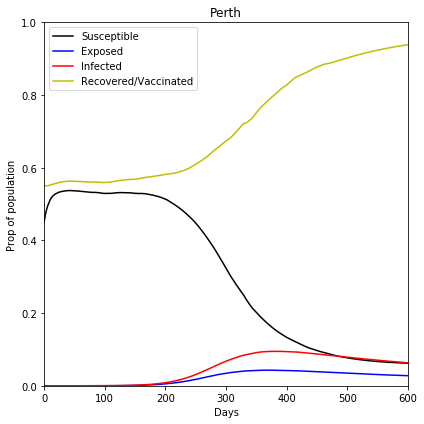

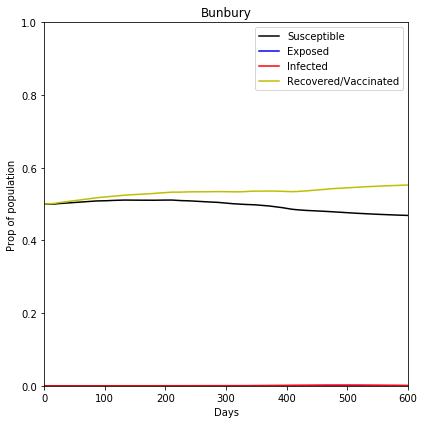

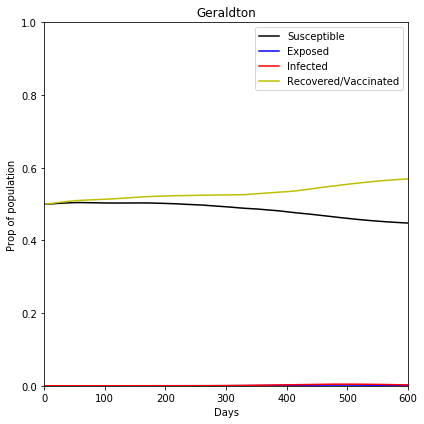

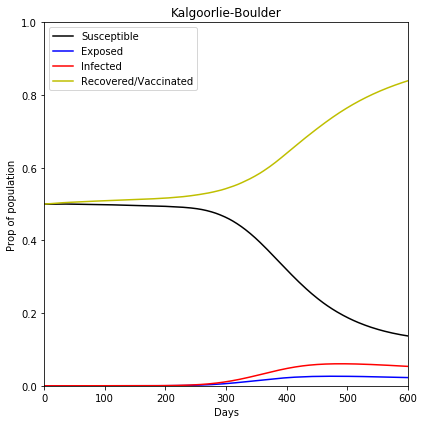

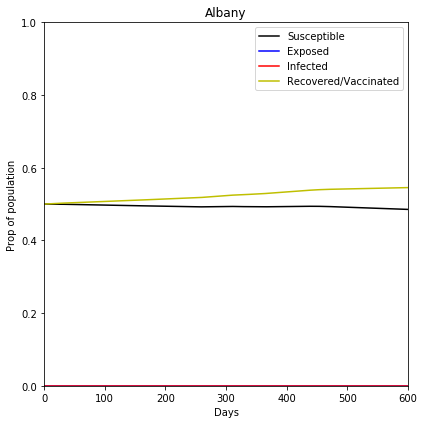

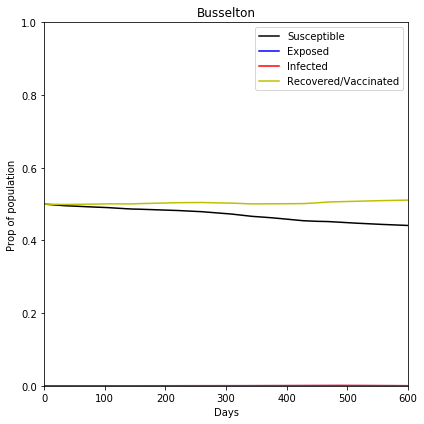

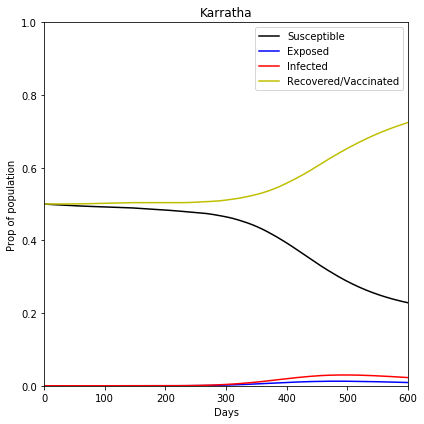

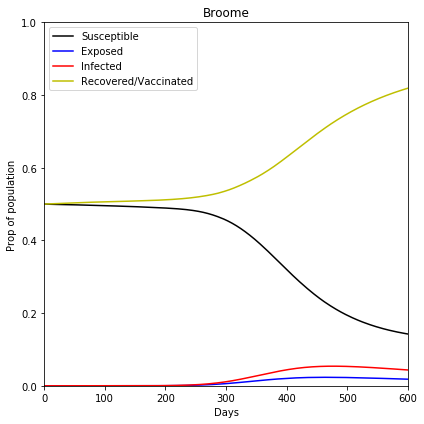

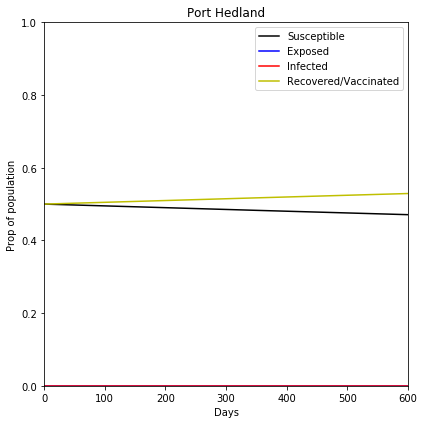

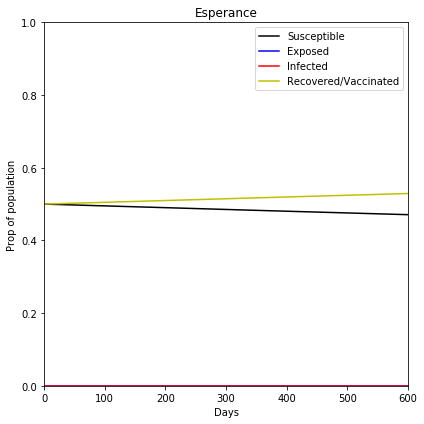

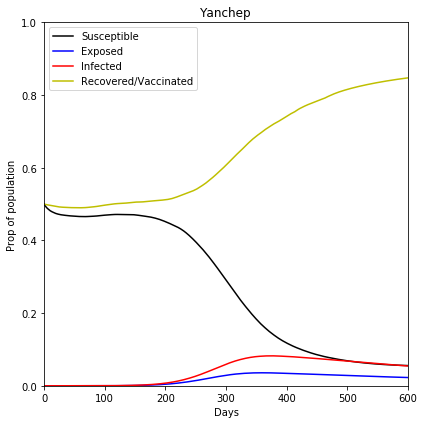

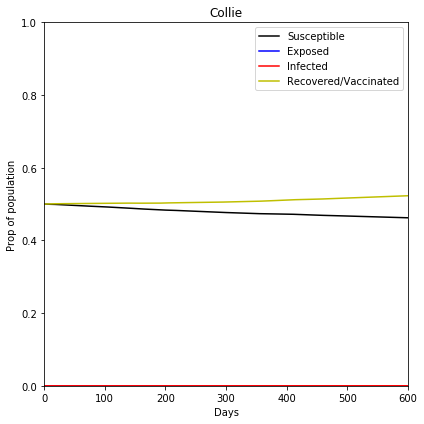

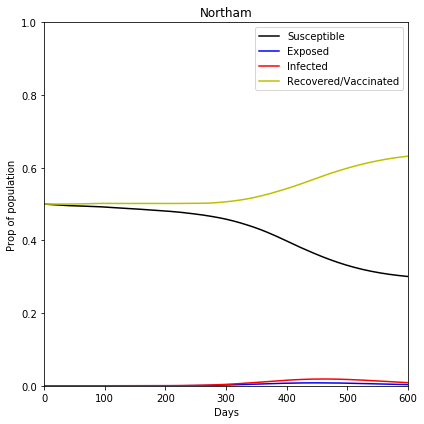

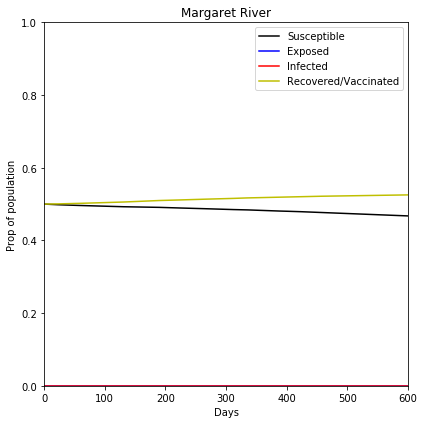

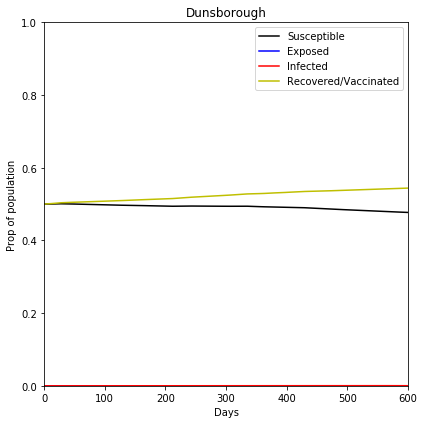

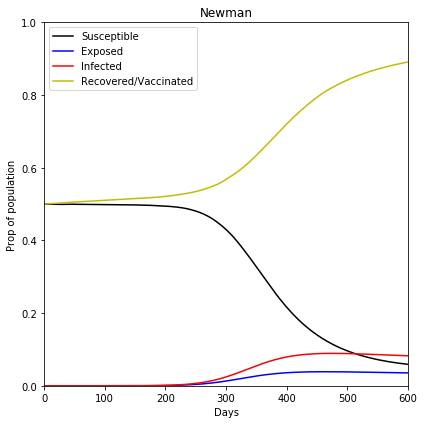

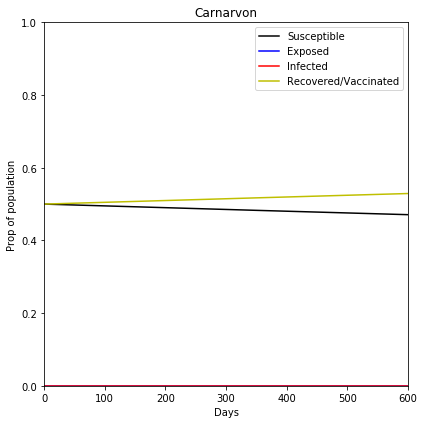

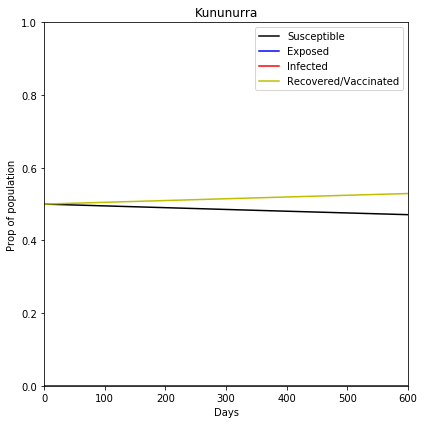

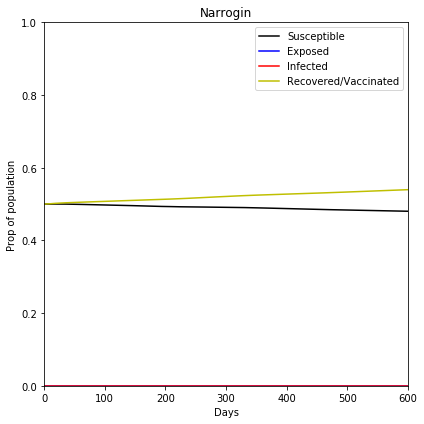

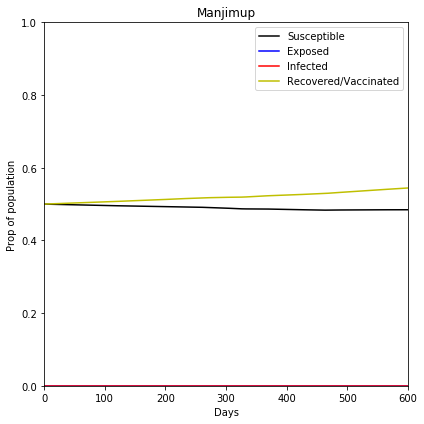

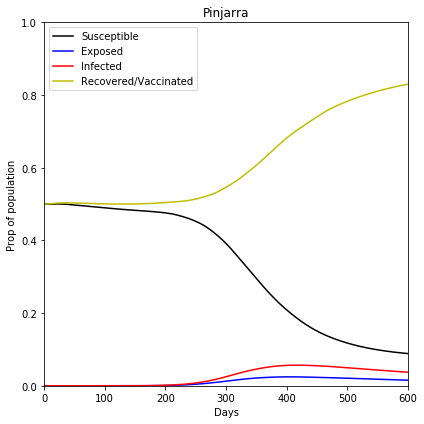

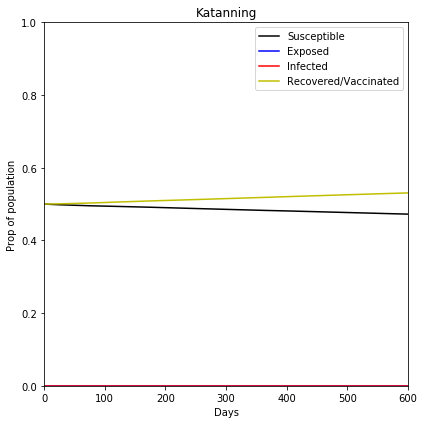

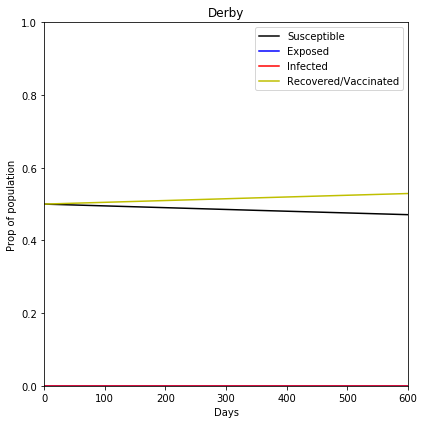

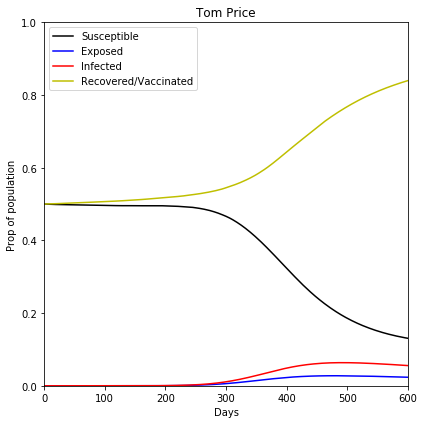

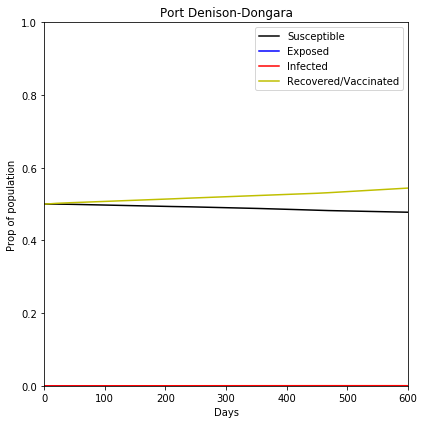

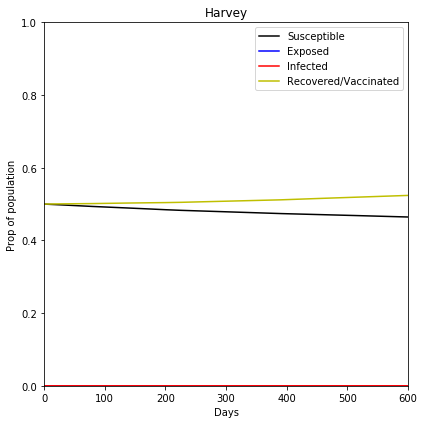

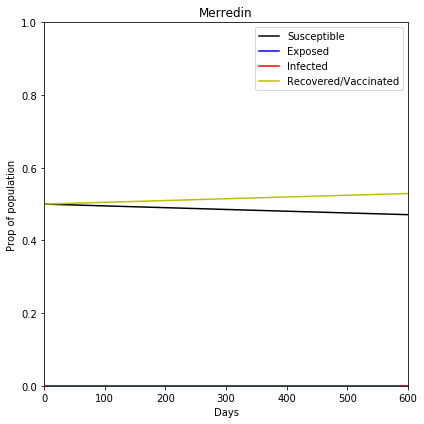

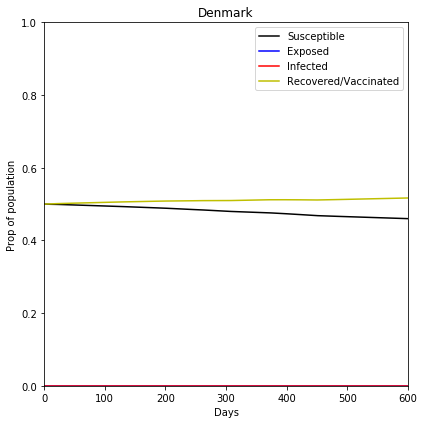

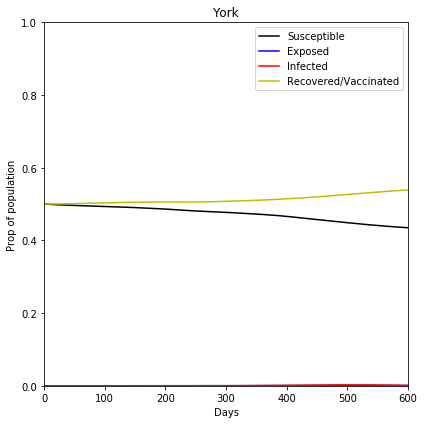

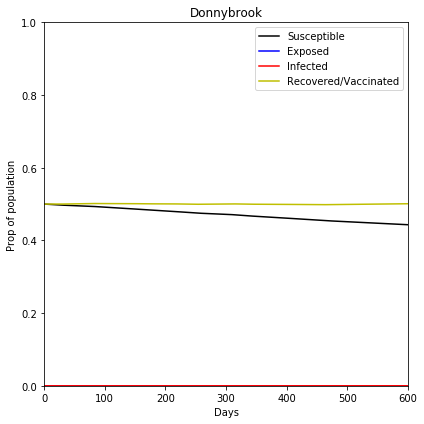

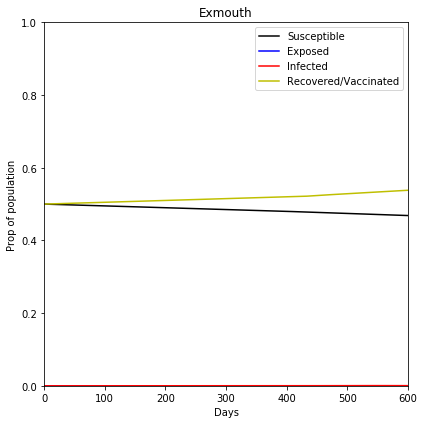

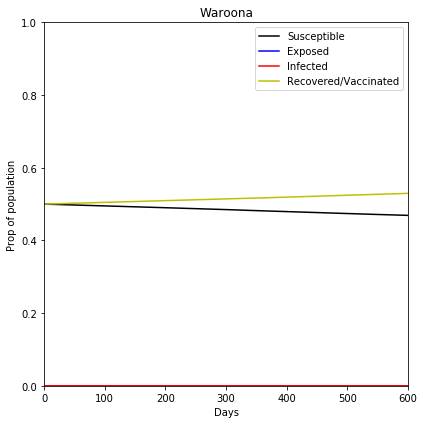

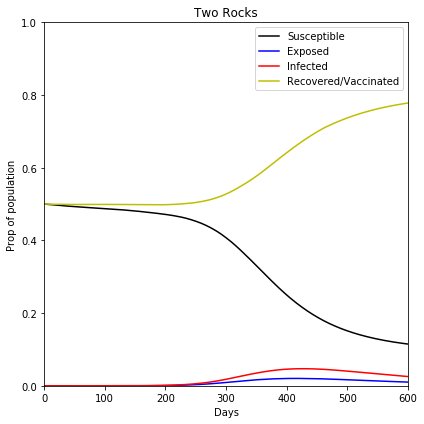

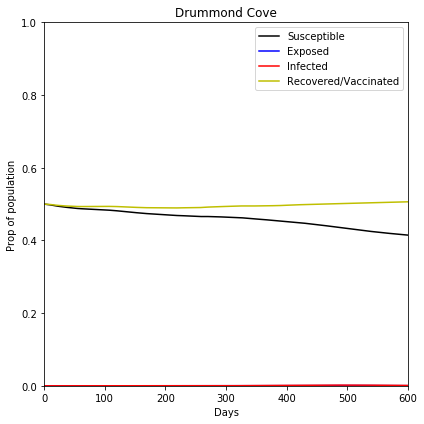

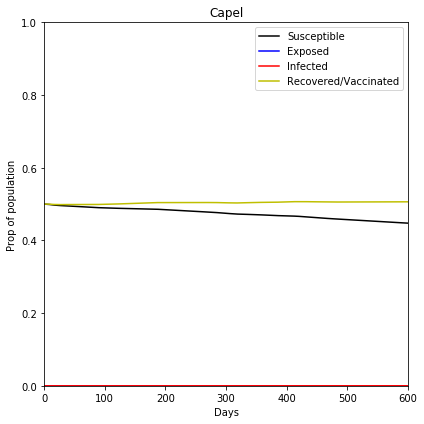

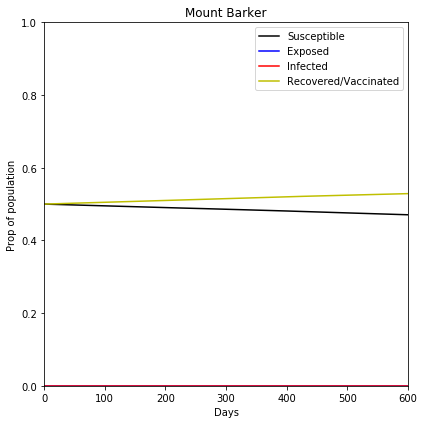

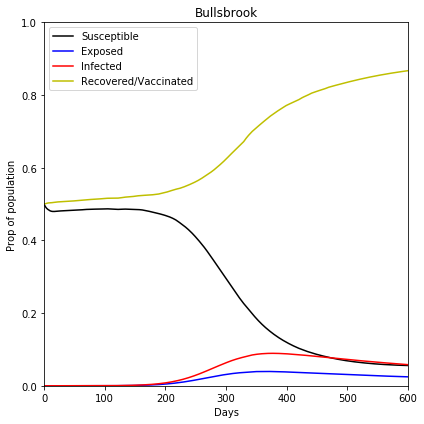

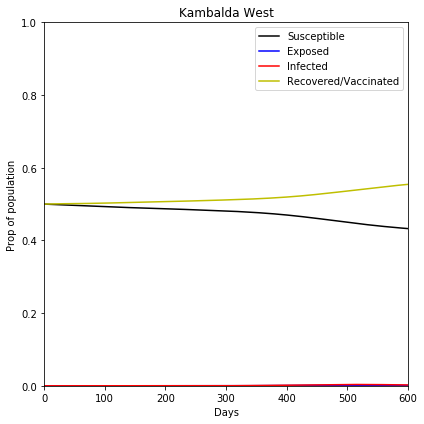

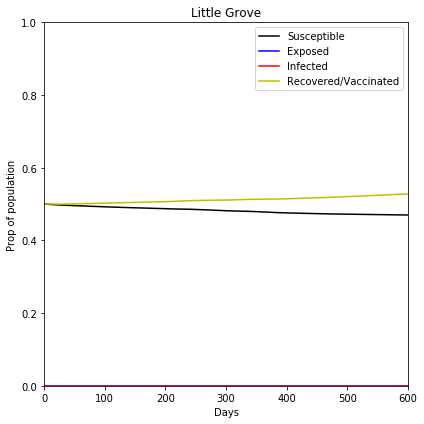

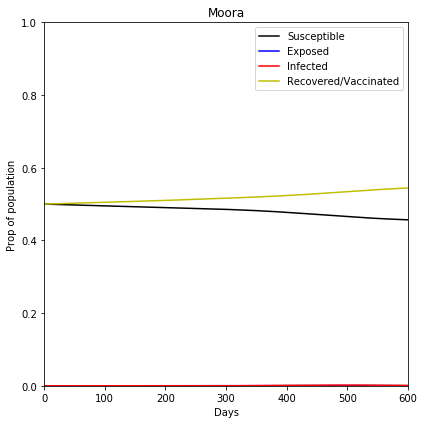

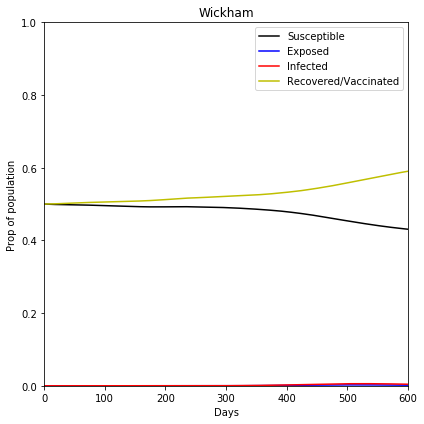

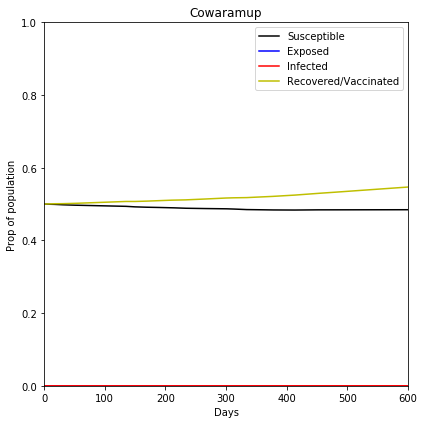

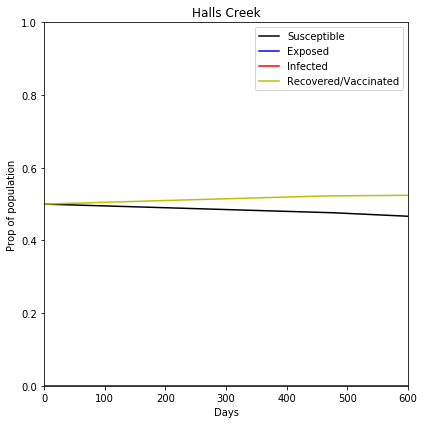

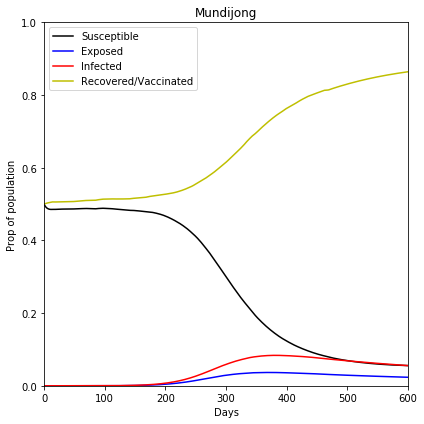

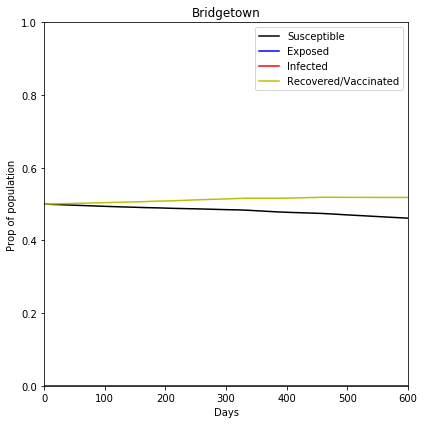

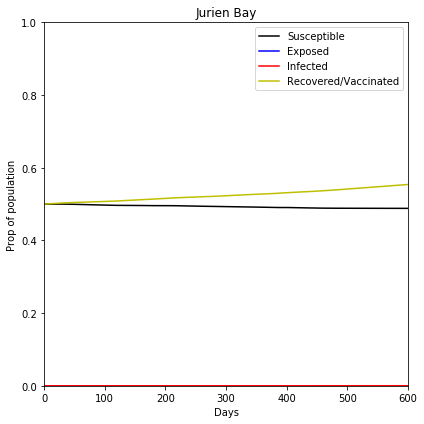

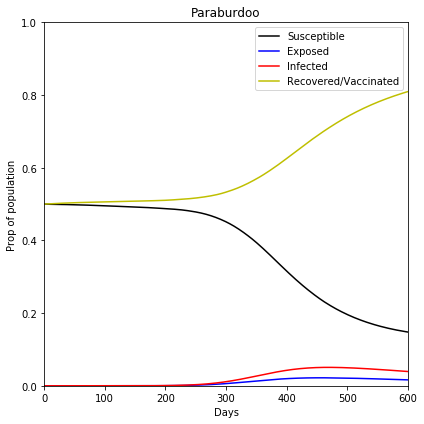

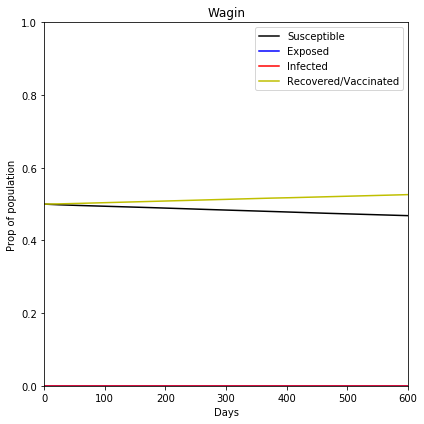

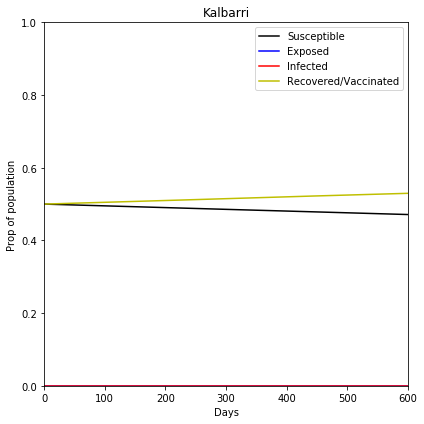

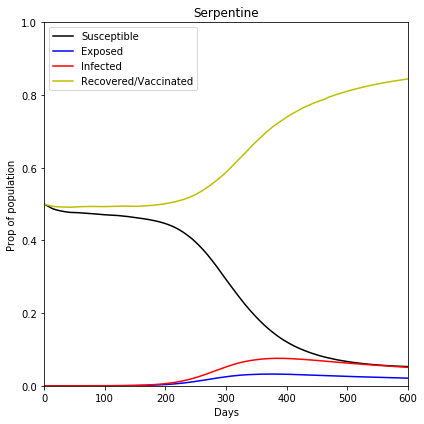

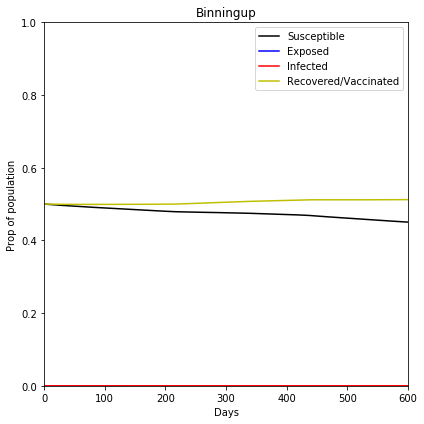

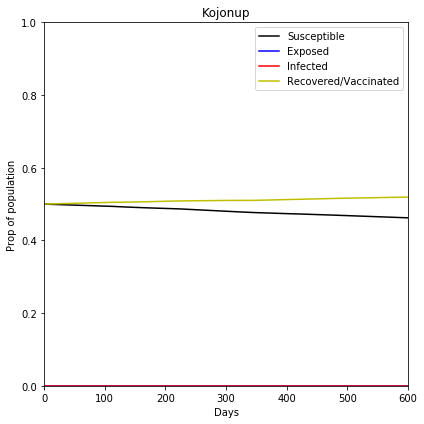

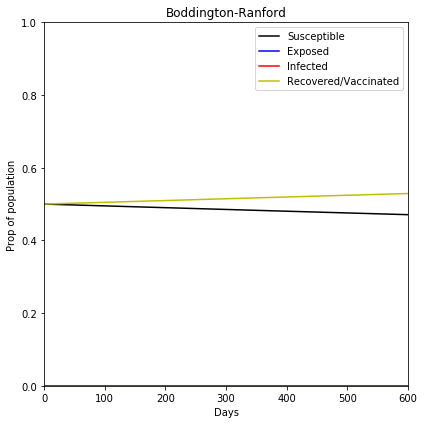

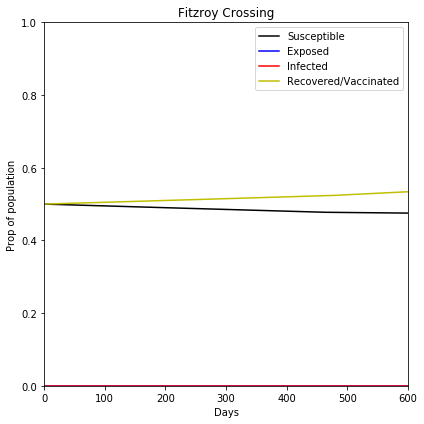

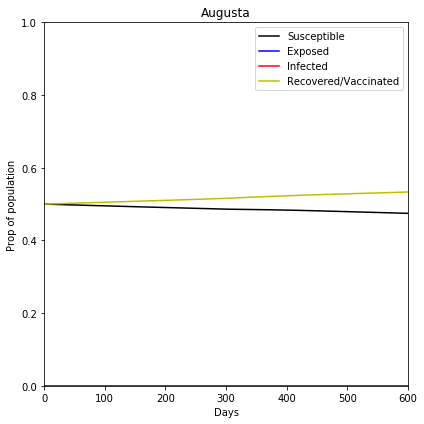

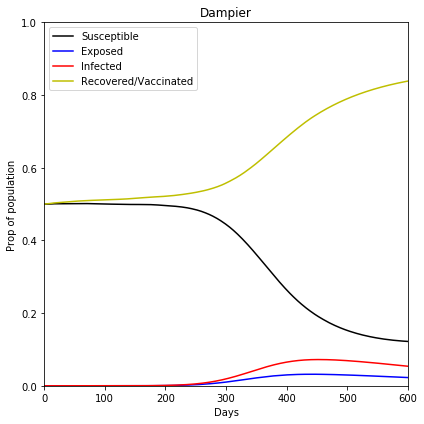

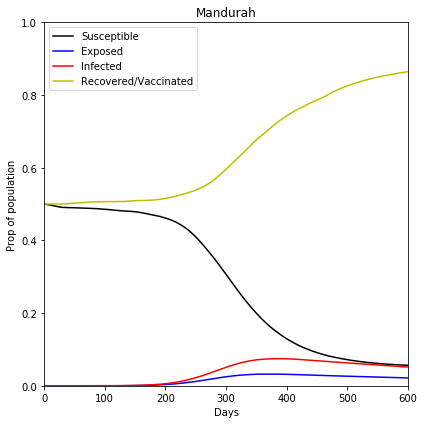

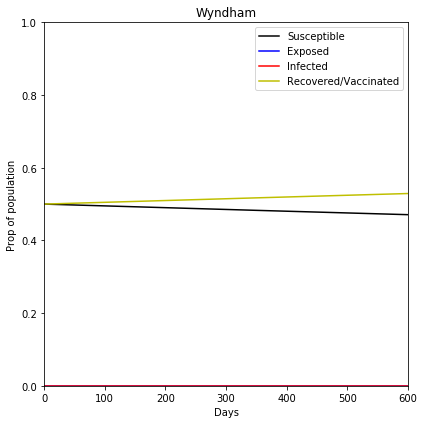

In [46]:

print(end-start)

# PLOT!

for i in range(num):
    plt.figure(figsize = (6,6))
    plt.plot(y[:,4*i],'k', label ='Susceptible')
    plt.plot(y[:,4*i+1],'b', label = 'Exposed')
    plt.plot(y[:,4*i+2],'r', label = 'Infected')
    plt.plot(y[:,4*i+3],'y', label = 'Recovered/Vaccinated')
    plt.title(labeldict[i])
    plt.legend()
    plt.xlabel("Days")
    plt.ylabel("Prop of population")
    plt.xlim([0,t_final])
    plt.ylim([0,1])
    plt.tight_layout()

This is encouraging, but needs to be converted to discrete population with a certain amount of people moving between towns each week, and how that affects the infected people moving is through a binomial distribution. See later code (could use README doc for reference).